In [75]:
import os
from glob import glob
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torch

from ultralytics import YOLO


In [76]:
print(torch.__version__, torch.cuda.is_available())

2.7.1+cu118 True


In [ ]:
# Cellule 3 – Définition de la classe de configuration CFG

class CFG:
    # 1. Mode debug → charge seulement une fraction restreinte du dataset pour tests rapides
    DEBUG = True
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    # 2. Mapping index → nom des classes PPE (10 classes)
    PPE_CLASSES = {
        0: "Hardhat",
        1: "Mask",
        2: "NO-Hardhat",
        3: "NO-Mask",
        4: "NO-Safety Vest",
        5: "Person",
        6: "Safety Cone",
        7: "Safety Vest",
        8: "Machinery",
        9: "Vehicle"
    }

    # 3. Répertoires du dataset (images uniquement)
    TRAIN_IMAGES_PATH = "/home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images"
    VAL_IMAGES_PATH   = "/home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/val/images"
    TEST_IMAGES_PATH  = "/home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/test/images"

    DATASET_PATHS = [
        TRAIN_IMAGES_PATH,
        VAL_IMAGES_PATH,
        TEST_IMAGES_PATH
    ]

    # 4. Répertoire de travail pour tous les résultats, notebooks, poids, etc.
    WORKING_PATH = "/home/maxime/DataDevIA/computervision/security-checker"
    OUTPUT_PATH  = WORKING_PATH

    # 5. Chemin dynamique vers le fichier .pt (poids YOLOv11 Nano téléchargé ou entraîné)
    MODEL_PATH = f"{WORKING_PATH}/yolo11n.pt"  # ← on supposera que vous avez copié yolo11n.pt dans security-checker/

    # 6. Autres chemins de sortie (facultatifs)
    TRAIN_RESULTS  = f"{WORKING_PATH}/train_results.csv"
    METADATA_PATH  = f"{WORKING_PATH}/metadata.json"
    SAVE_PRED_DIR  = f"{WORKING_PATH}/runs/predict"
    SAVE_TRAIN_DIR = f"{WORKING_PATH}/runs/detect/train"

    # 7. Paramètres d’entraînement / détection
    EPOCHS     = 30
    BATCH_SIZE = 12
    IMGSZ      = 640
    DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
    CONF_THRES = 0.25

    @staticmethod
    def seed_everything(seed: int = SEED):
        """
        Fixe la seed pour random, numpy et torch (CPU & GPU).
        """
        import random as _rand
        import numpy as _np
        import torch as _torch

        _rand.seed(seed)
        _np.random.seed(seed)
        _torch.manual_seed(seed)
        if _torch.cuda.is_available():
            _torch.cuda.manual_seed_all(seed)

    @classmethod
    def setup(cls):
        """
        - Crée les répertoires (WORKING_PATH, runs/predict, runs/detect/train).
        - Fixe la seed pour la reproductibilité.
        """
        os.makedirs(cls.WORKING_PATH, exist_ok=True)
        os.makedirs(cls.SAVE_PRED_DIR, exist_ok=True)
        os.makedirs(os.path.dirname(cls.MODEL_PATH), exist_ok=True)
        cls.seed_everything(cls.SEED)

# Exécution de CFG.setup() pour que tous les attributs soient créés
CFG.setup()
print("✅ CFG initialisé, WORKING_PATH vérifié :", CFG.WORKING_PATH)





✅ CFG initialisé, WORKING_PATH vérifié : /home/maxime/DataDevIA/computervision/security-checker


In [78]:

# Cellule 4 – Lister et charger les chemins d’images (train, val, test), puis mélange aléatoire

# 1. Récupération de tous les fichiers .jpg dans chacun des trois sous dossiers images
image_paths = []
for path in CFG.DATASET_PATHS:
    image_paths.extend(glob(os.path.join(path, "*.jpg")))

# 2. Shuffle pour l’aléatoire (à seed fixe pour reproductibilité)
random.seed(CFG.SEED)
random.shuffle(image_paths)

# 3. Ne garder qu’une fraction si DEBUG=True, sinon tout le dataset
num_images = int(len(image_paths) * CFG.FRACTION)
num_images = max(1, num_images)  # au moins 1 image
image_paths = image_paths[:num_images]

print(f"ℹ️ Nombre total d’images chargé en mémoire : {len(image_paths)}")
# (En DEBUG=True, ce sera 5 % des images)




ℹ️ Nombre total d’images chargé en mémoire : 134


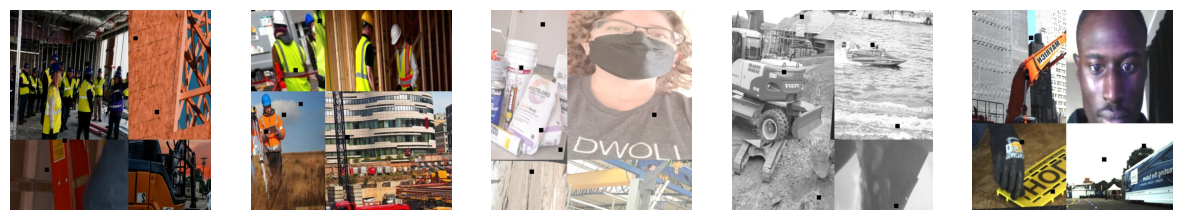

In [79]:
# Cellule 5 – Fonctions utilitaires de visualisation et d’inspection

import random
import cv2
import matplotlib.pyplot as plt

def display_images(image_paths, num=5):
    """
    Affiche aléatoirement `num` images parmi la liste `image_paths`.
    """
    if len(image_paths) == 0:
        print("⚠️ Aucun chemin d’image disponible.")
        return
    num = min(num, len(image_paths))
    sample_paths = random.sample(image_paths, num)

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_paths):
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Impossible de lire : {img_path}")
            continue
        img_rgb = img[..., ::-1]  # BGR → RGB
        plt.subplot(1, num, i + 1)
        plt.imshow(img_rgb)
        plt.axis("off")
    plt.show()

# Exemple d’utilisation :
display_images(image_paths, num=5)


In [80]:
# Cellule 6 – Chargement du modèle YOLOv11 Nano pré-entraîné (COCO)

# 1. Vérifier l’existence du fichier .pt (téléchargé dans security-checker/)
model_path = CFG.MODEL_PATH
if not os.path.isfile(model_path):
    raise FileNotFoundError(f"❌ Impossible de trouver le poids YOLOv11 : {model_path}")

# 2. Charger le modèle
model = YOLO(model_path)
print("✅ Modèle YOLOv11 chargé depuis :", model_path)

# 3. (Optionnel) Afficher la configuration interne du modèle pour confirmation
print(model)



✅ Modèle YOLOv11 chargé depuis : /home/maxime/DataDevIA/computervision/security-checker/yolo11n.pt
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1)

In [81]:

# Cellule « ppe.yaml » corrigée selon l’arborescence réelle

# 1. Construisons la chaîne YAML en fonction de ce que l’on a vérifié
yaml_content = f"""
path: /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data

train: train/images
val:   valid/images
test:  test/images

names:
  0: Hardhat
  1: Mask
  2: NO-Hardhat
  3: NO-Mask
  4: NO-Safety Vest
  5: Person
  6: Safety Cone
  7: Safety Vest
  8: Machinery
  9: Vehicle
"""

# 2. On reporte ce contenu dans le fichier ppe.yaml
yaml_path = os.path.join(CFG.WORKING_PATH, "ppe.yaml")
with open(yaml_path, "w") as f:
    f.write(yaml_content.strip() + "\n")

print("✅ Fichier YAML (corrigé) créé :", yaml_path)




✅ Fichier YAML (corrigé) créé : /home/maxime/DataDevIA/computervision/security-checker/ppe.yaml


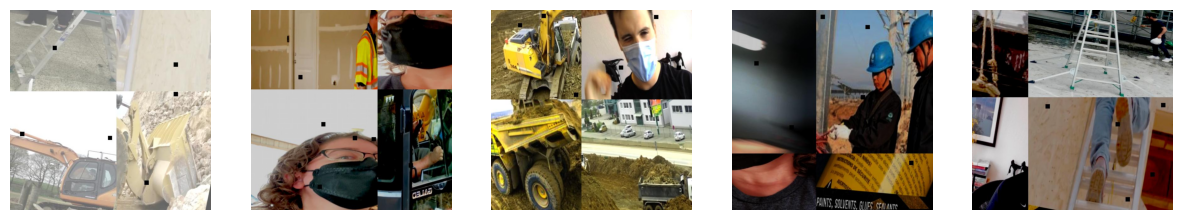

In [82]:
display_images(image_paths)

## Cellule 8 – Fine-tuning / Réentraînement sur vos classes PPE

*(Cette étape est **fortement recommandée** si vous voulez détecter réellement vos 10 classes PPE, car le modèle `yolo11n.pt` d’origine est entraîné sur COCO, pas sur votre jeu de données.)*

1. On charge le modèle COCO Nano (`yolo11n.pt`).  
2. On lance `model.train()` en pointant sur `ppe.yaml`.  
3. À la fin, on obtient un fichier de poids `.pt` (`best.pt`) dans `runs/detect/train/…`.  
4. Ensuite, on redéfinit `CFG.MODEL_PATH` pour pointer vers ce nouveau `best.pt`, et on recharge le modèle.

```python

In [85]:
# Cellule 8 corrigée – Entraînement YOLOv11 Nano sur vos classes PPE (recherche récursive de best.pt)

import os
import glob
from ultralytics import YOLO

# 1. Charger le modèle COCO de base (Nano)
print("⚙️ Chargement du poids de base :", CFG.MODEL_PATH)
base_model = YOLO(CFG.MODEL_PATH)

# 2. Lancer l’entraînement sur vos classes PPE
print("⚙️ Démarrage de l'entraînement avec ppe.yaml :", yaml_path)
base_model.train(
    data=yaml_path,            # chemin vers 'ppe.yaml'
    epochs=CFG.EPOCHS,         # 3 si DEBUG=True, sinon plus
    imgsz=CFG.IMGSZ,
    batch=CFG.BATCH_SIZE,
    device=CFG.DEVICE,
    project=CFG.WORKING_PATH,  # racine pour enregistrer les résultats
    name="yolo11_ppe_train"    # nom du sous-dossier d’entraînement
)

# 3. Rechercher récursivement le meilleur poids (best.pt) dans WORKING_PATH
pattern = os.path.join(CFG.WORKING_PATH, "**", "weights", "best.pt")
matches = glob.glob(pattern, recursive=True)
if not matches:
    raise FileNotFoundError(
        f"❌ Aucun best.pt trouvé dans {CFG.WORKING_PATH}. Vérifiez l’entraînement."
    )

# Choisir le best.pt le plus récent
matches = sorted(matches, key=lambda x: os.path.getmtime(x), reverse=True)
best_pt = matches[0]
print("✅ Poids fine-tuné détecté :", best_pt)

# 4. Mettre à jour CFG.MODEL_PATH et recharger le modèle PPE
CFG.MODEL_PATH = best_pt
assert os.path.isfile(CFG.MODEL_PATH), f"❌ Introuvable : {CFG.MODEL_PATH}"
model = YOLO(CFG.MODEL_PATH)
print("✅ Modèle PPE re-chargé depuis :", CFG.MODEL_PATH)




⚙️ Chargement du poids de base : /home/maxime/DataDevIA/computervision/security-checker/yolo11n.pt
⚙️ Démarrage de l'entraînement avec ppe.yaml : /home/maxime/DataDevIA/computervision/security-checker/ppe.yaml
Ultralytics 8.3.151 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/maxime/DataDevIA/computervision/security-checker/ppe.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_rati

train: Scanning /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/labels.cache... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 356.1±113.4 MB/s, size: 52.1 KB)


val: Scanning /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      1.51G      1.415       2.98      1.504         29        640: 100%|██████████| 652/652 [00:42<00:00, 15.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 21.89it/s]

                   all        114        697      0.513      0.336      0.347      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      1.53G      1.323      2.001      1.466         10        640: 100%|██████████| 652/652 [00:38<00:00, 16.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 23.35it/s]

                   all        114        697      0.588      0.442      0.479      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      1.61G      1.246      1.779      1.412         46        640: 100%|██████████| 652/652 [00:37<00:00, 17.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:00<00:00, 23.41it/s]

                   all        114        697      0.708      0.533       0.58      0.286



3 epochs completed in 0.034 hours.
Optimizer stripped from /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/weights/last.pt, 5.5MB
Optimizer stripped from /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/weights/best.pt, 5.5MB

Validating /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


                   all        114        697      0.707      0.534      0.582      0.287
               Hardhat         42         79      0.845      0.633      0.745      0.433
                  Mask         19         21      0.938      0.719      0.795      0.385
            NO-Hardhat         37         69      0.675       0.42      0.468       0.17
               NO-Mask         44         74      0.563      0.378      0.359      0.132
        NO-Safety Vest         56        106      0.645      0.377      0.433      0.175
                Person         84        166      0.863       0.57      0.687      0.347
           Safety Cone         13         44      0.596       0.75      0.671       0.34
           Safety Vest         28         41      0.626      0.561      0.604      0.329
             Machinery         26         55      0.855      0.564      0.702      0.355
               Vehicle         16         42      0.463       0.37      0.359      0.207
Speed: 0.3ms preproce

In [86]:
# Cellule X corrigée – Rechercher dynamiquement le meilleur poids sans présupposer runs/detect/train/

import os
import glob

# 1. On recherche tous les best.pt sous WORKING_PATH, récursivement
pattern = os.path.join(CFG.WORKING_PATH, "**", "weights", "best.pt")
matches = glob.glob(pattern, recursive=True)

if not matches:
    raise FileNotFoundError(
        f"⚠️ Aucun best.pt trouvé sous {CFG.WORKING_PATH}. Vérifiez que l’entraînement s’est bien terminé."
    )

# 2. Si plusieurs best.pt sont trouvés, on choisit le plus récent
matches = sorted(matches, key=lambda x: os.path.getmtime(x), reverse=True)
best_pt = matches[0]

print("✔️ Poids fine‐tuné détecté :", best_pt)



✔️ Poids fine‐tuné détecté : /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/weights/best.pt


In [94]:
# Cellule X+1 – Mettre à jour CFG.MODEL_PATH et recharger le modèle fine‐tuné

# 1. Mettre à jour CFG.MODEL_PATH avec le chemin best_pt trouvé
CFG.MODEL_PATH = best_pt
assert os.path.isfile(CFG.MODEL_PATH), f"❌ Introuvable : {CFG.MODEL_PATH}"

# 2. Recharger le modèle PPE fine‐tuné
from ultralytics import YOLO
model = YOLO(CFG.MODEL_PATH)
print("✅ Modèle PPE re-chargé depuis :", CFG.MODEL_PATH)


✅ Modèle PPE re-chargé depuis : /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/weights/best.pt


In [99]:
# Cellule X+2 corrigée – Validation finale et affichage des métriques

# 1. Exécuter la validation sur le split de validation défini dans ppe.yaml
metrics = model.val(
    data=os.path.join(CFG.WORKING_PATH, "ppe.yaml"),
    imgsz=CFG.IMGSZ,
    save=True,  # pour enregistrer les résultats dans runs/val
)
# 2. Afficher directement l’objet metrics (qui affiche résumé et valeurs clés)
print("\n📊 MÉTRIQUES DE VALIDATION FINALES")
print(metrics)

# 3. Si vous voulez explorer plus finement les attributs, vous pouvez faire par exemple :
#    print(metrics.__dict__)  # pour voir tous les champs disponibles



Ultralytics 8.3.151 🚀 Python-3.12.3 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2171.3±568.1 MB/s, size: 60.3 KB)


val: Scanning /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/valid/labels.cache... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]


                   all        114        697      0.711      0.533      0.581      0.286
               Hardhat         42         79      0.865      0.633      0.747      0.431
                  Mask         19         21      0.938      0.719      0.795       0.38
            NO-Hardhat         37         69      0.675       0.42      0.468      0.173
               NO-Mask         44         74      0.561      0.378      0.357      0.129
        NO-Safety Vest         56        106      0.671      0.377      0.433      0.173
                Person         84        166      0.859      0.566      0.686      0.347
           Safety Cone         13         44      0.599       0.75      0.672      0.337
           Safety Vest         28         41      0.628      0.561      0.604      0.328
             Machinery         26         55      0.859      0.564      0.703      0.356
               Vehicle         16         42      0.451      0.357      0.346      0.206
Speed: 2.2ms preproce

📂 Contenu de runs/detect/:
  • val3
  • val2
  • val

📁 Dossier 'val3' contient 6 PNG :
   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val3/F1_curve.png


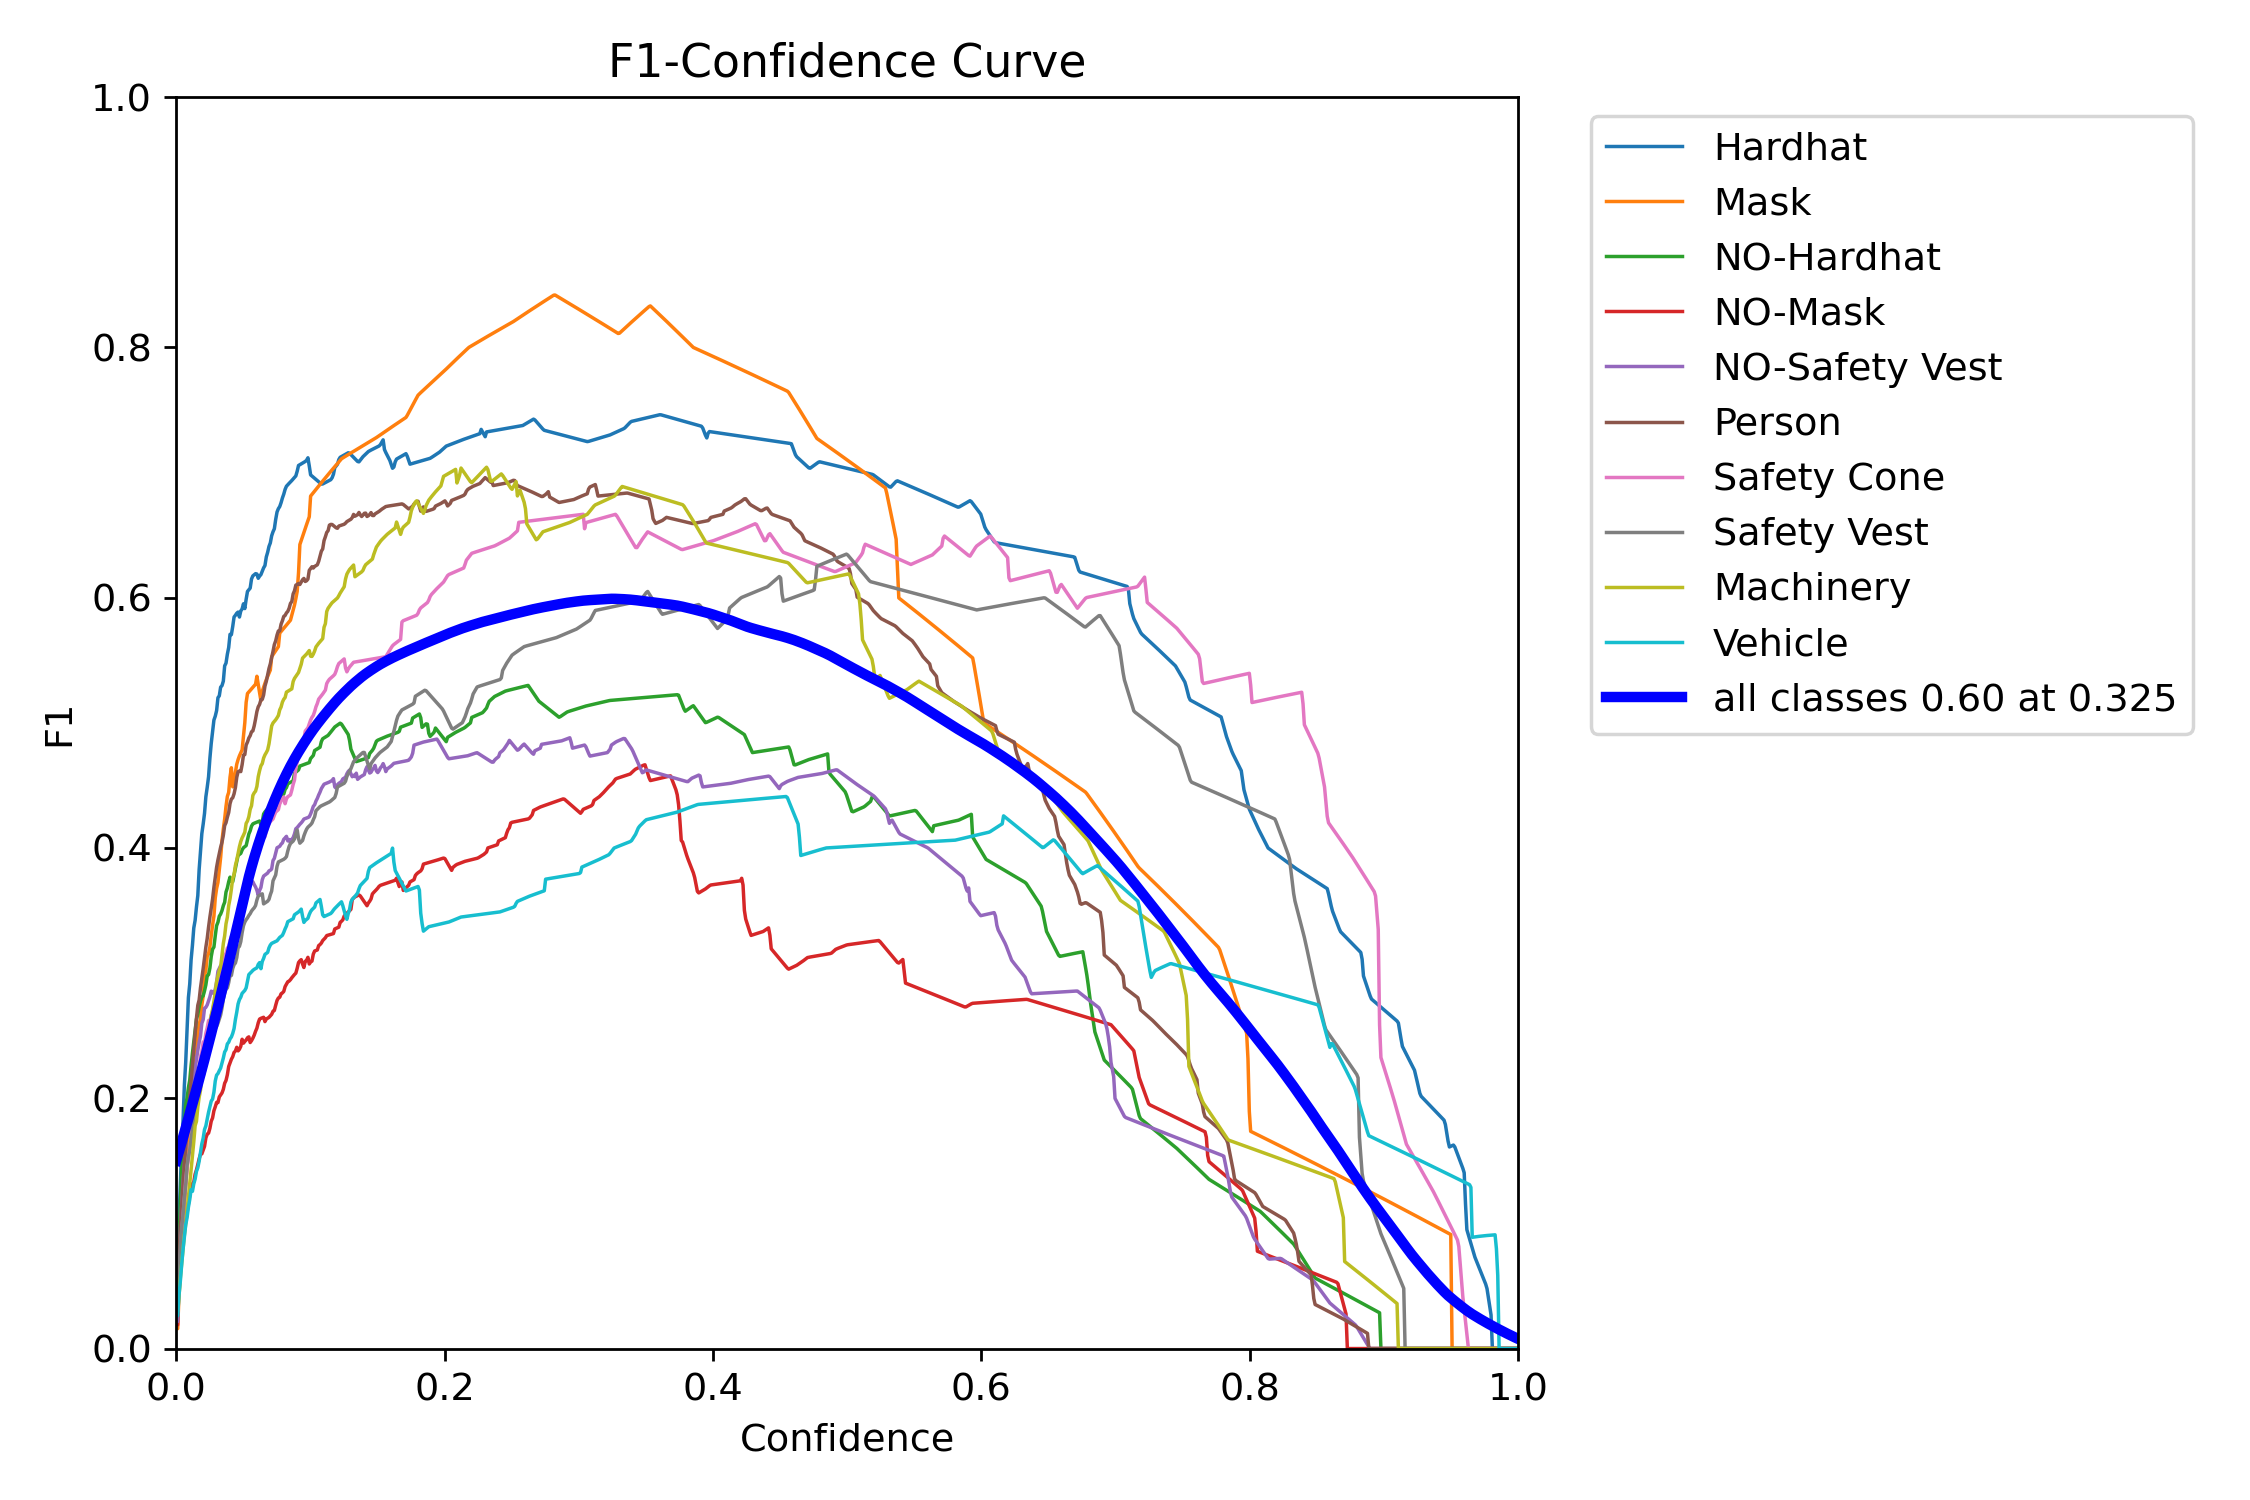

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val3/confusion_matrix.png


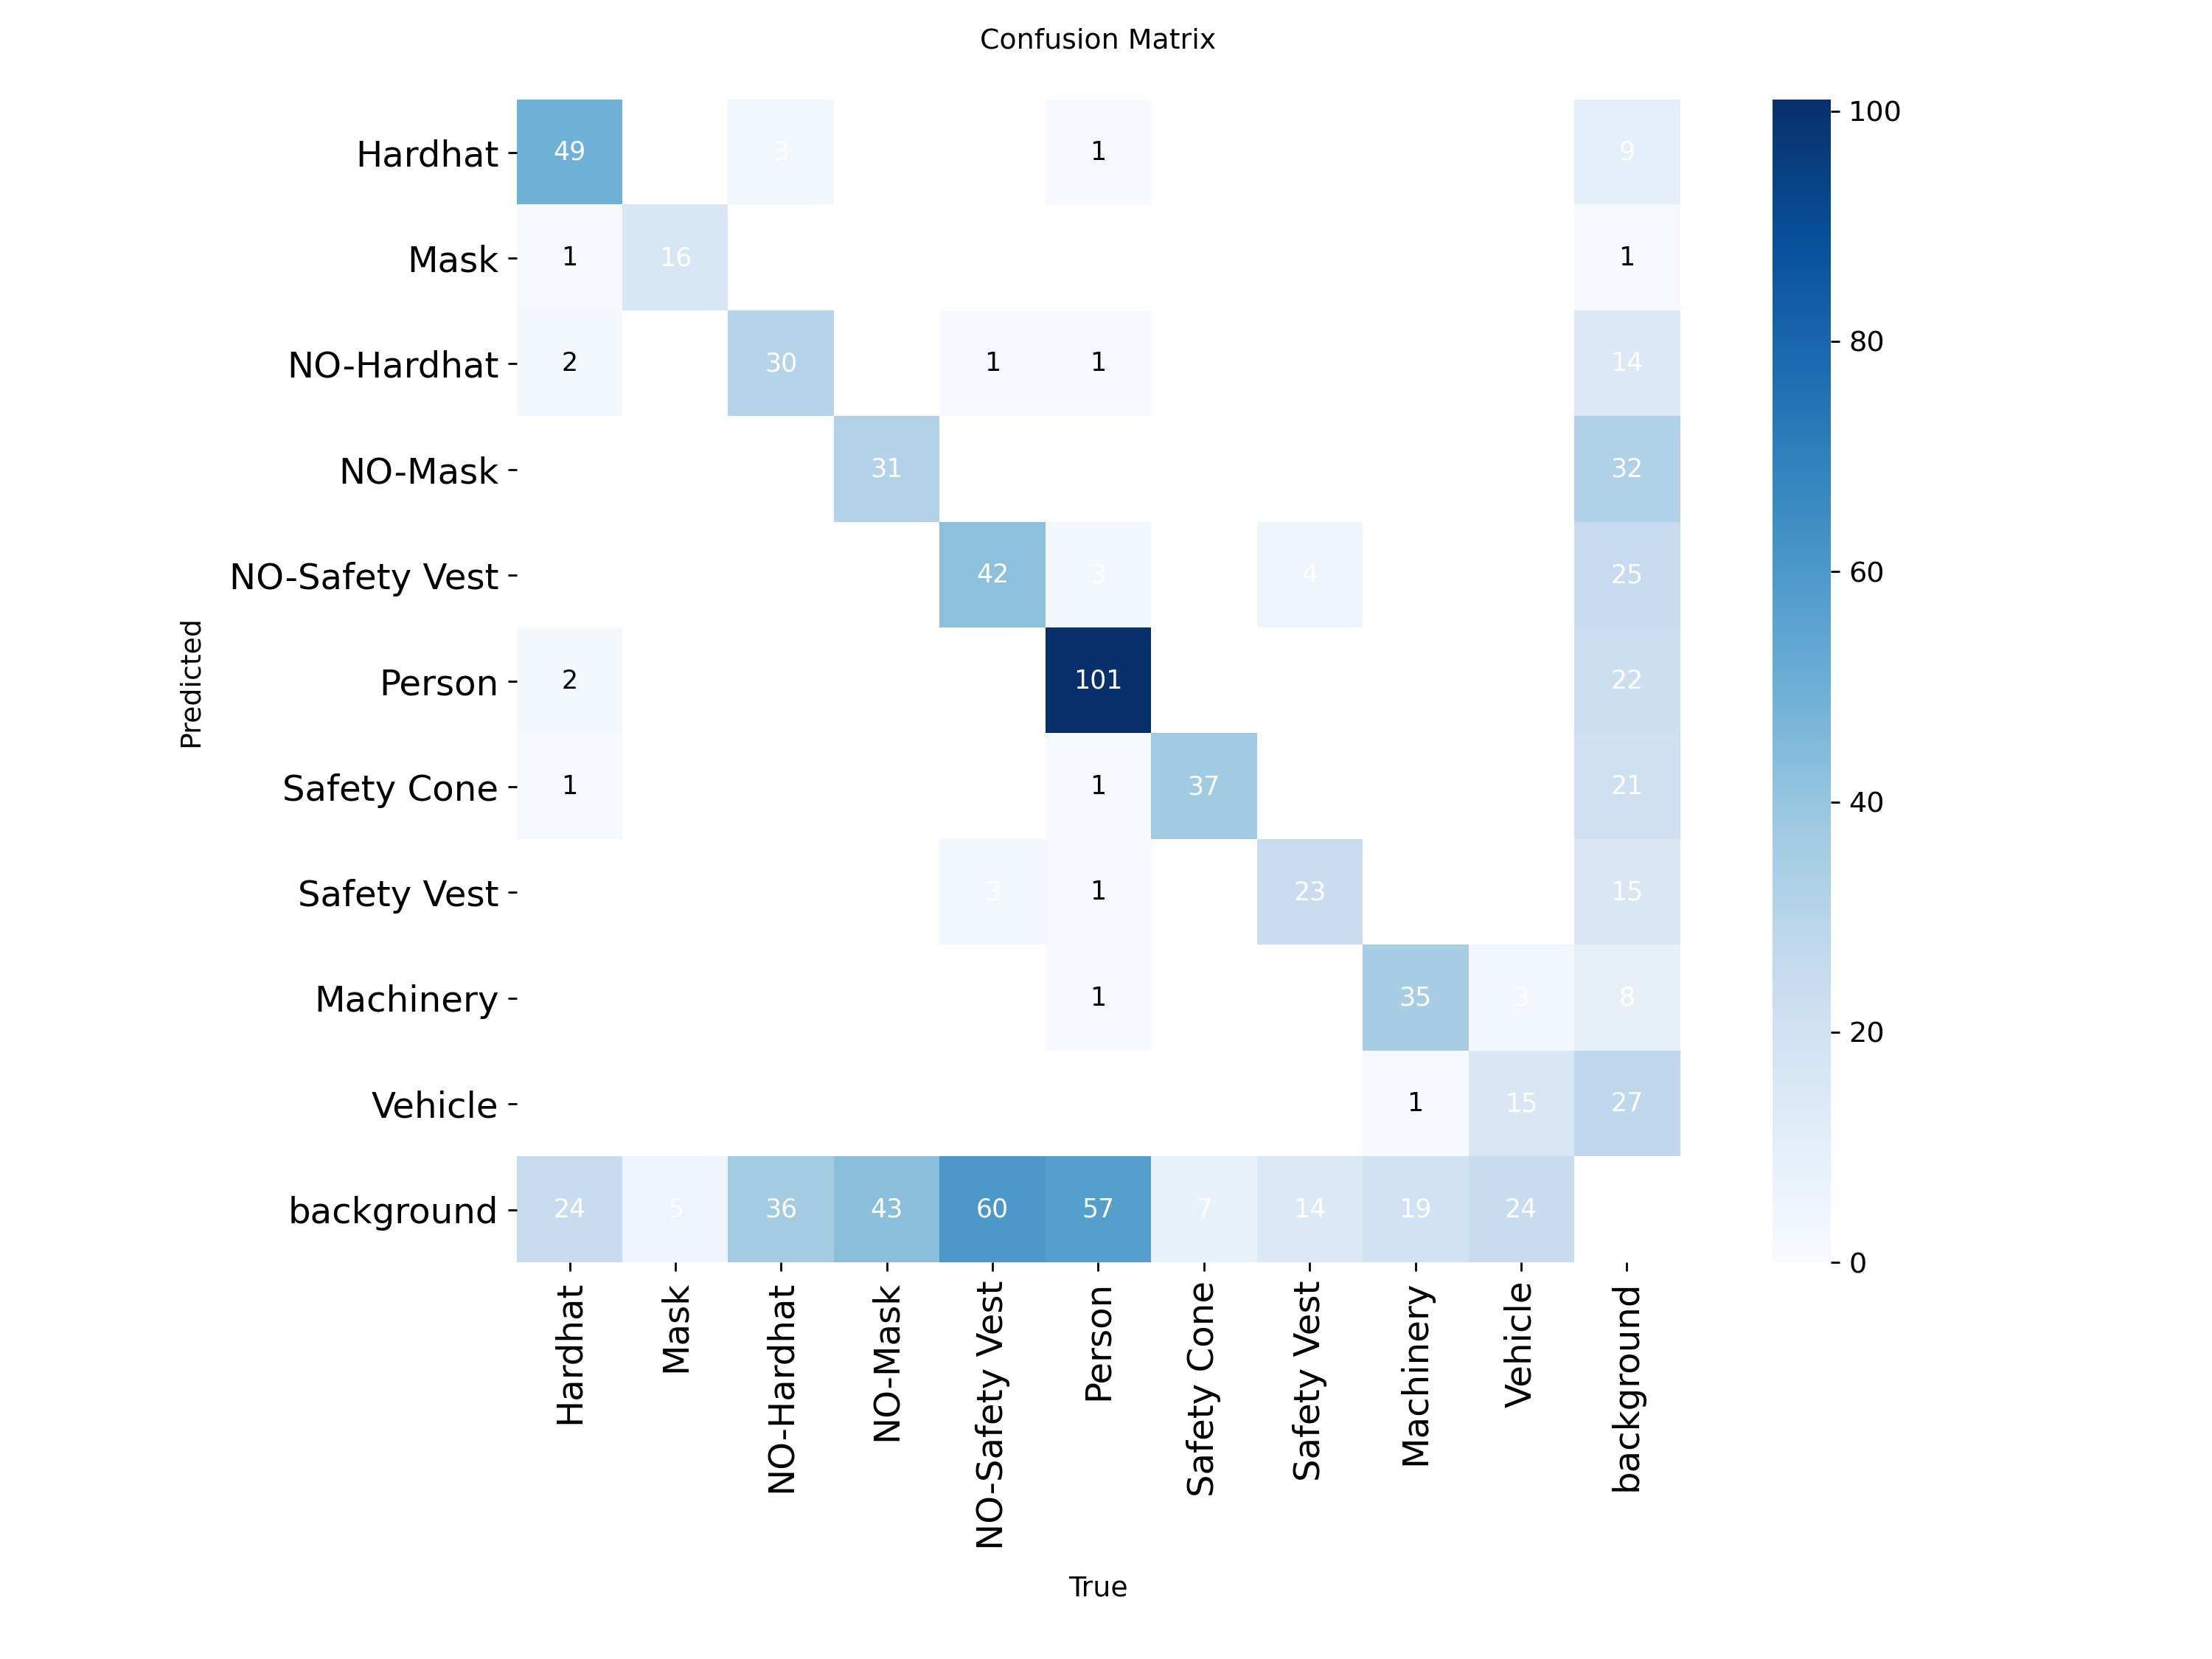

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val3/R_curve.png


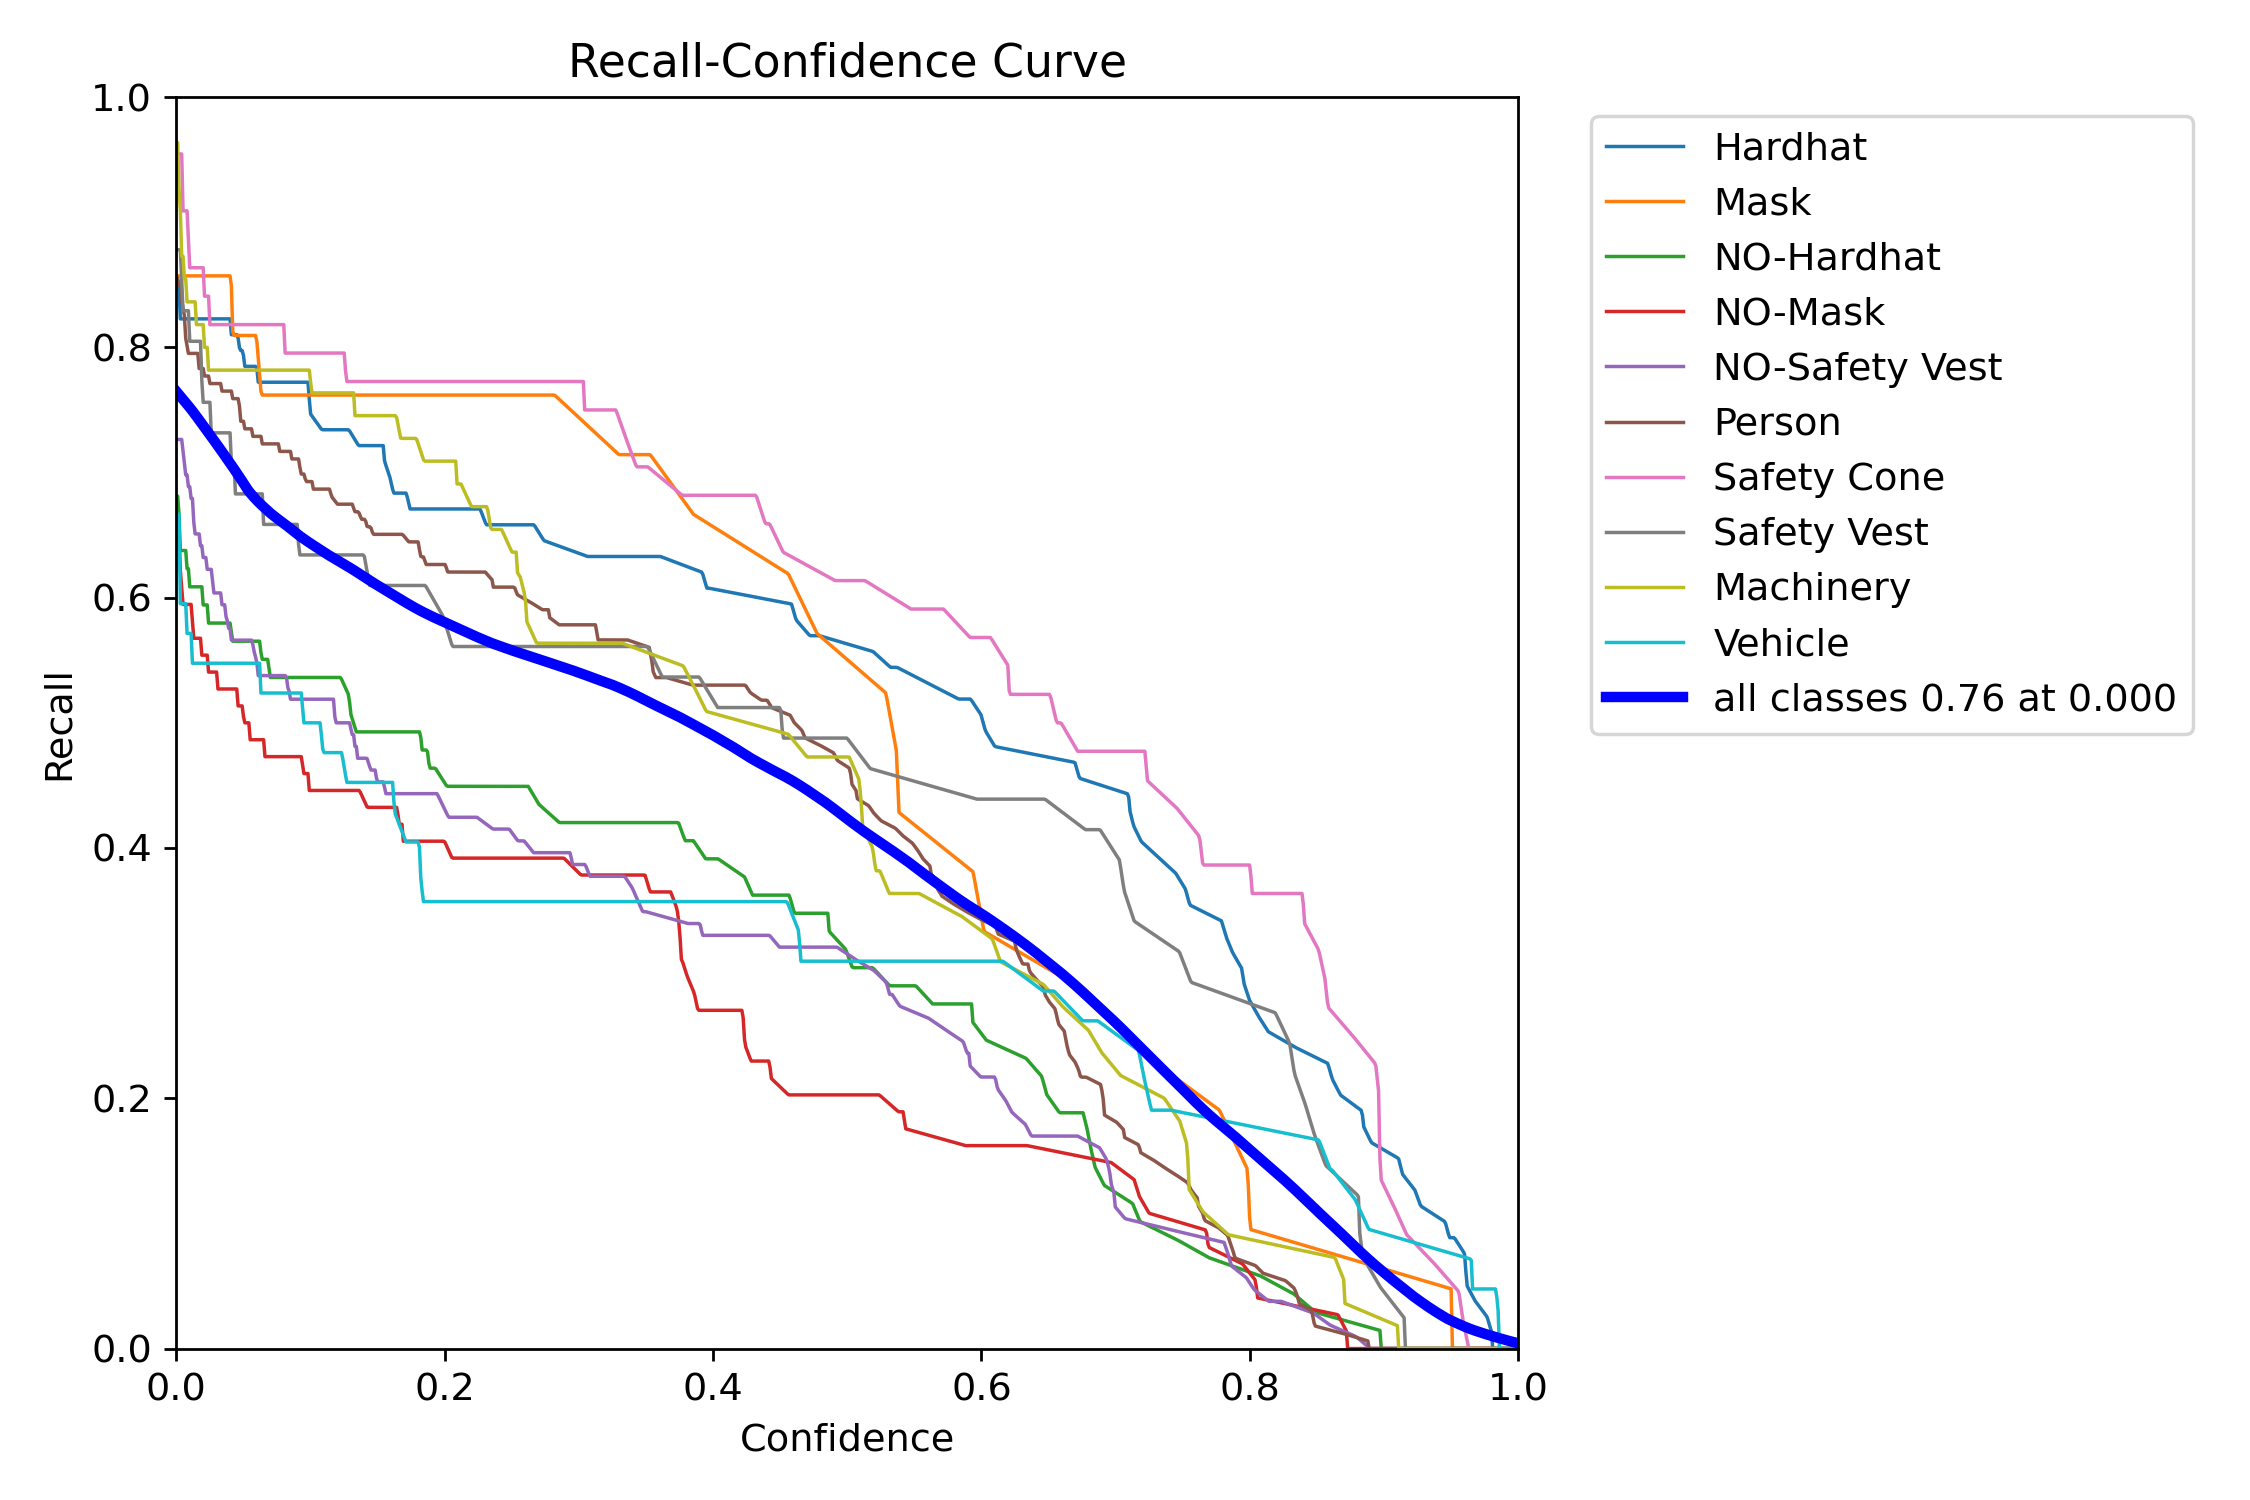

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val3/confusion_matrix_normalized.png


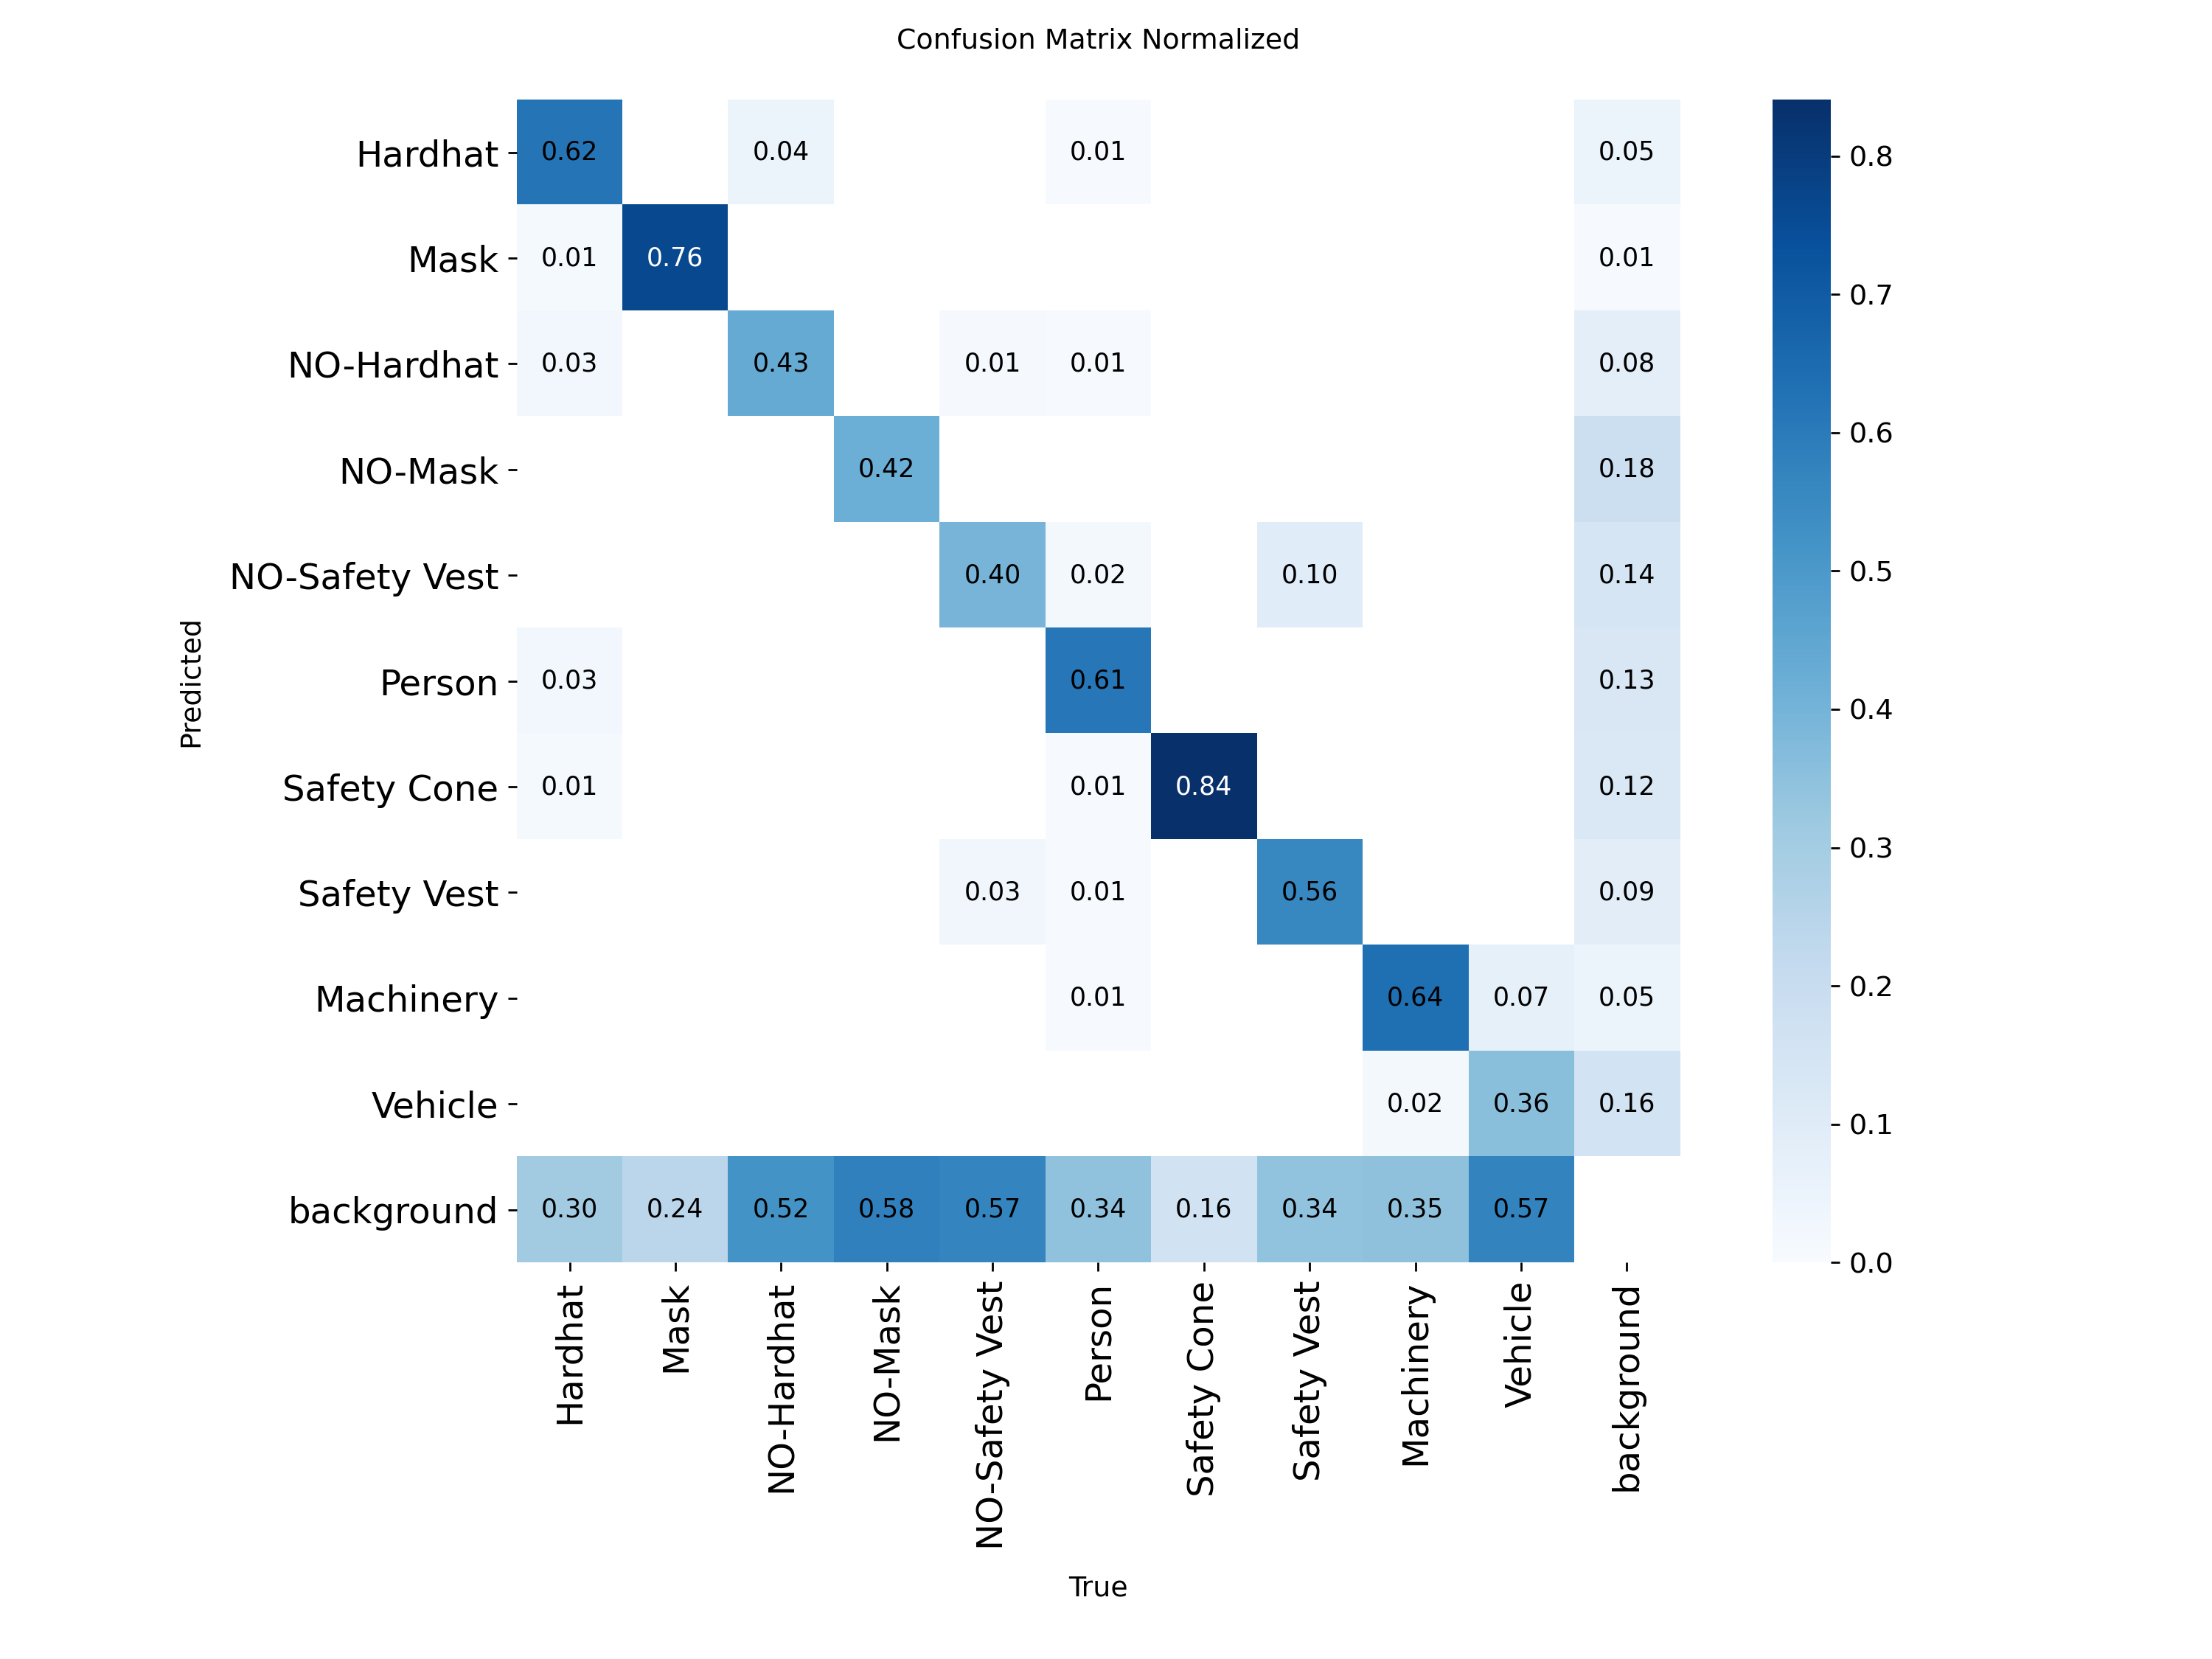

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val3/PR_curve.png


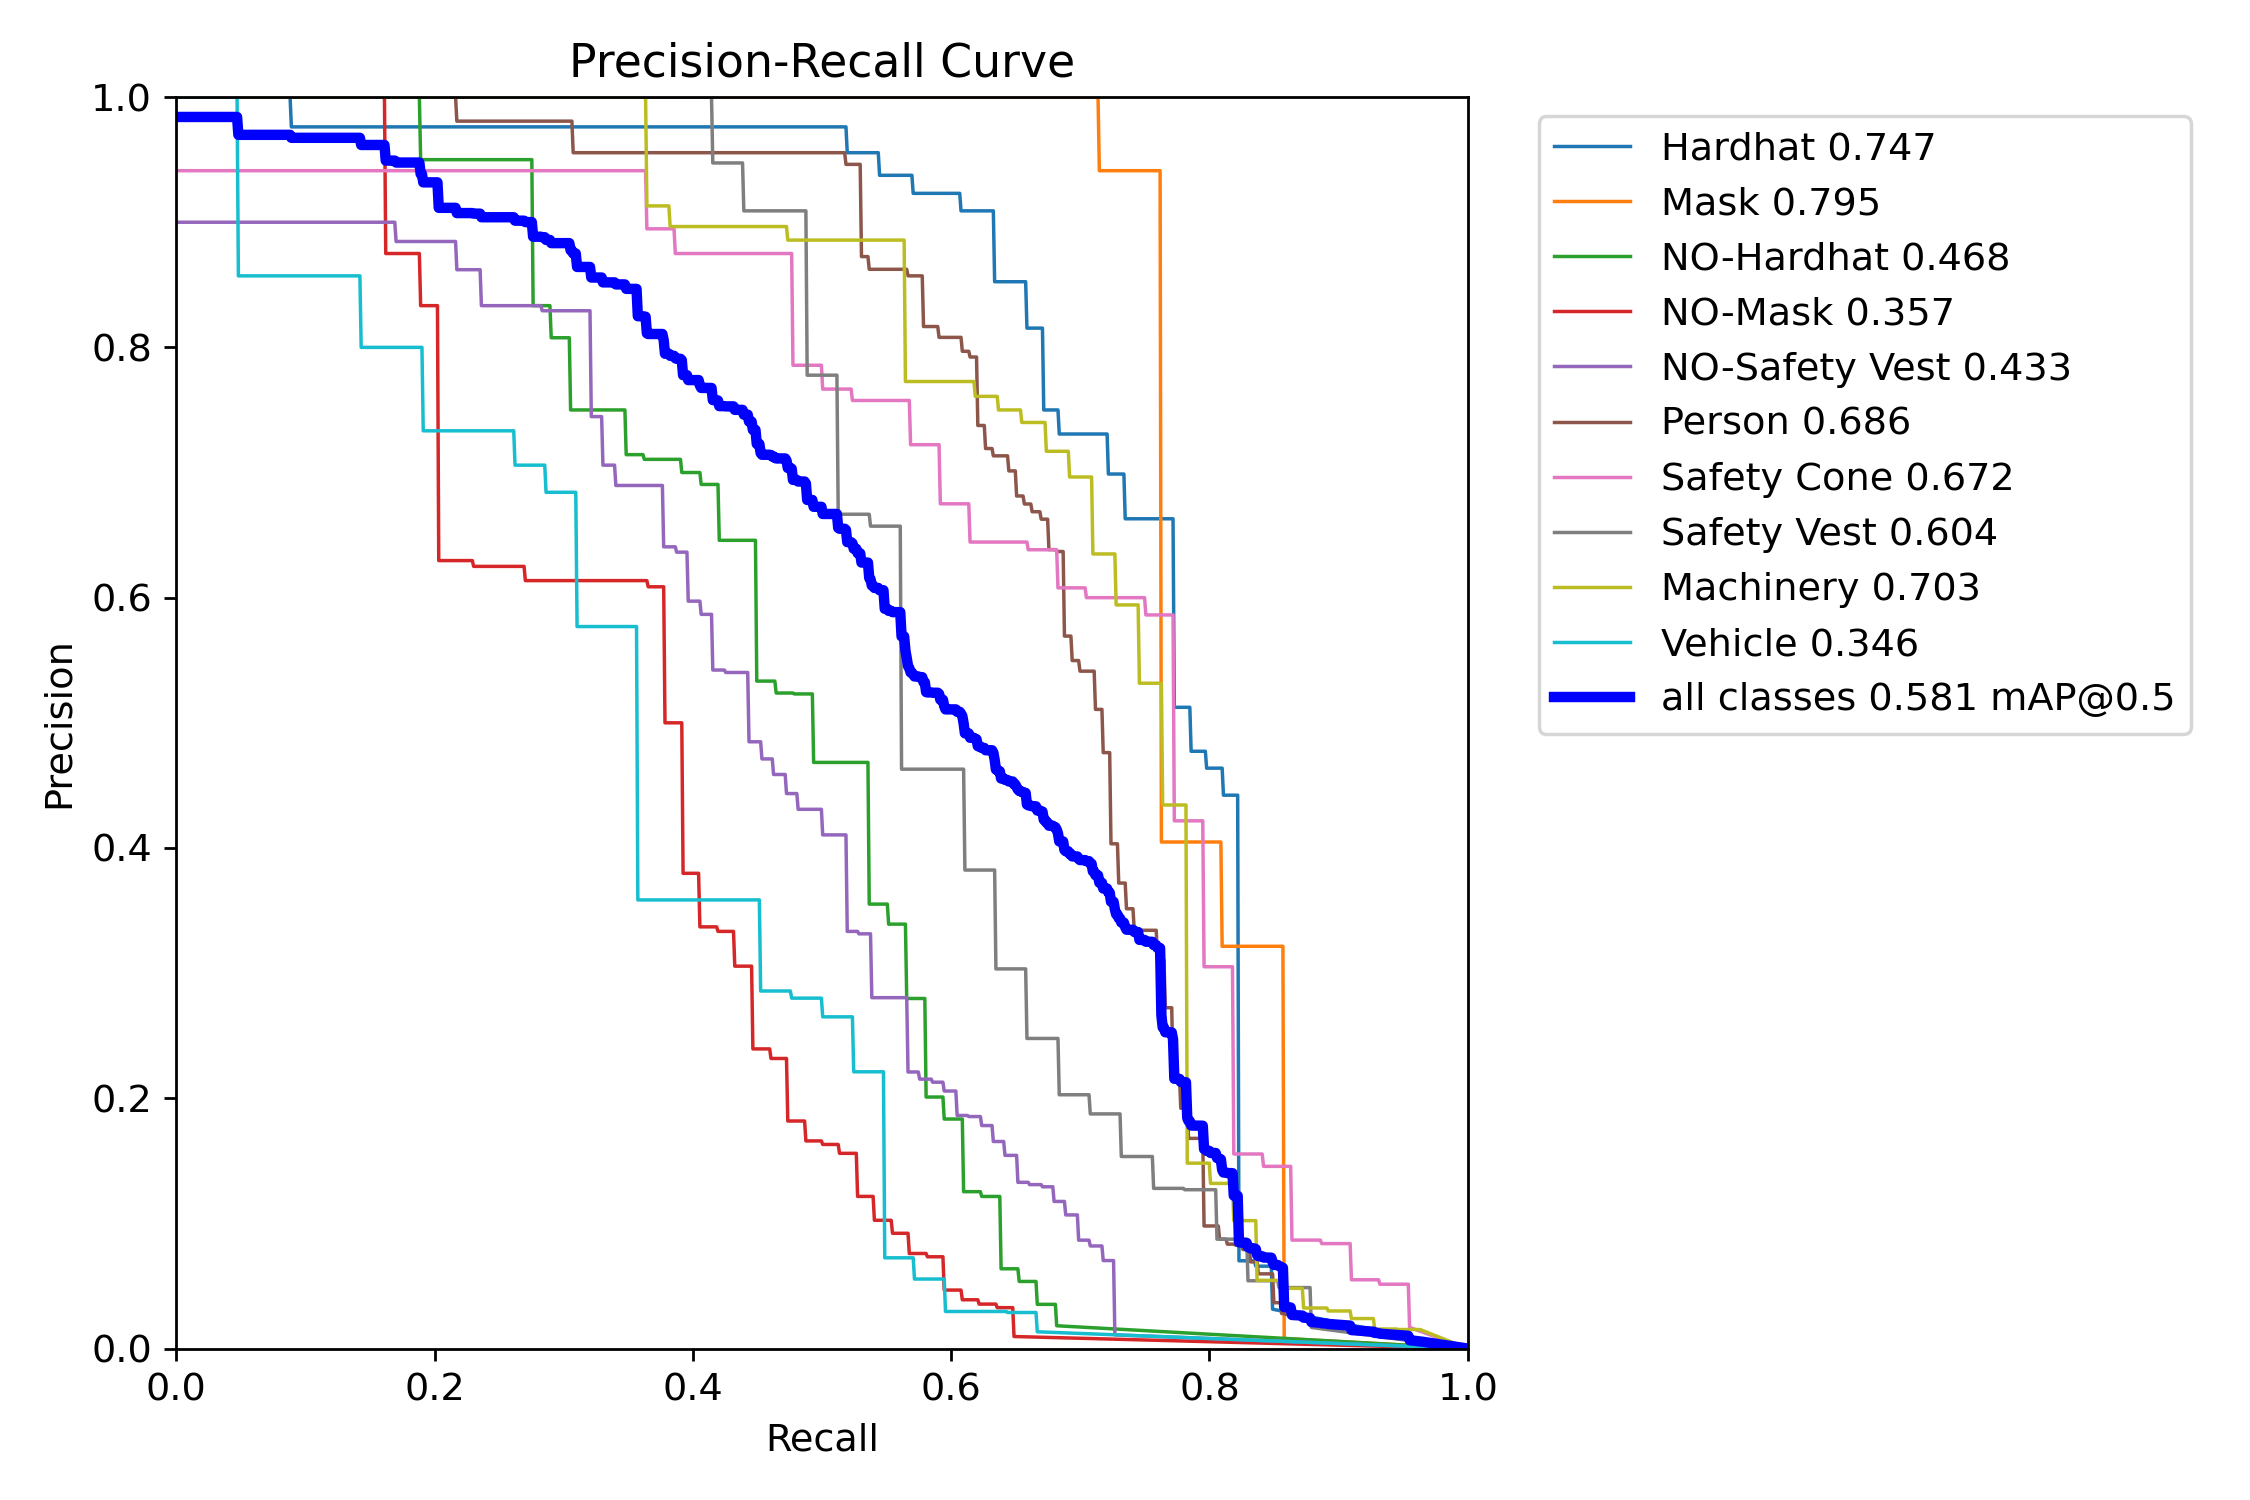

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val3/P_curve.png


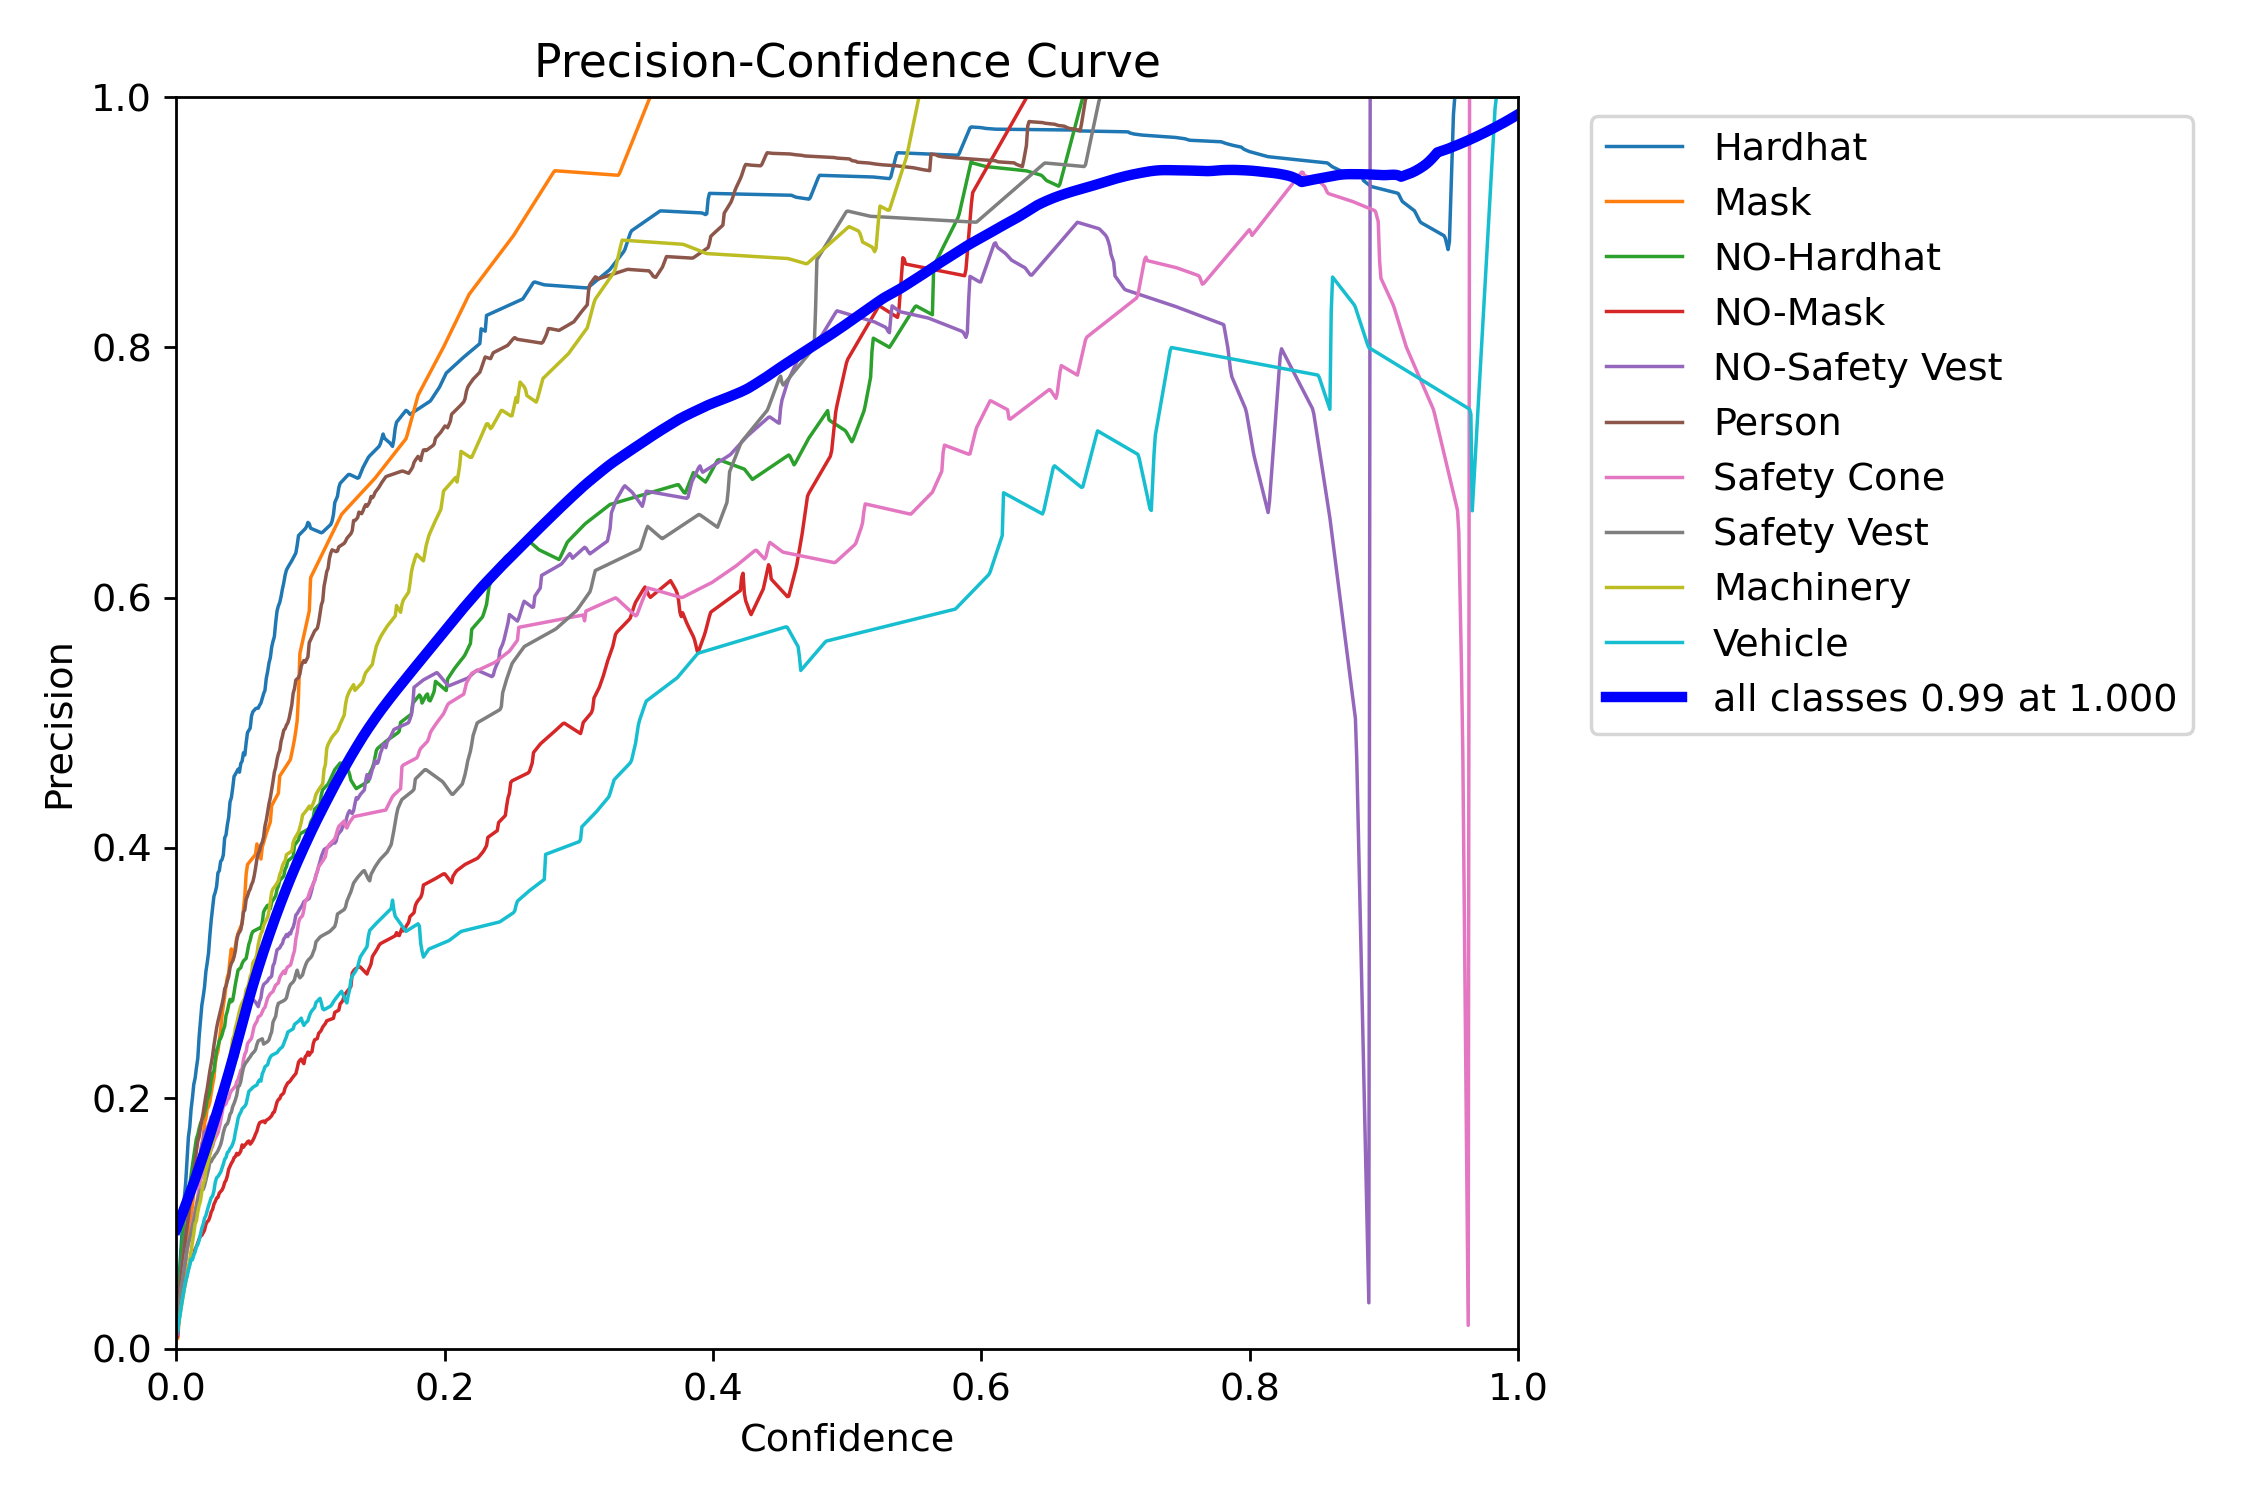


📁 Dossier 'val2' contient 6 PNG :
   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val2/F1_curve.png


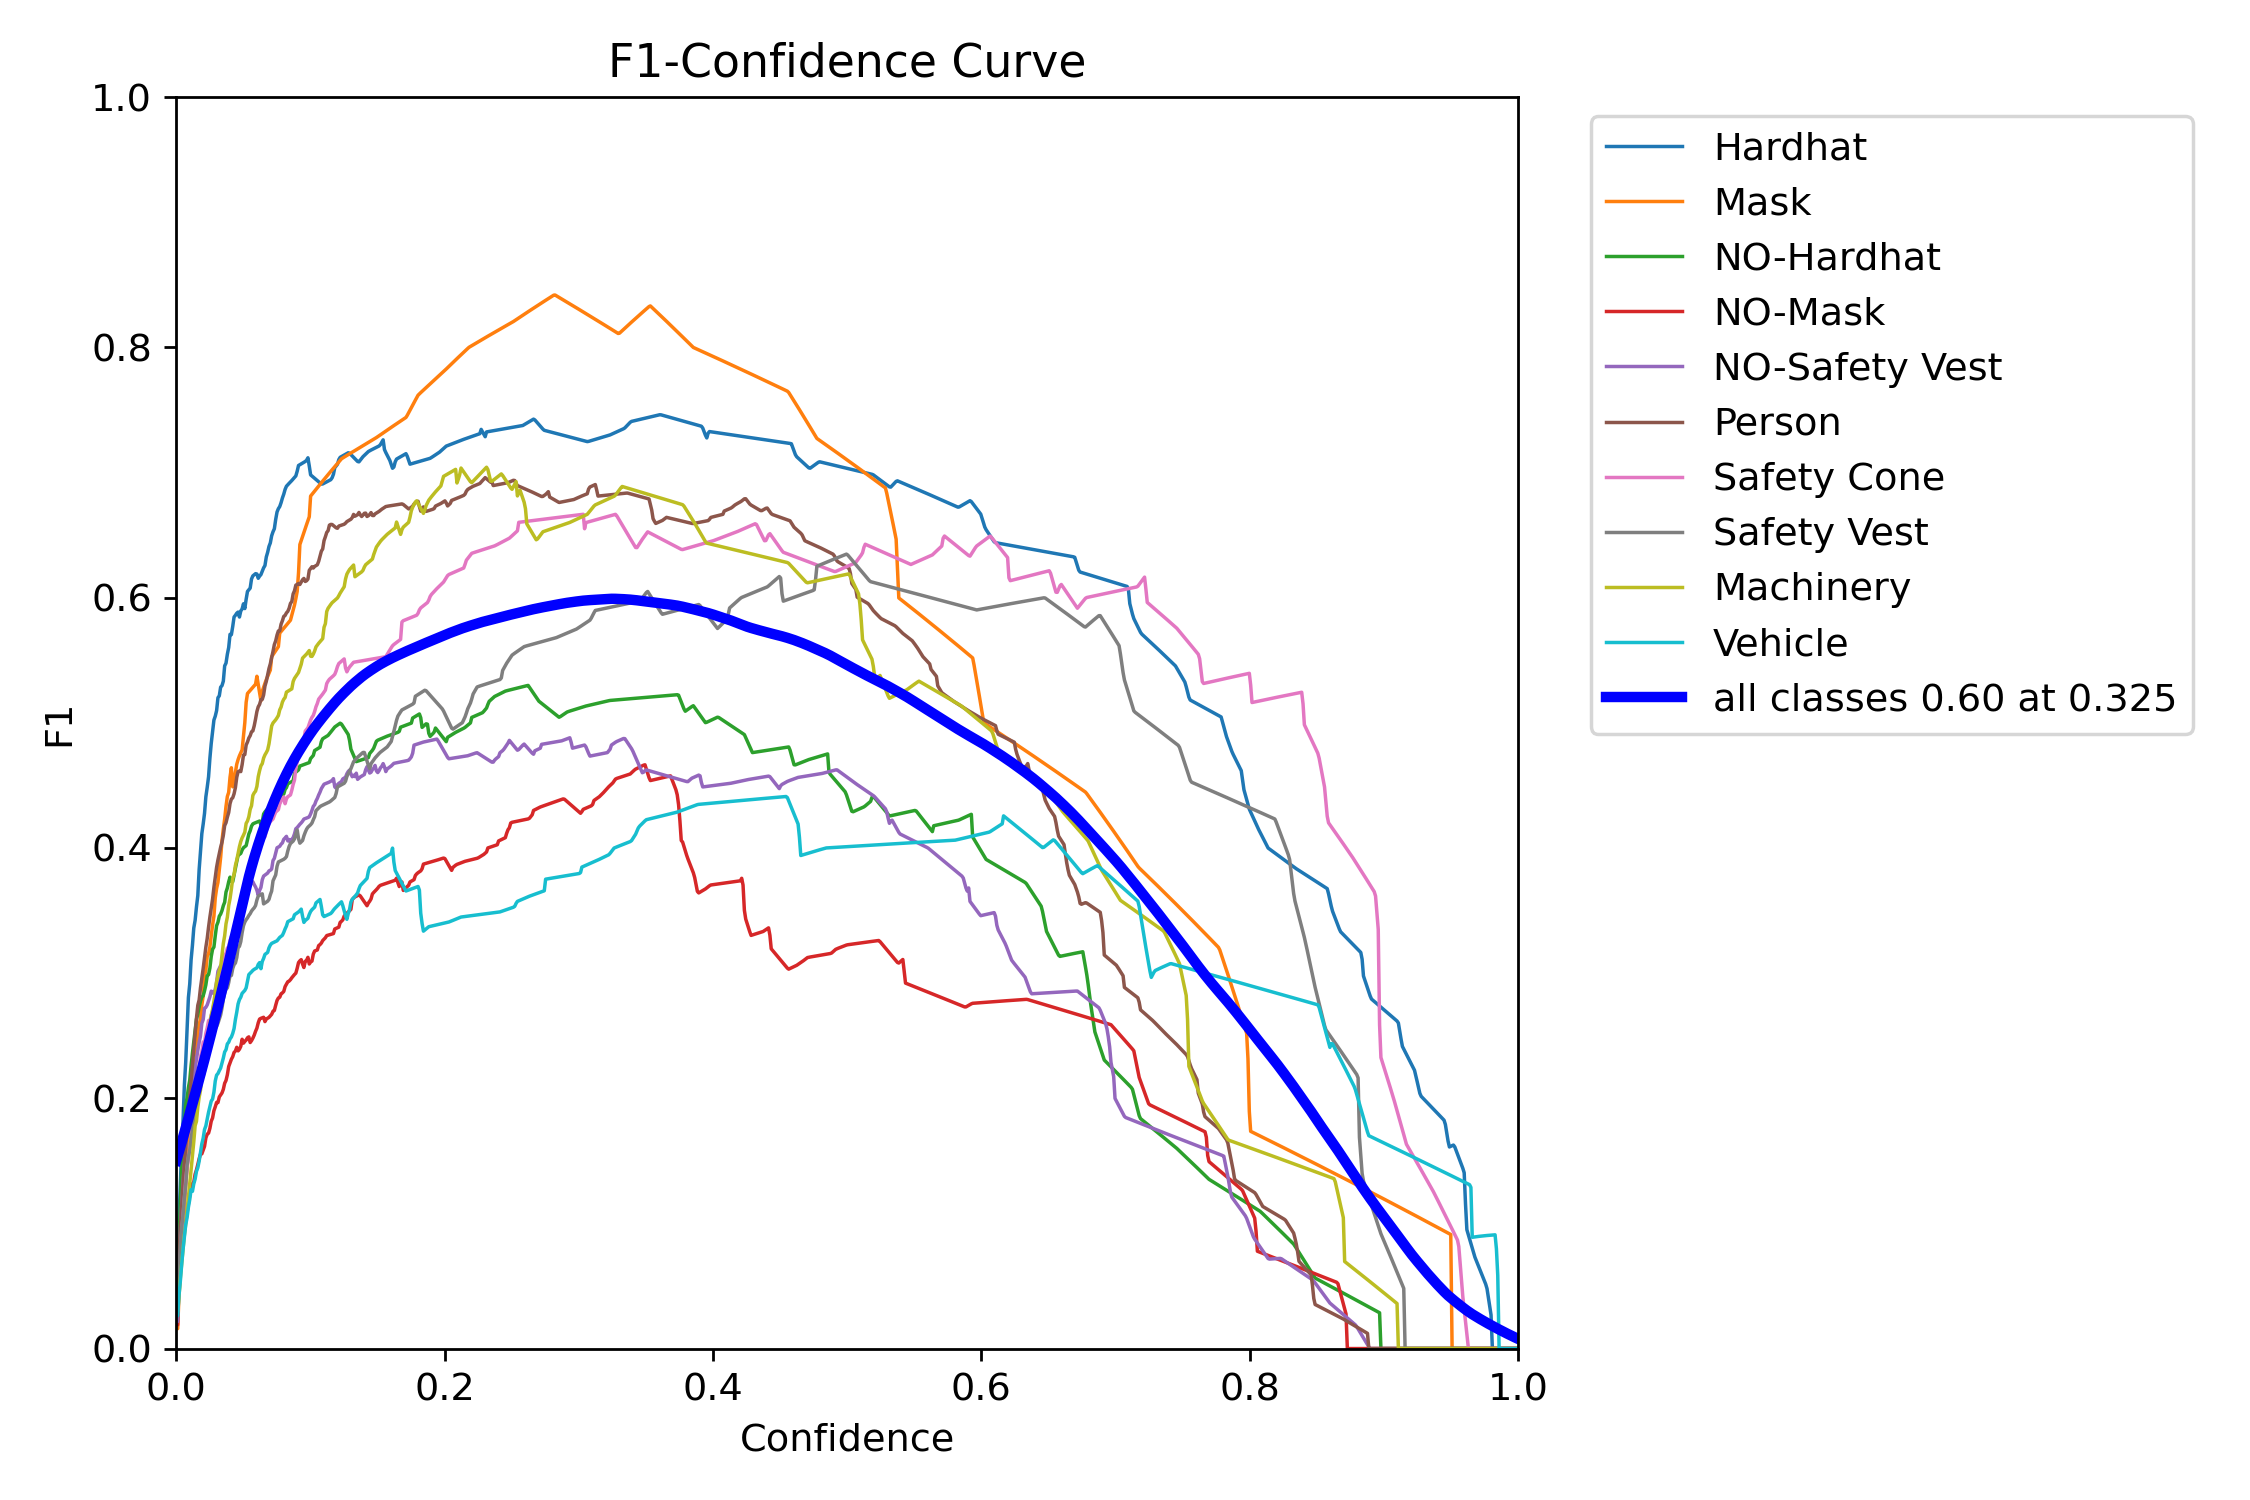

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val2/confusion_matrix.png


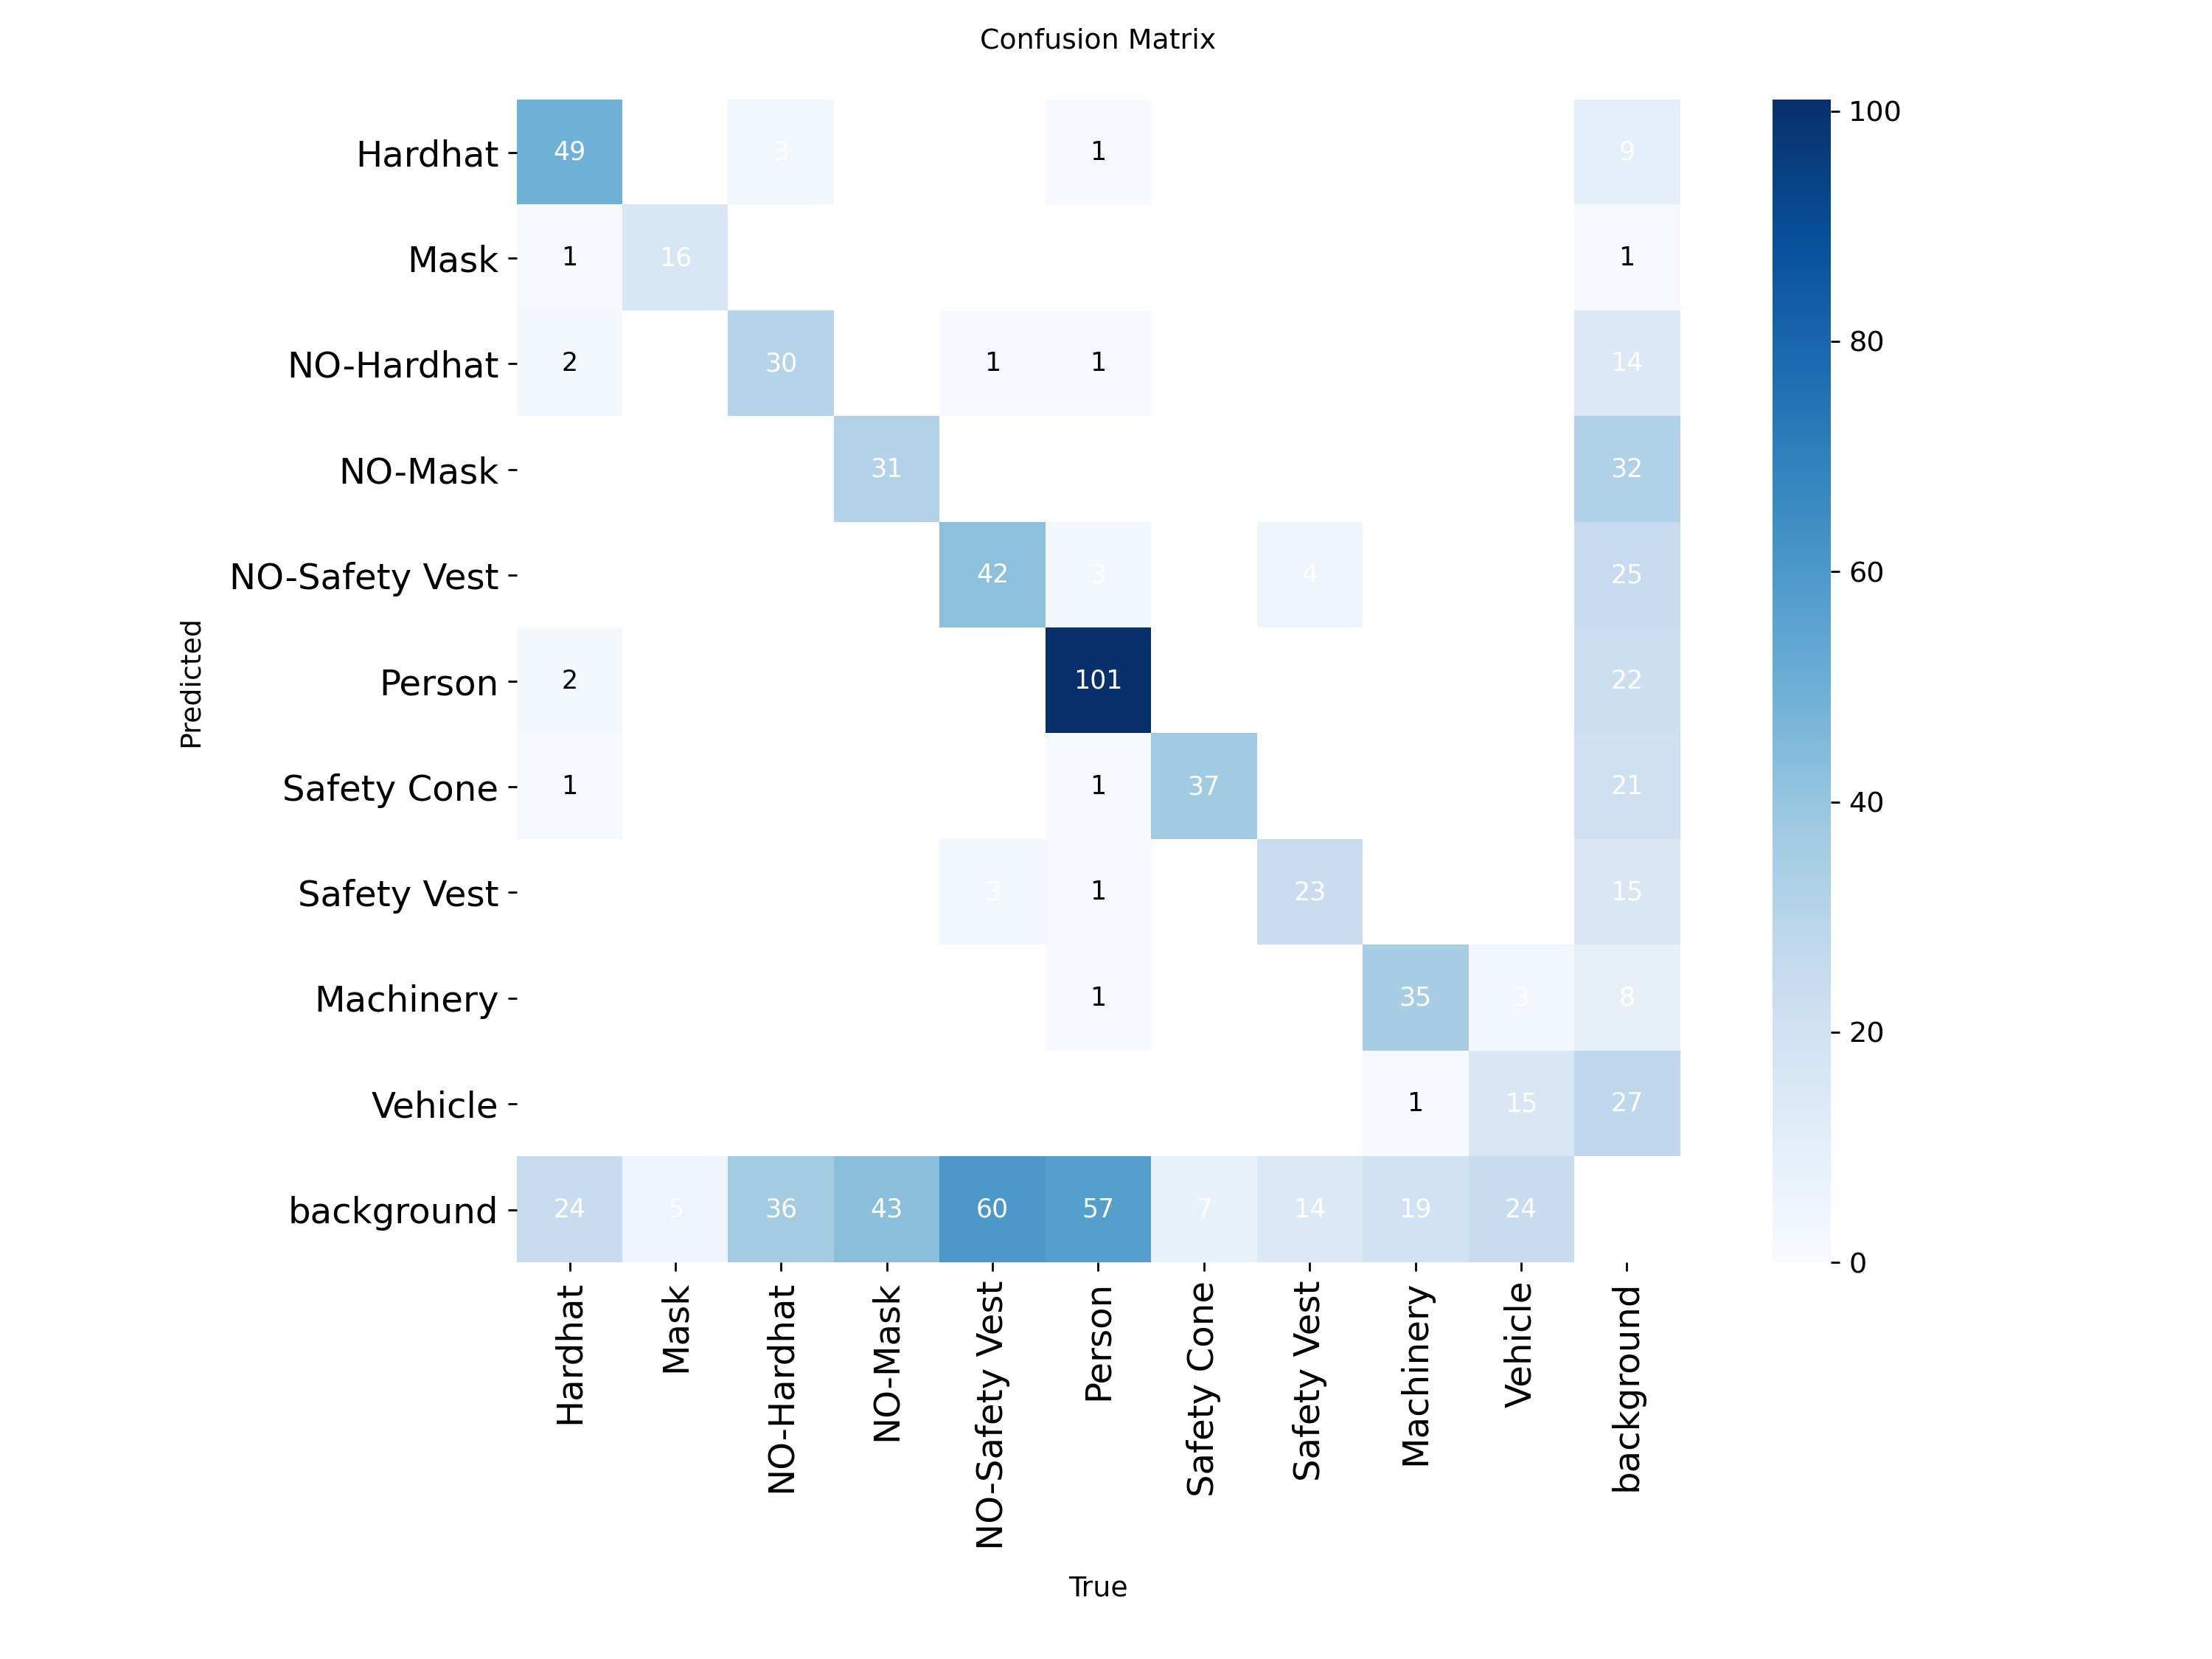

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val2/R_curve.png


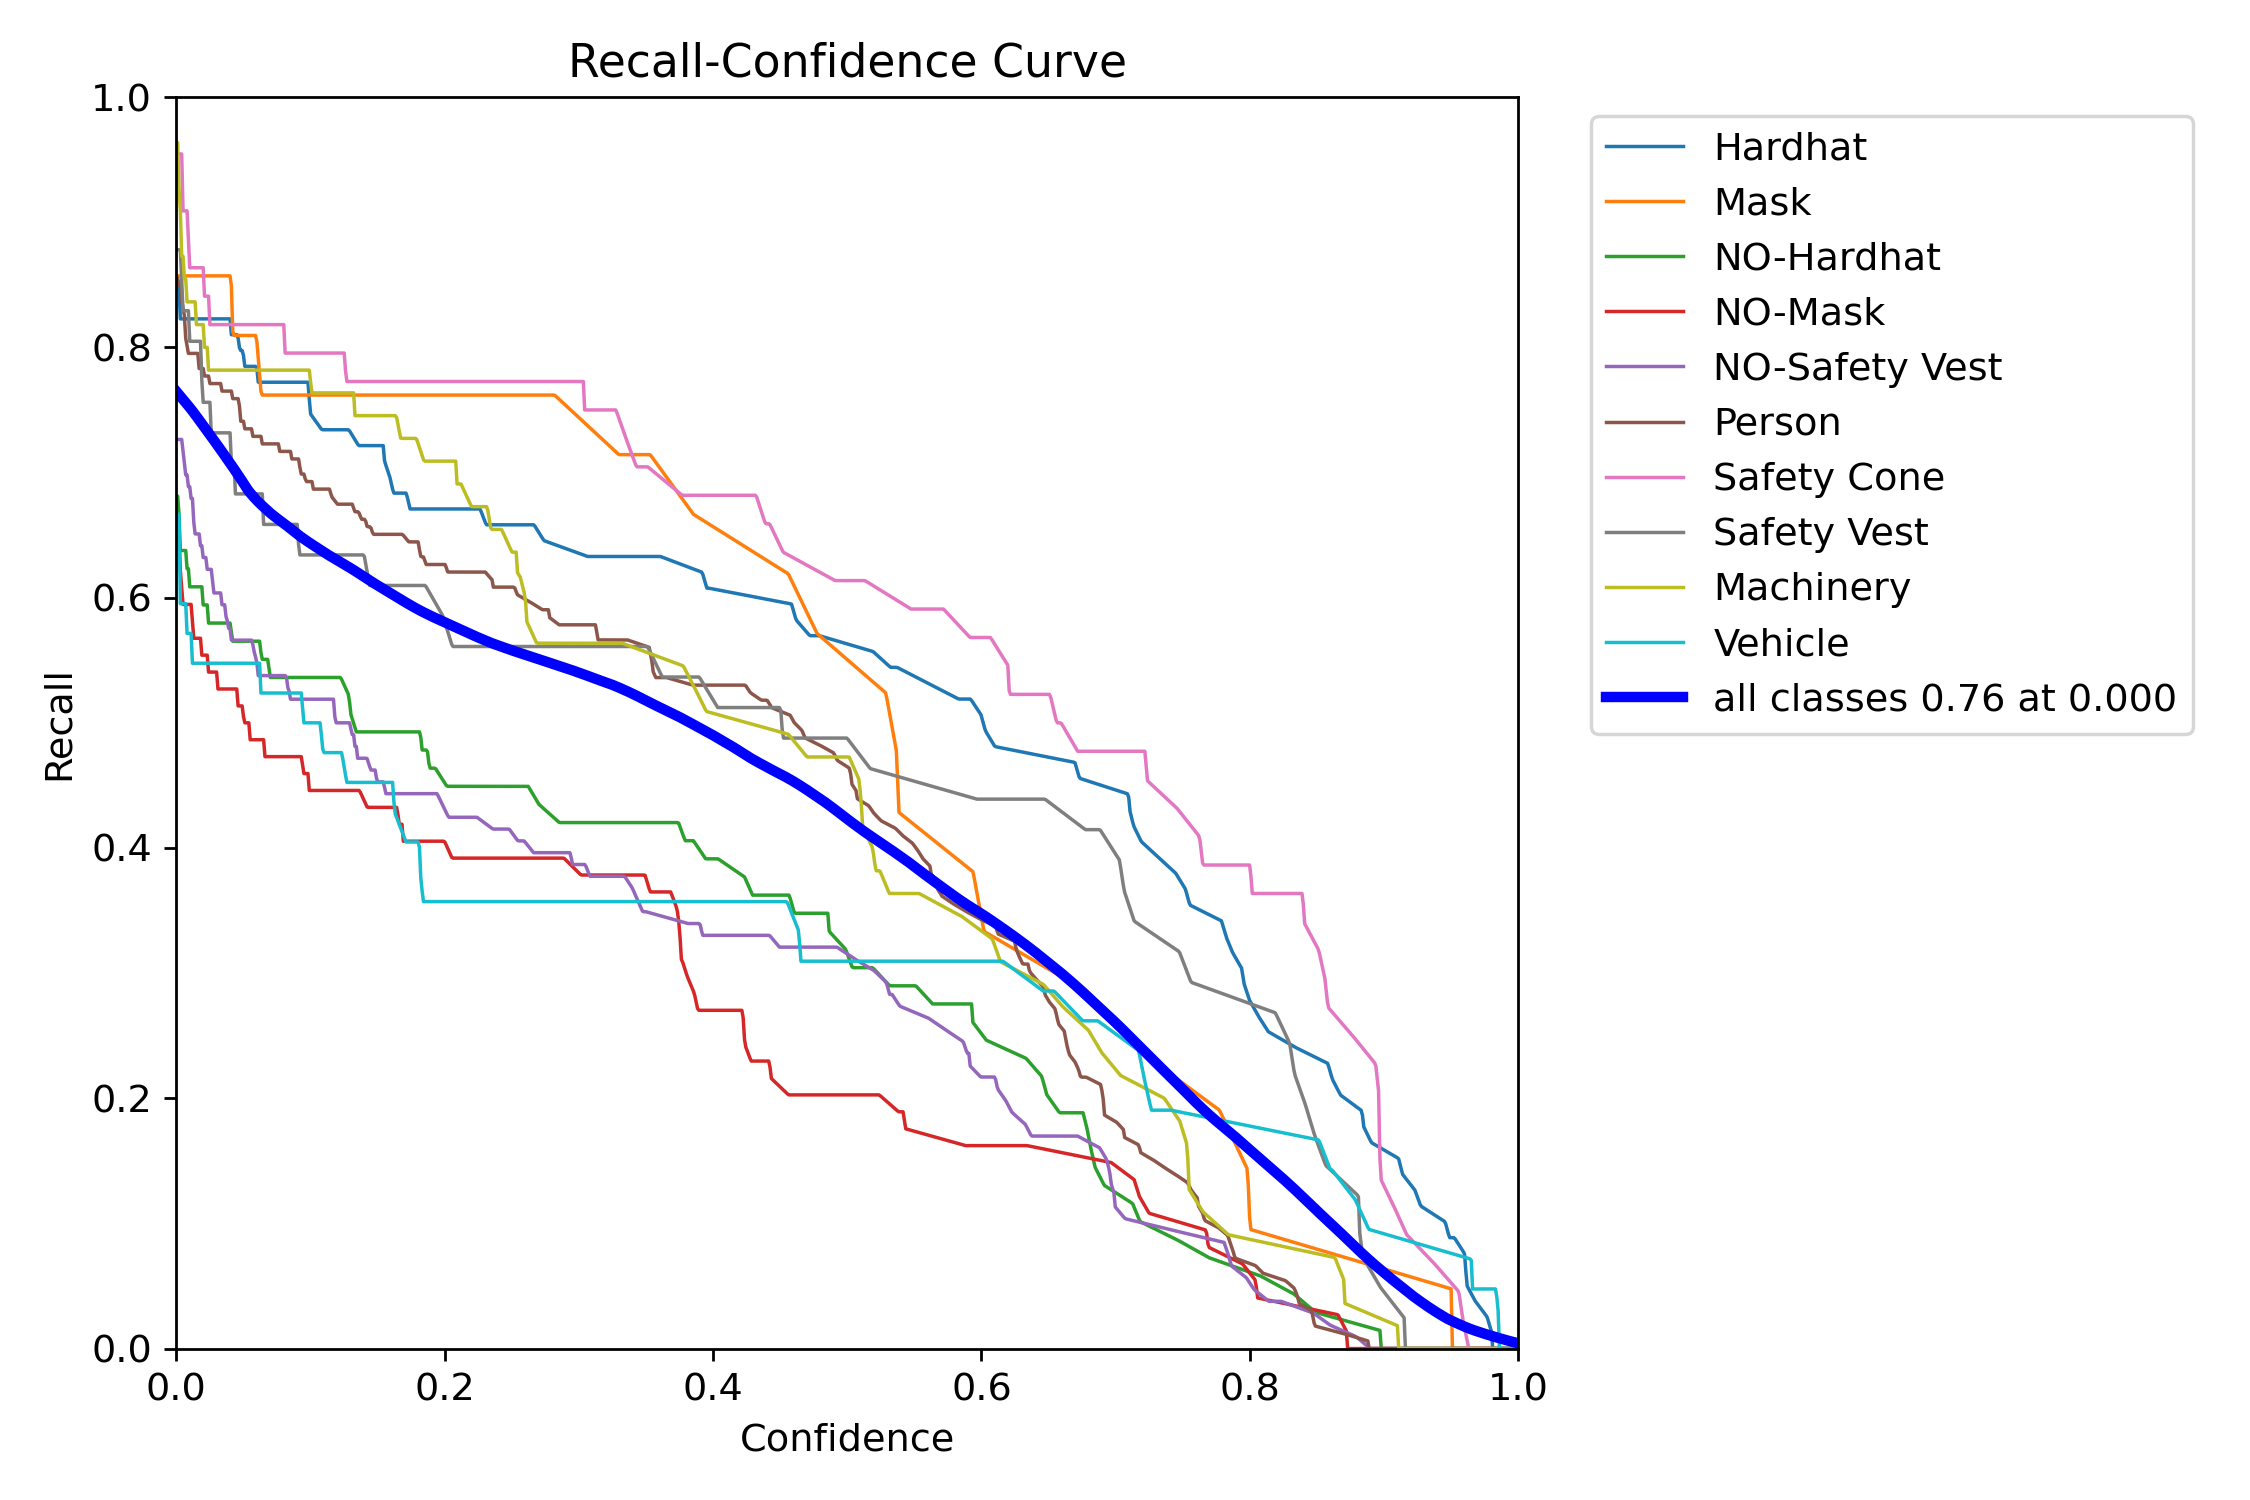

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val2/confusion_matrix_normalized.png


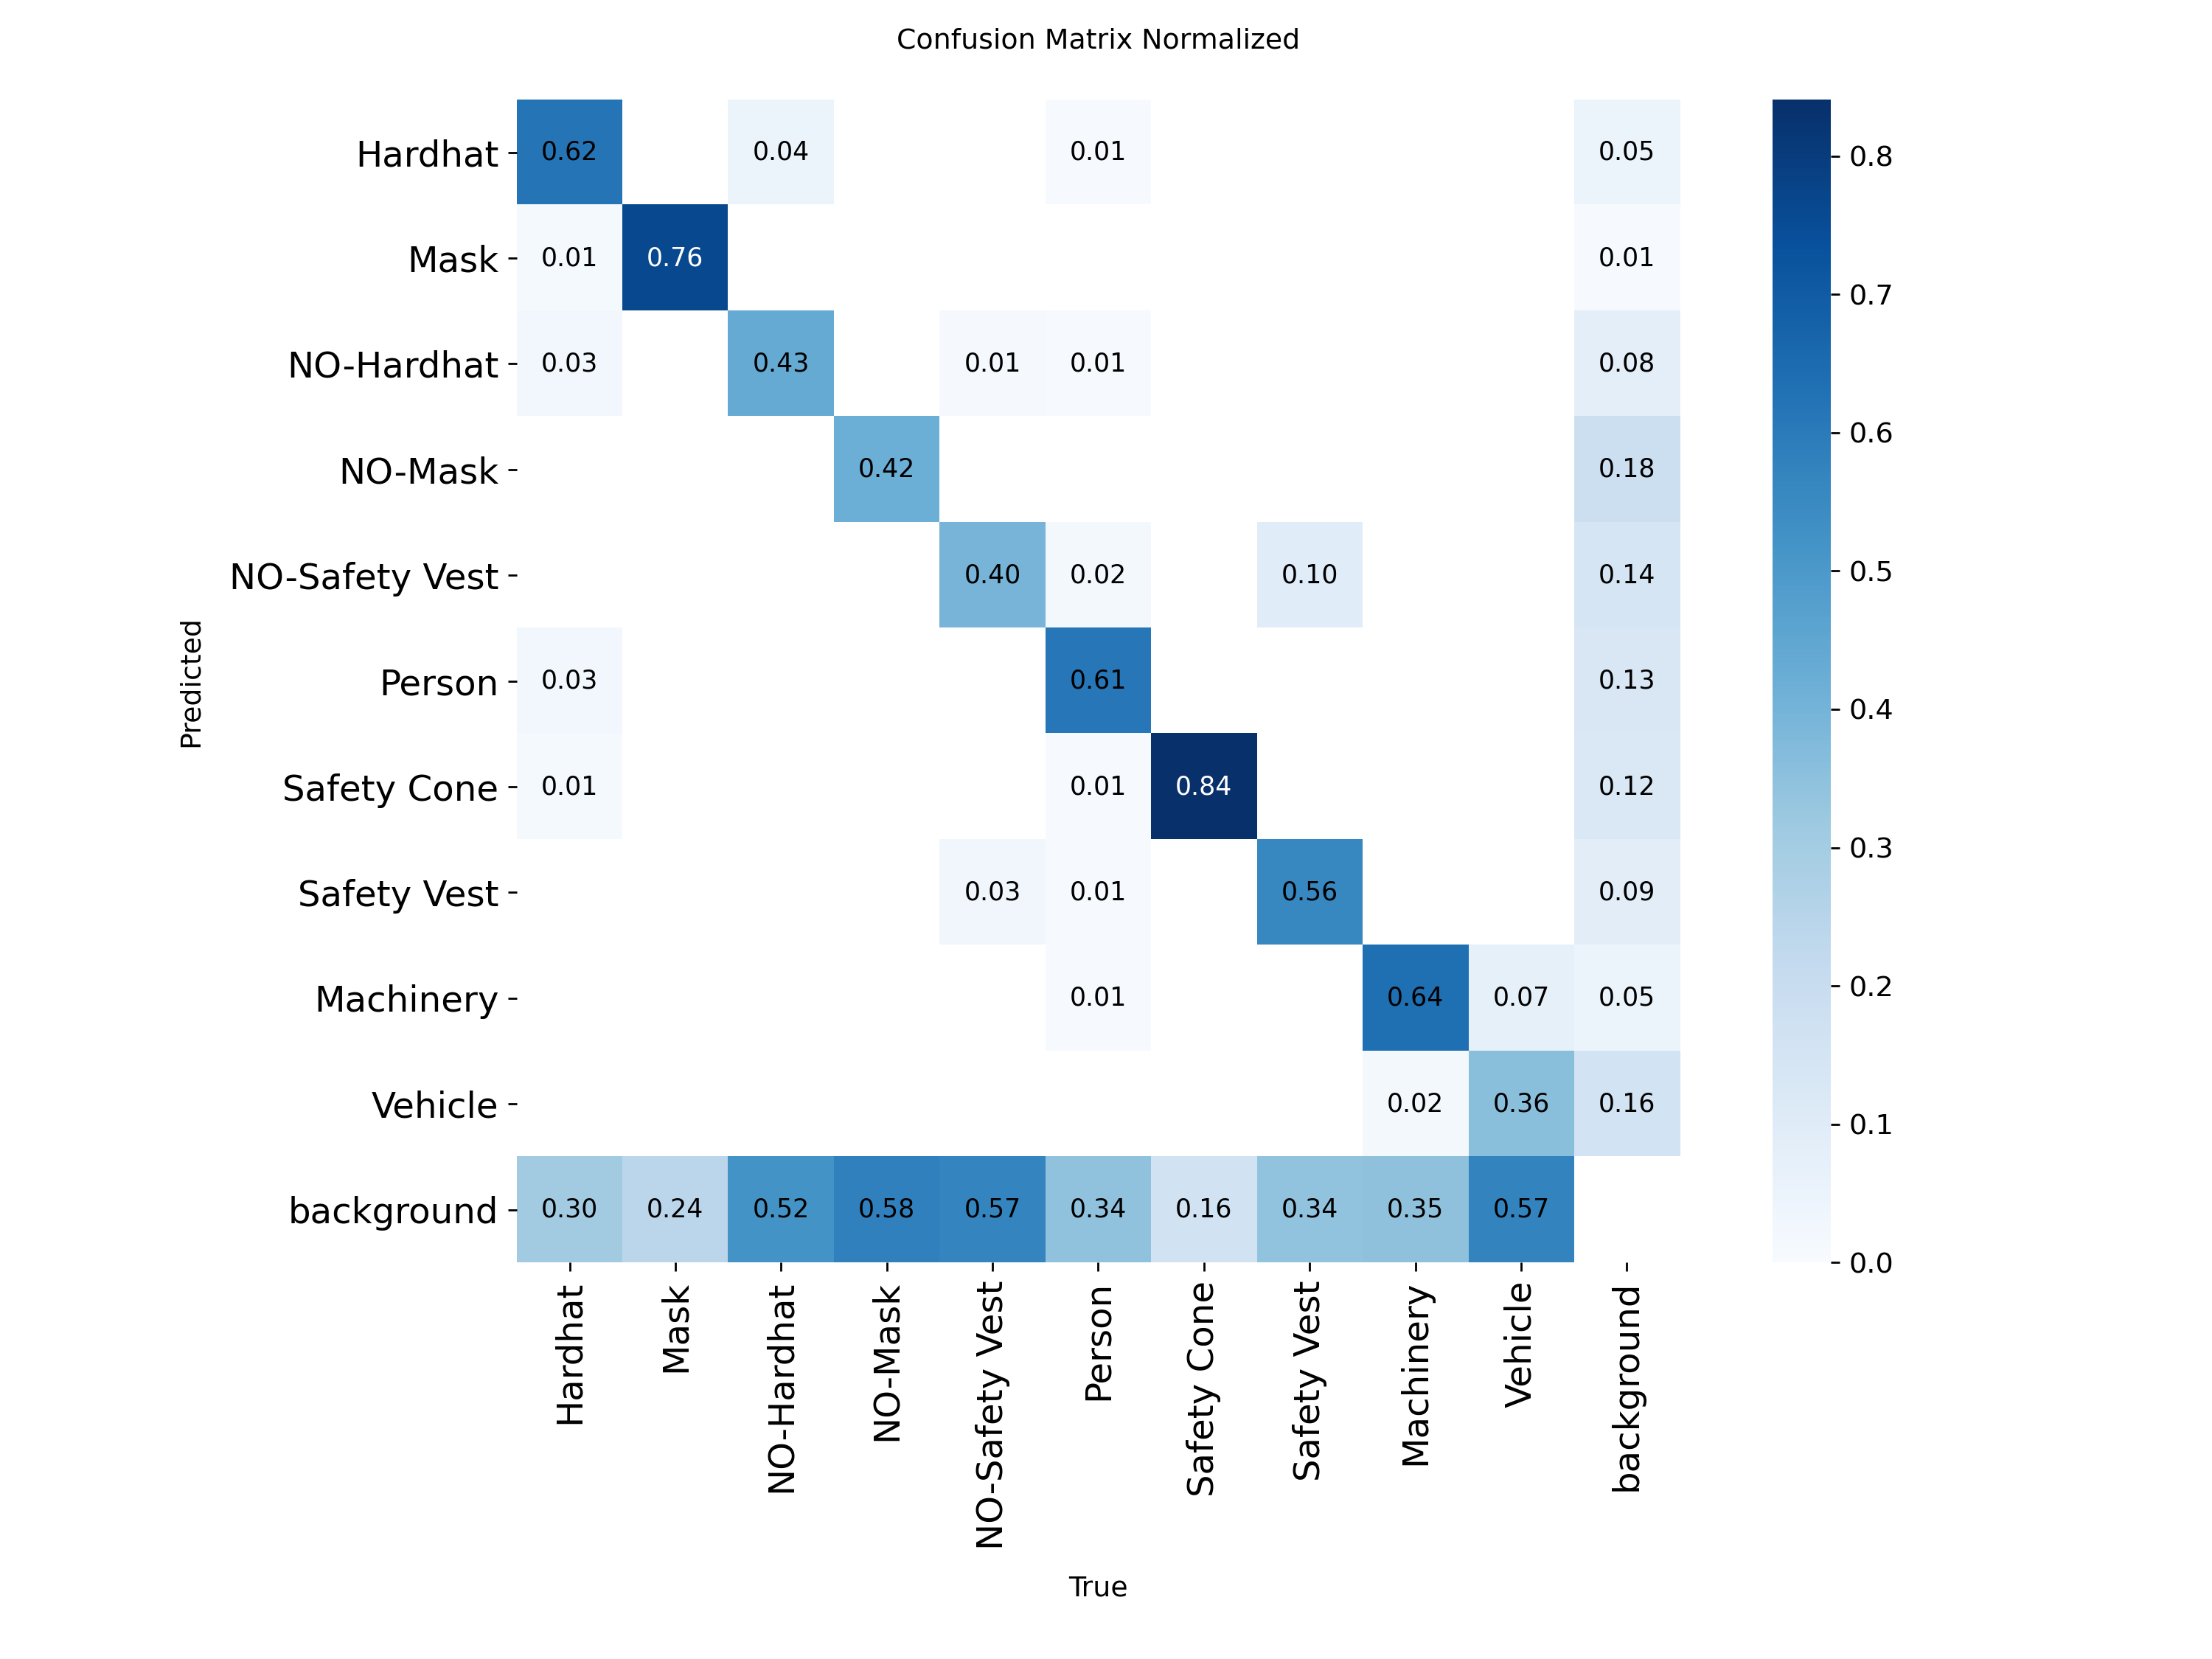

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val2/PR_curve.png


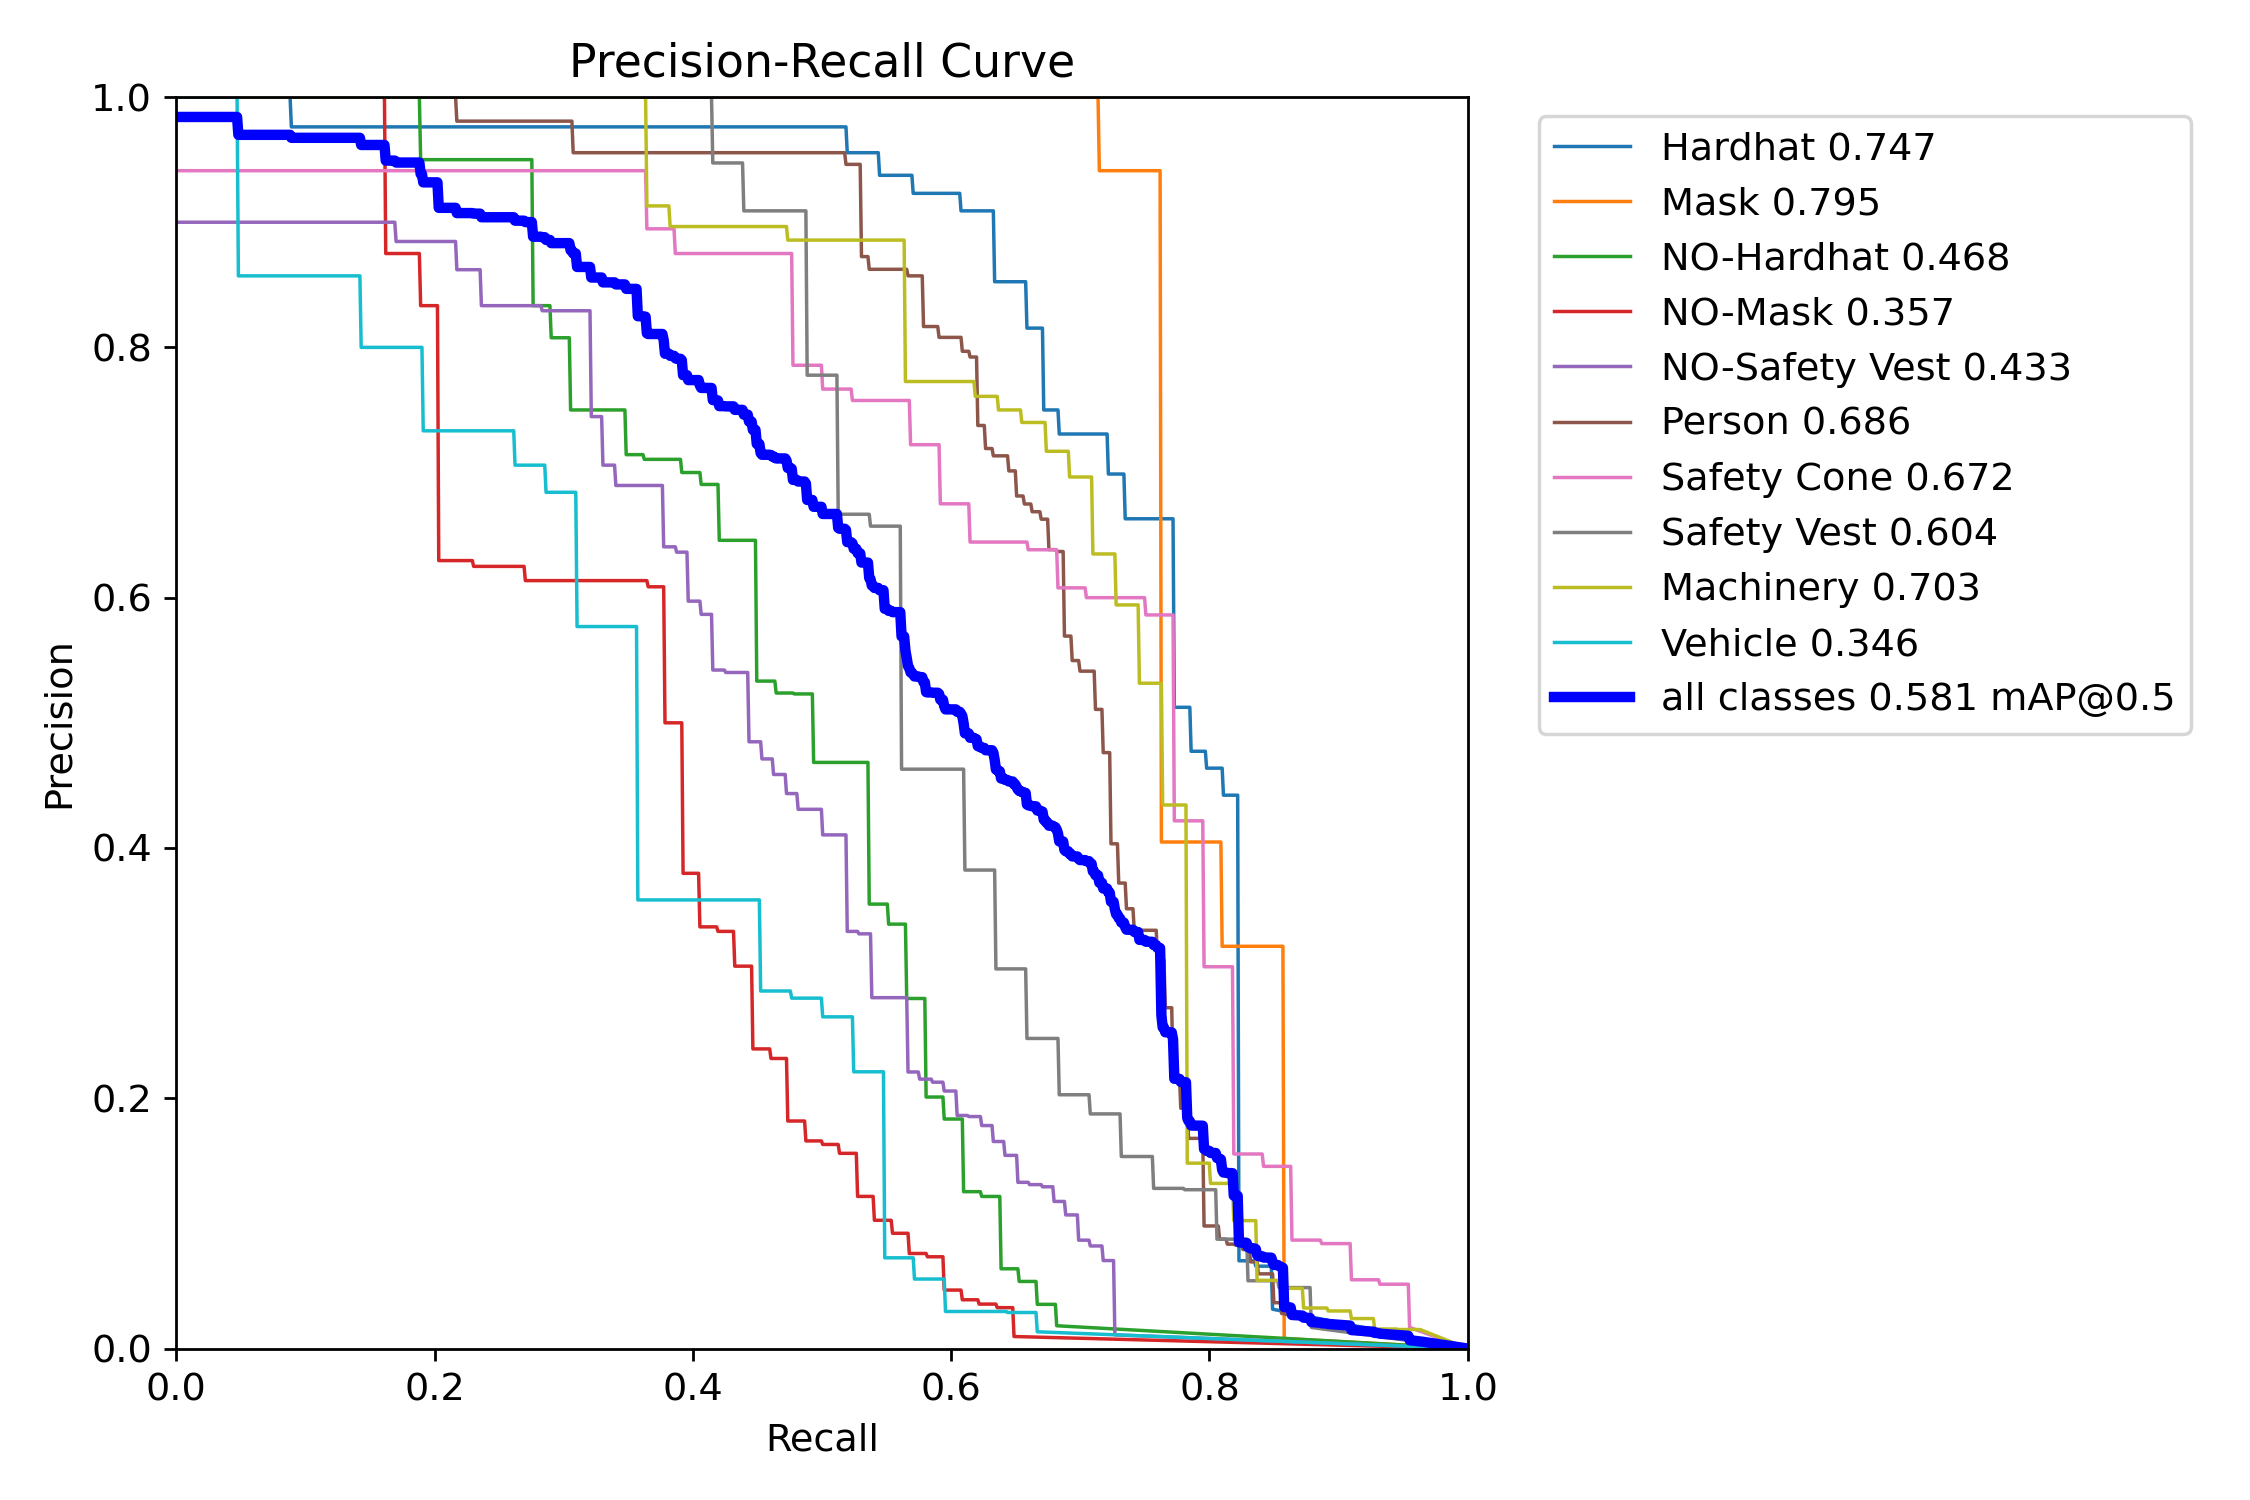

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val2/P_curve.png


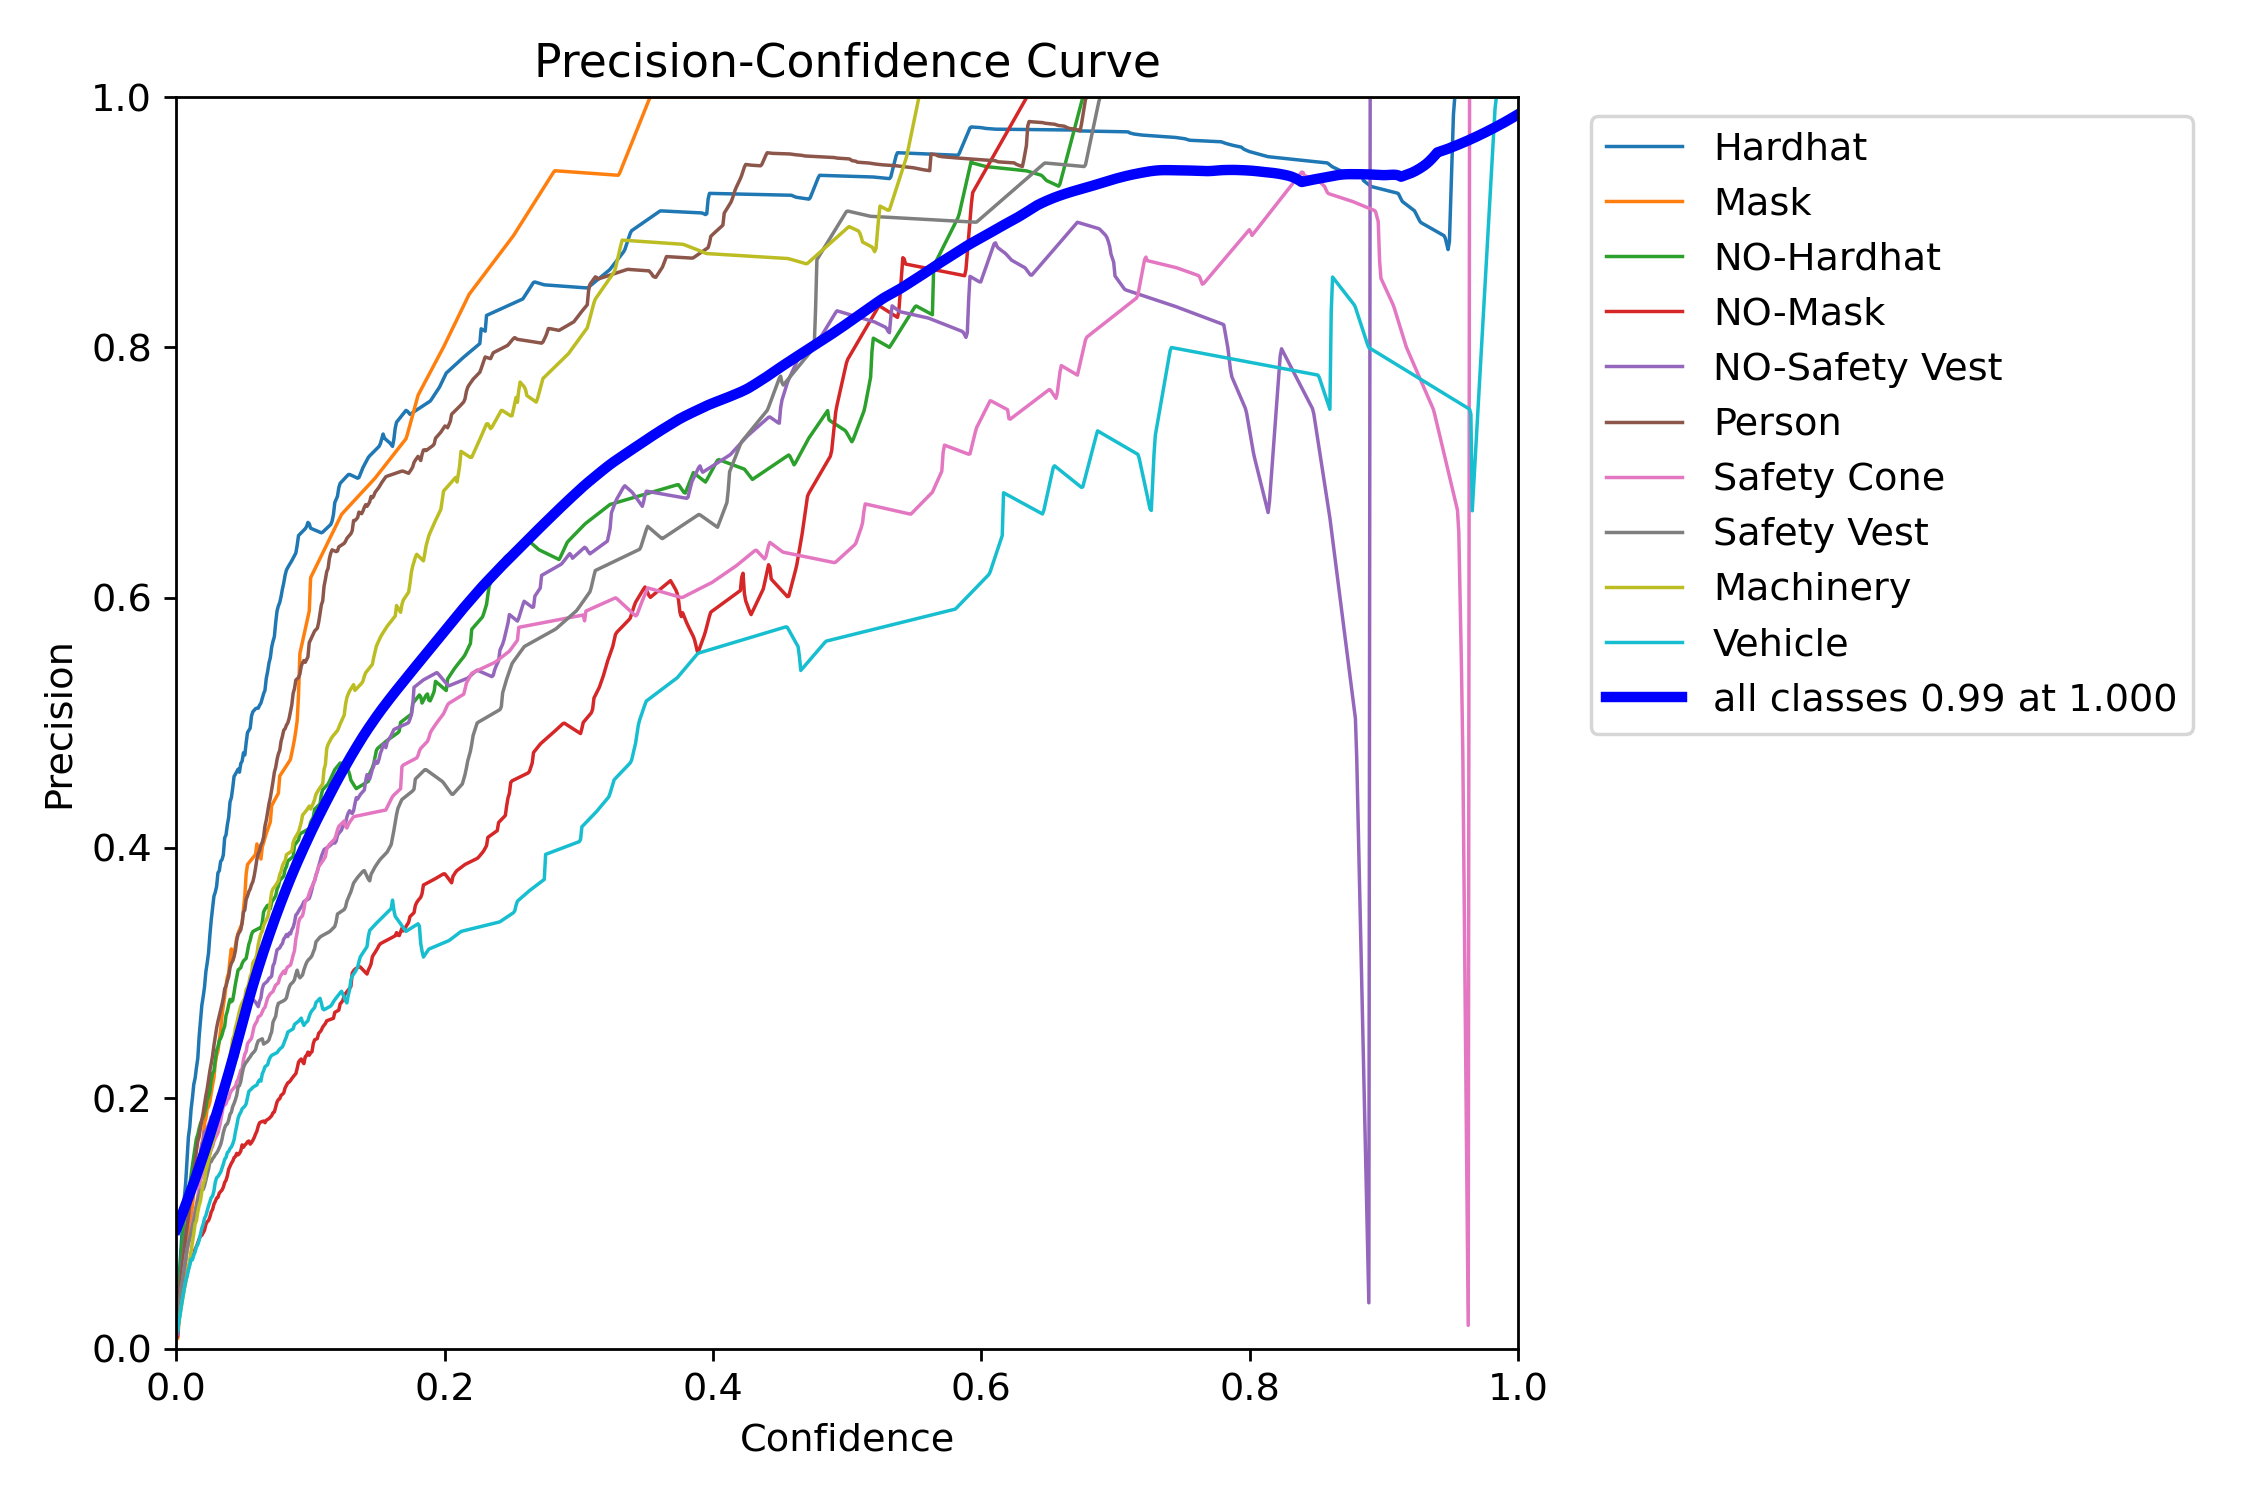


📁 Dossier 'val' contient 6 PNG :
   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val/F1_curve.png


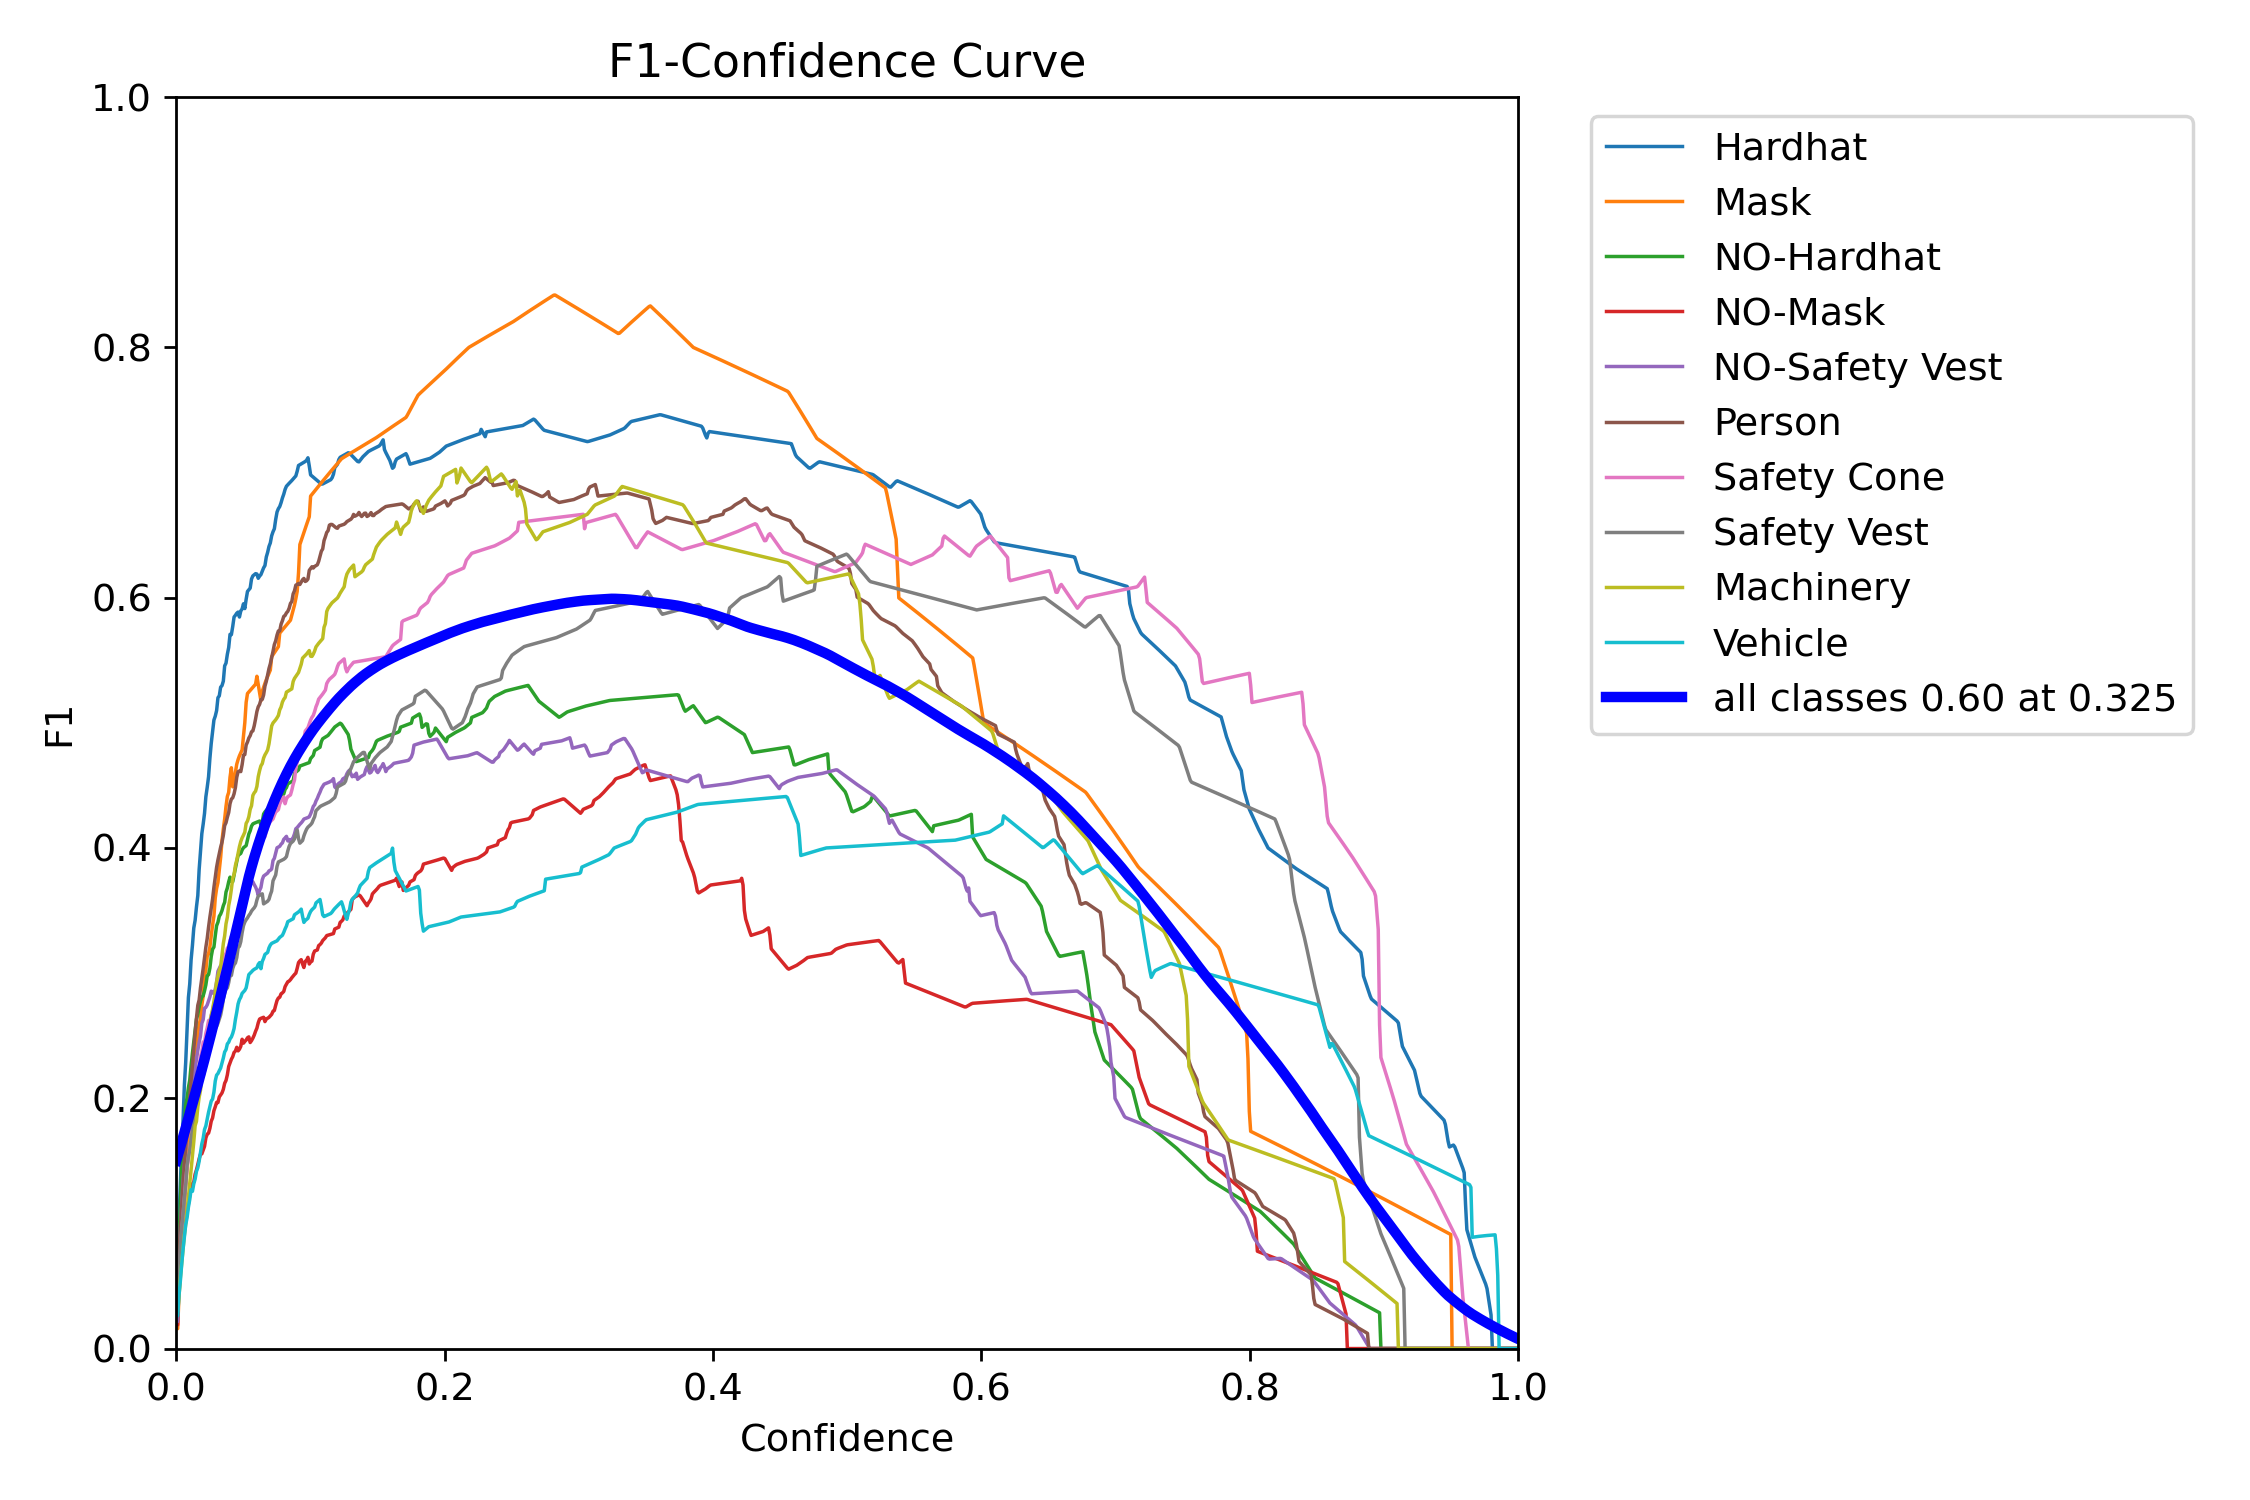

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val/confusion_matrix.png


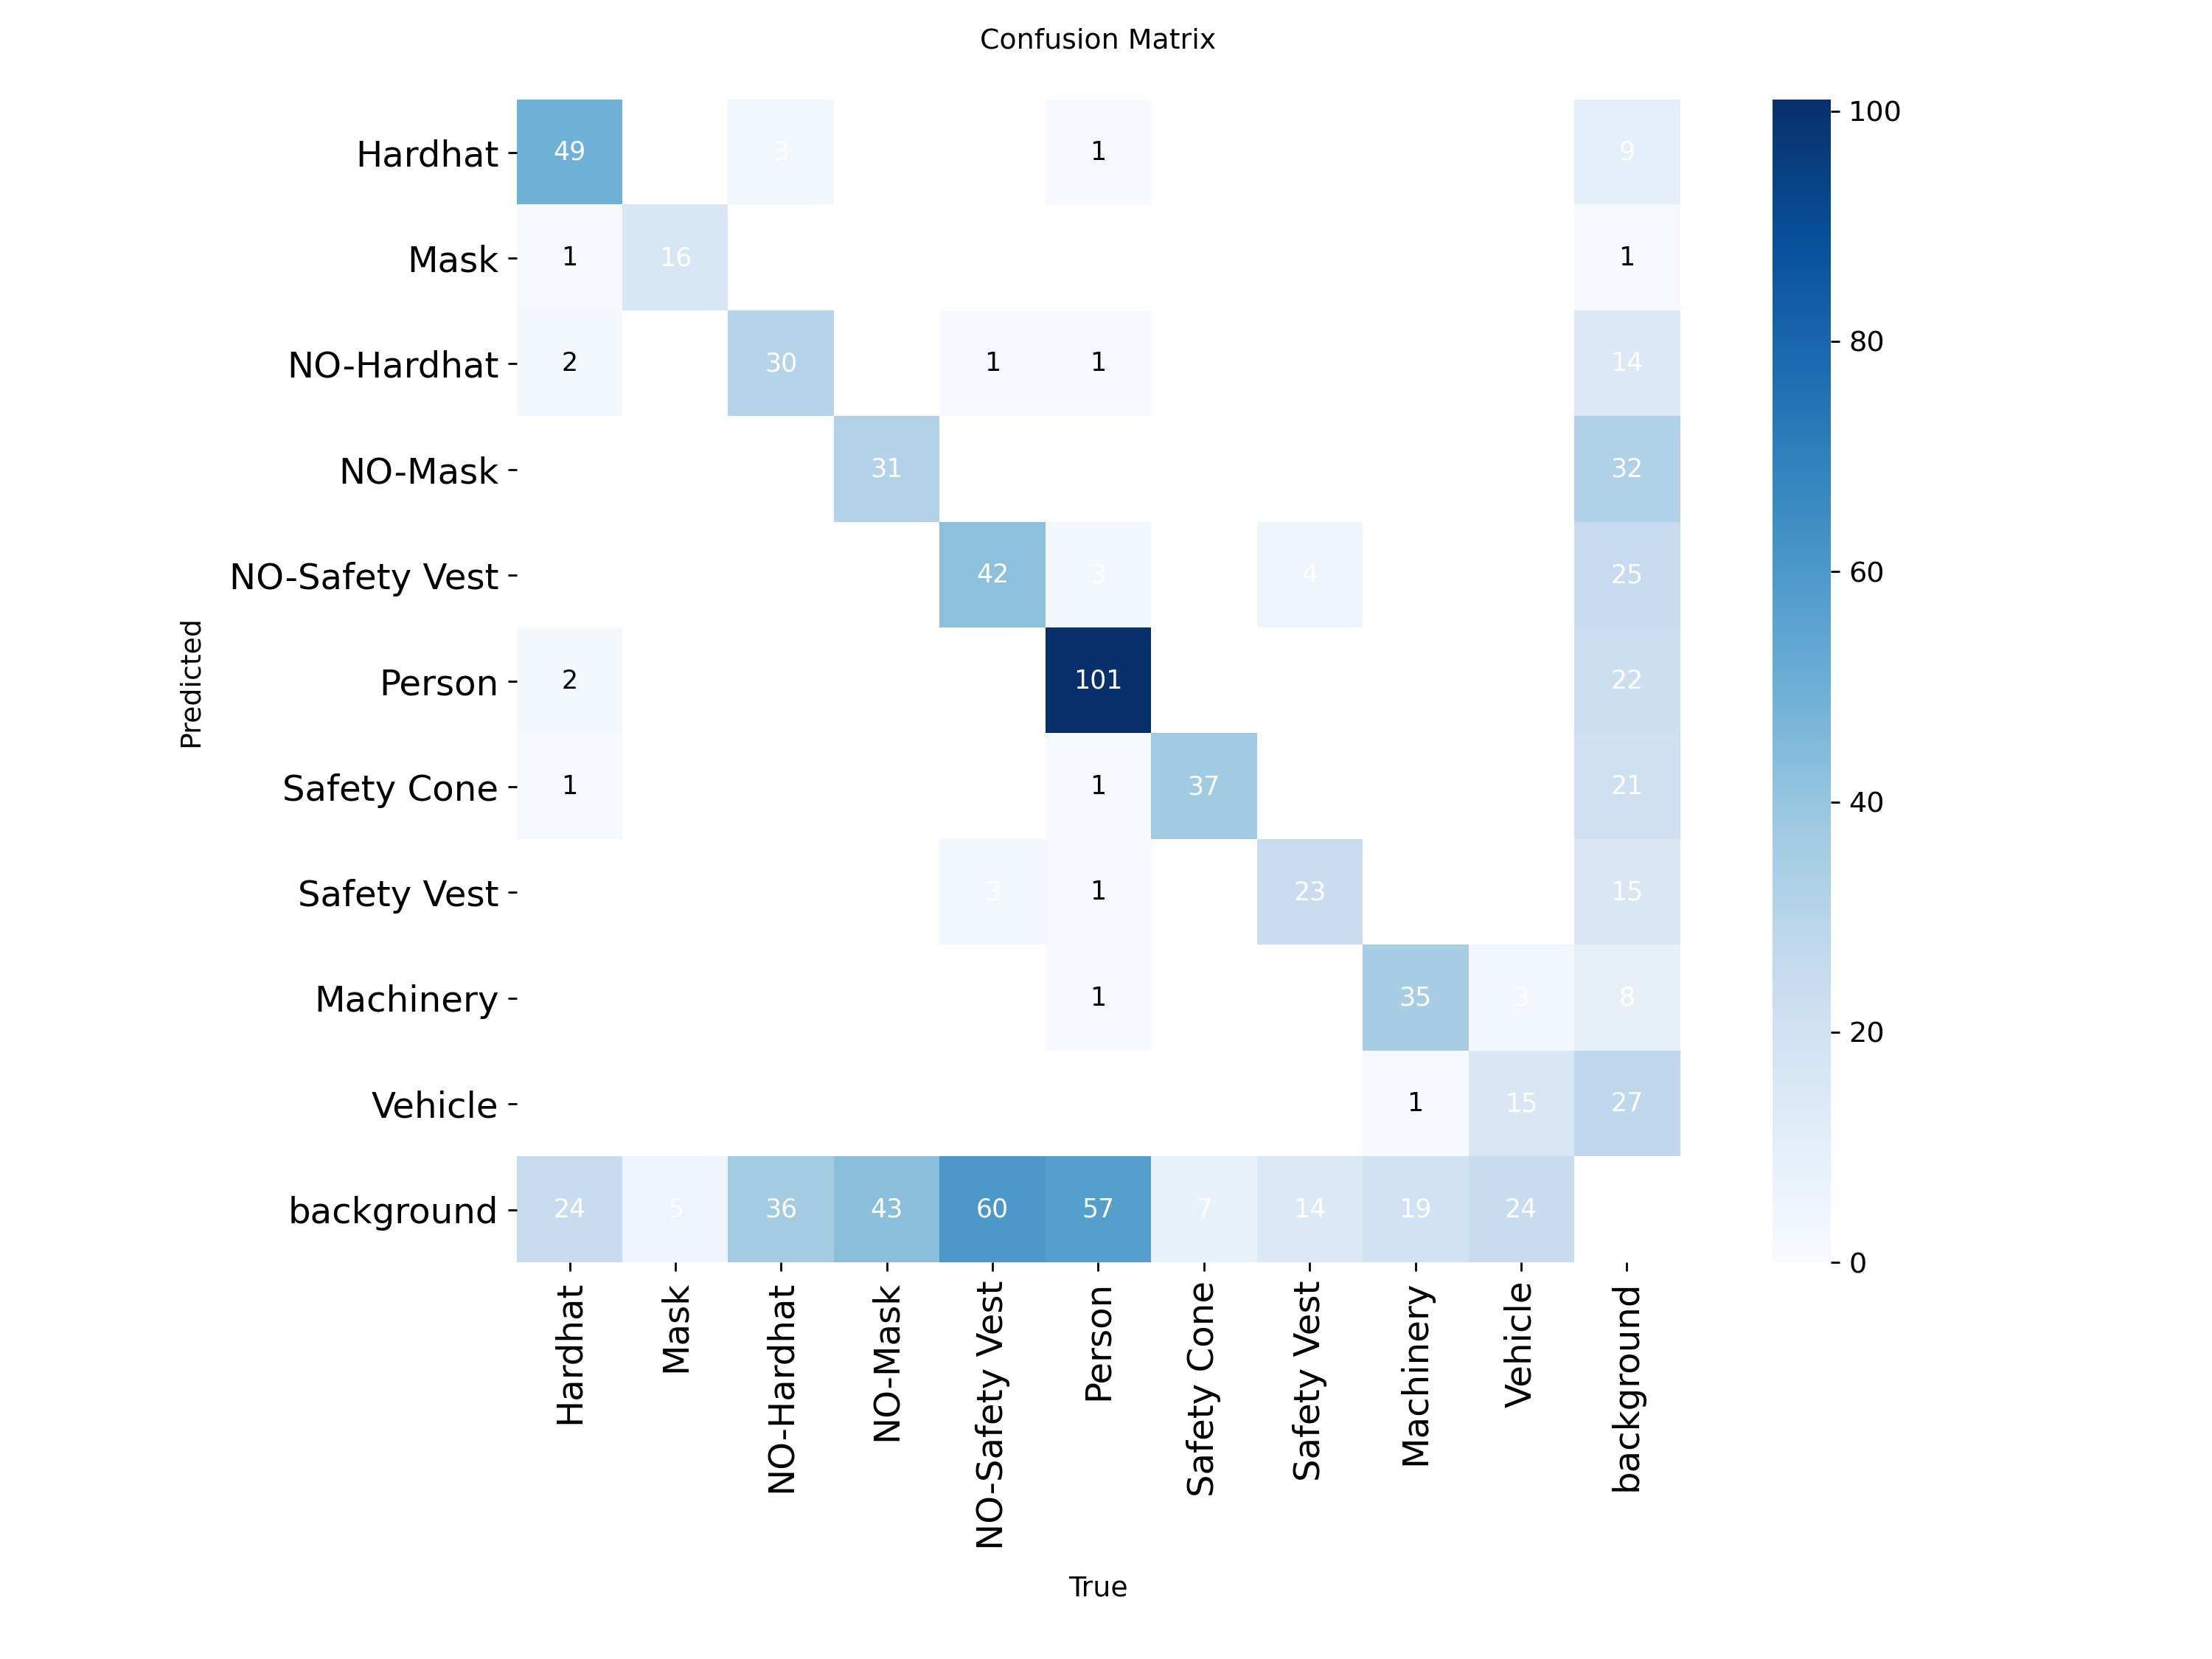

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val/R_curve.png


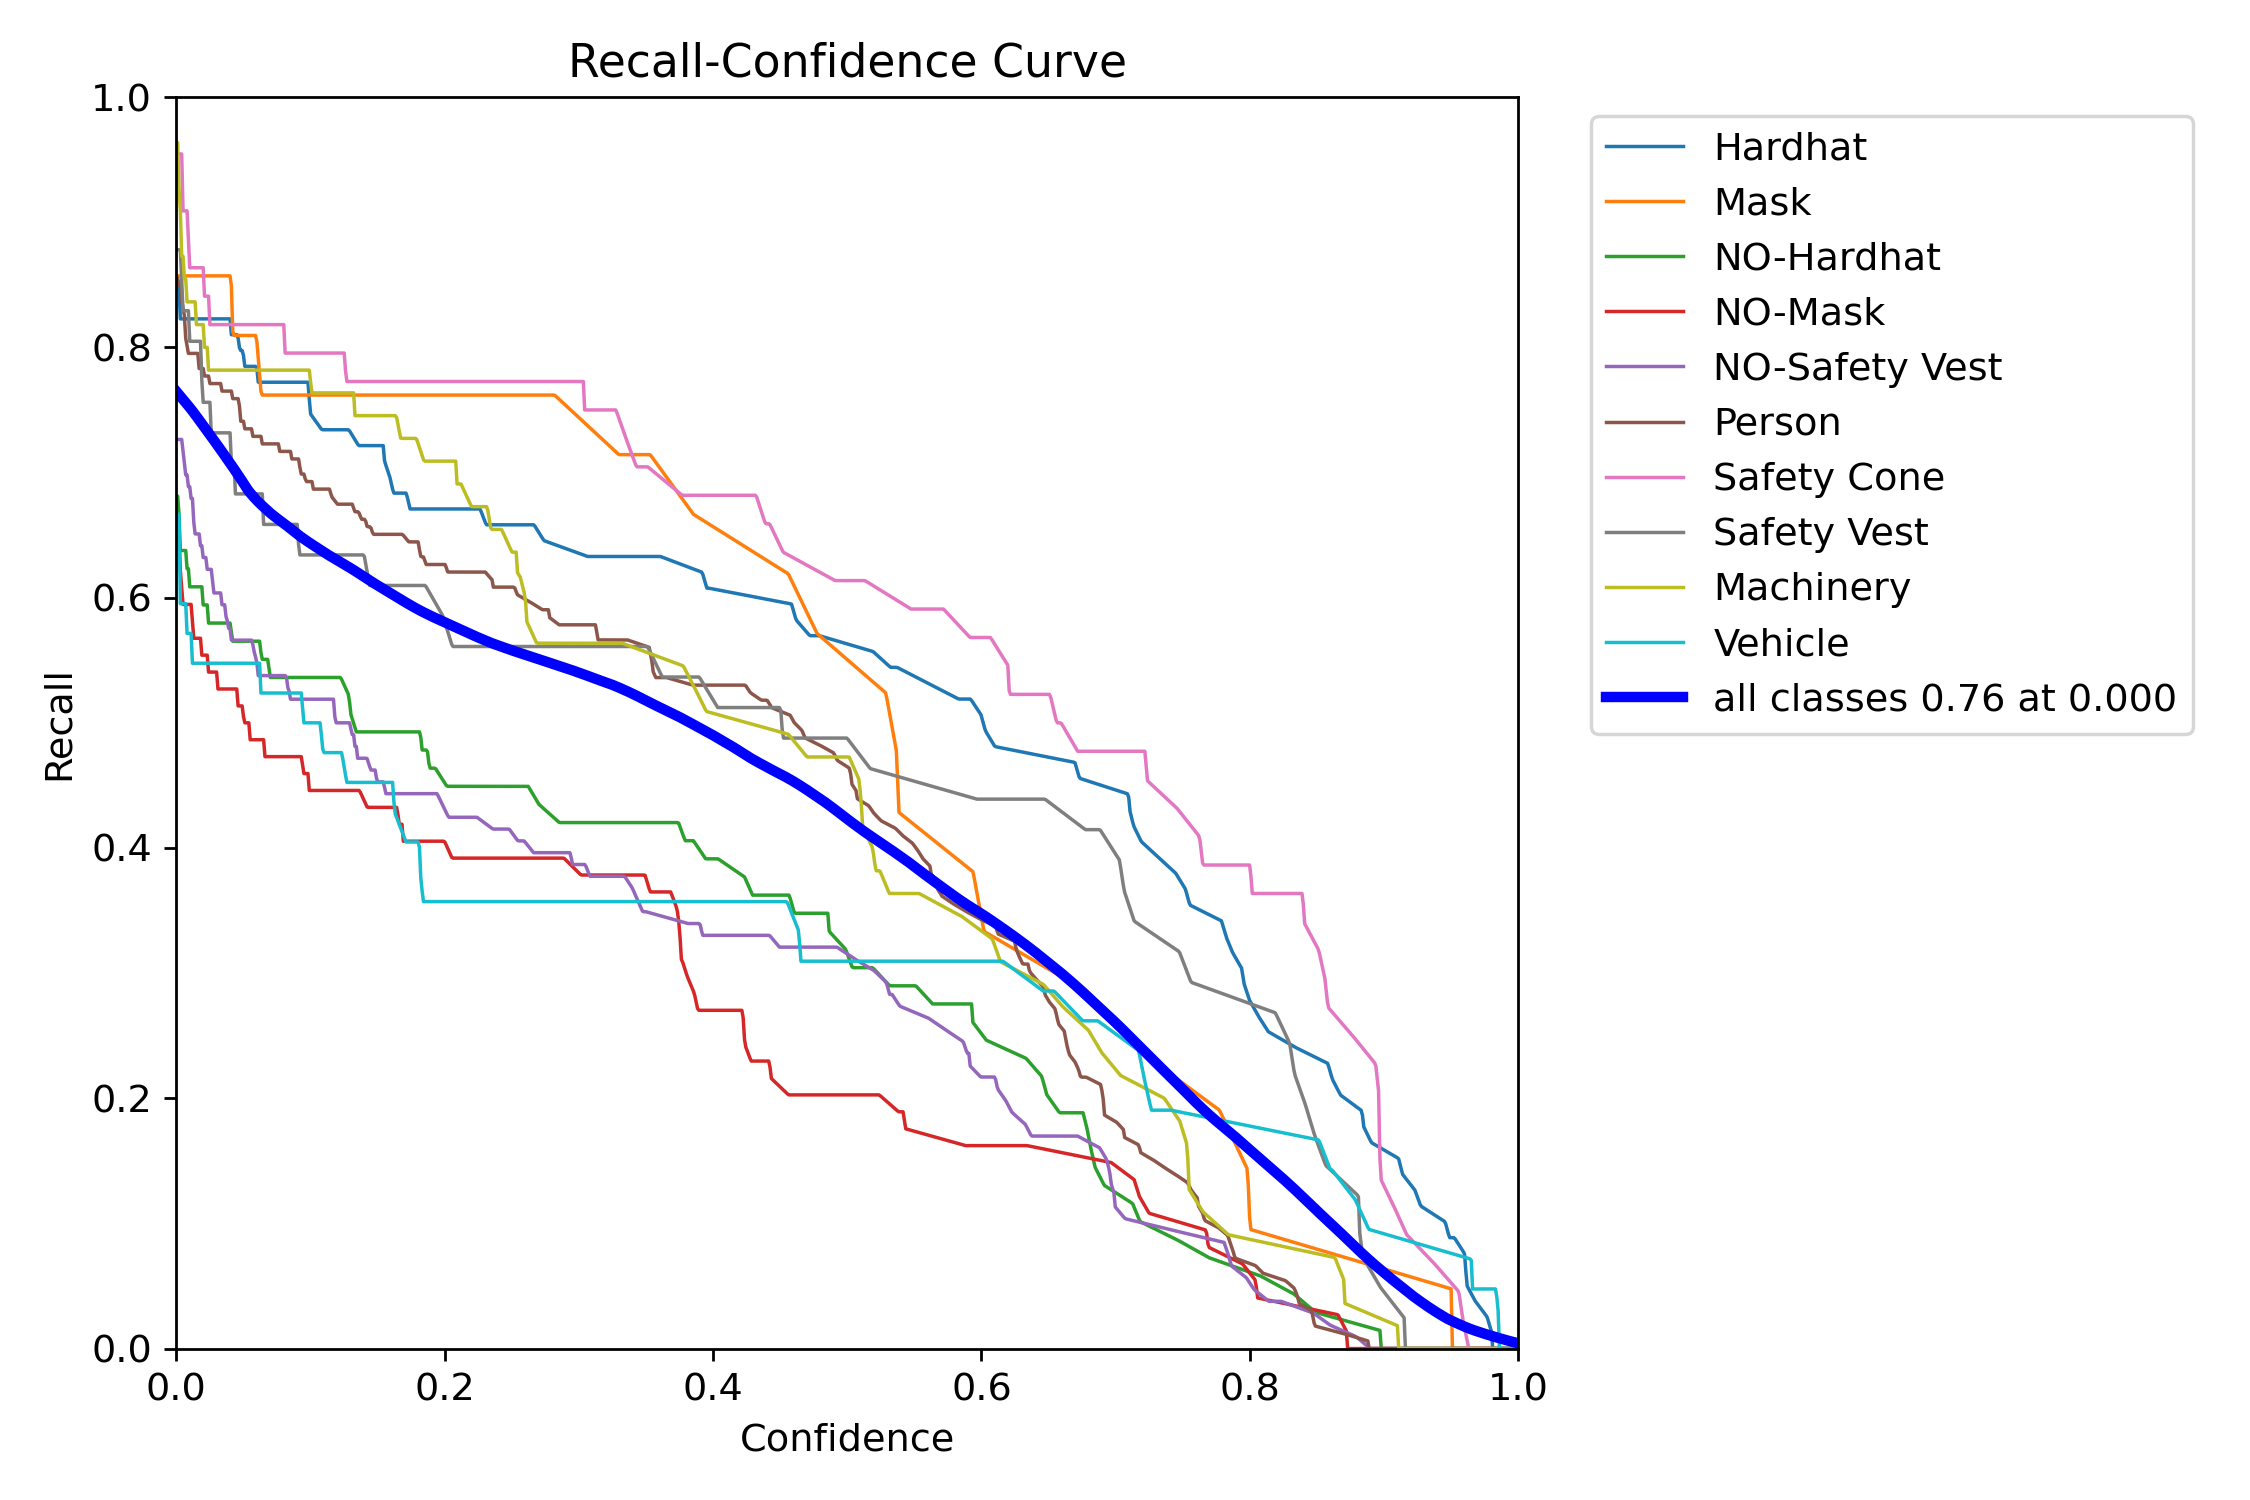

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val/confusion_matrix_normalized.png


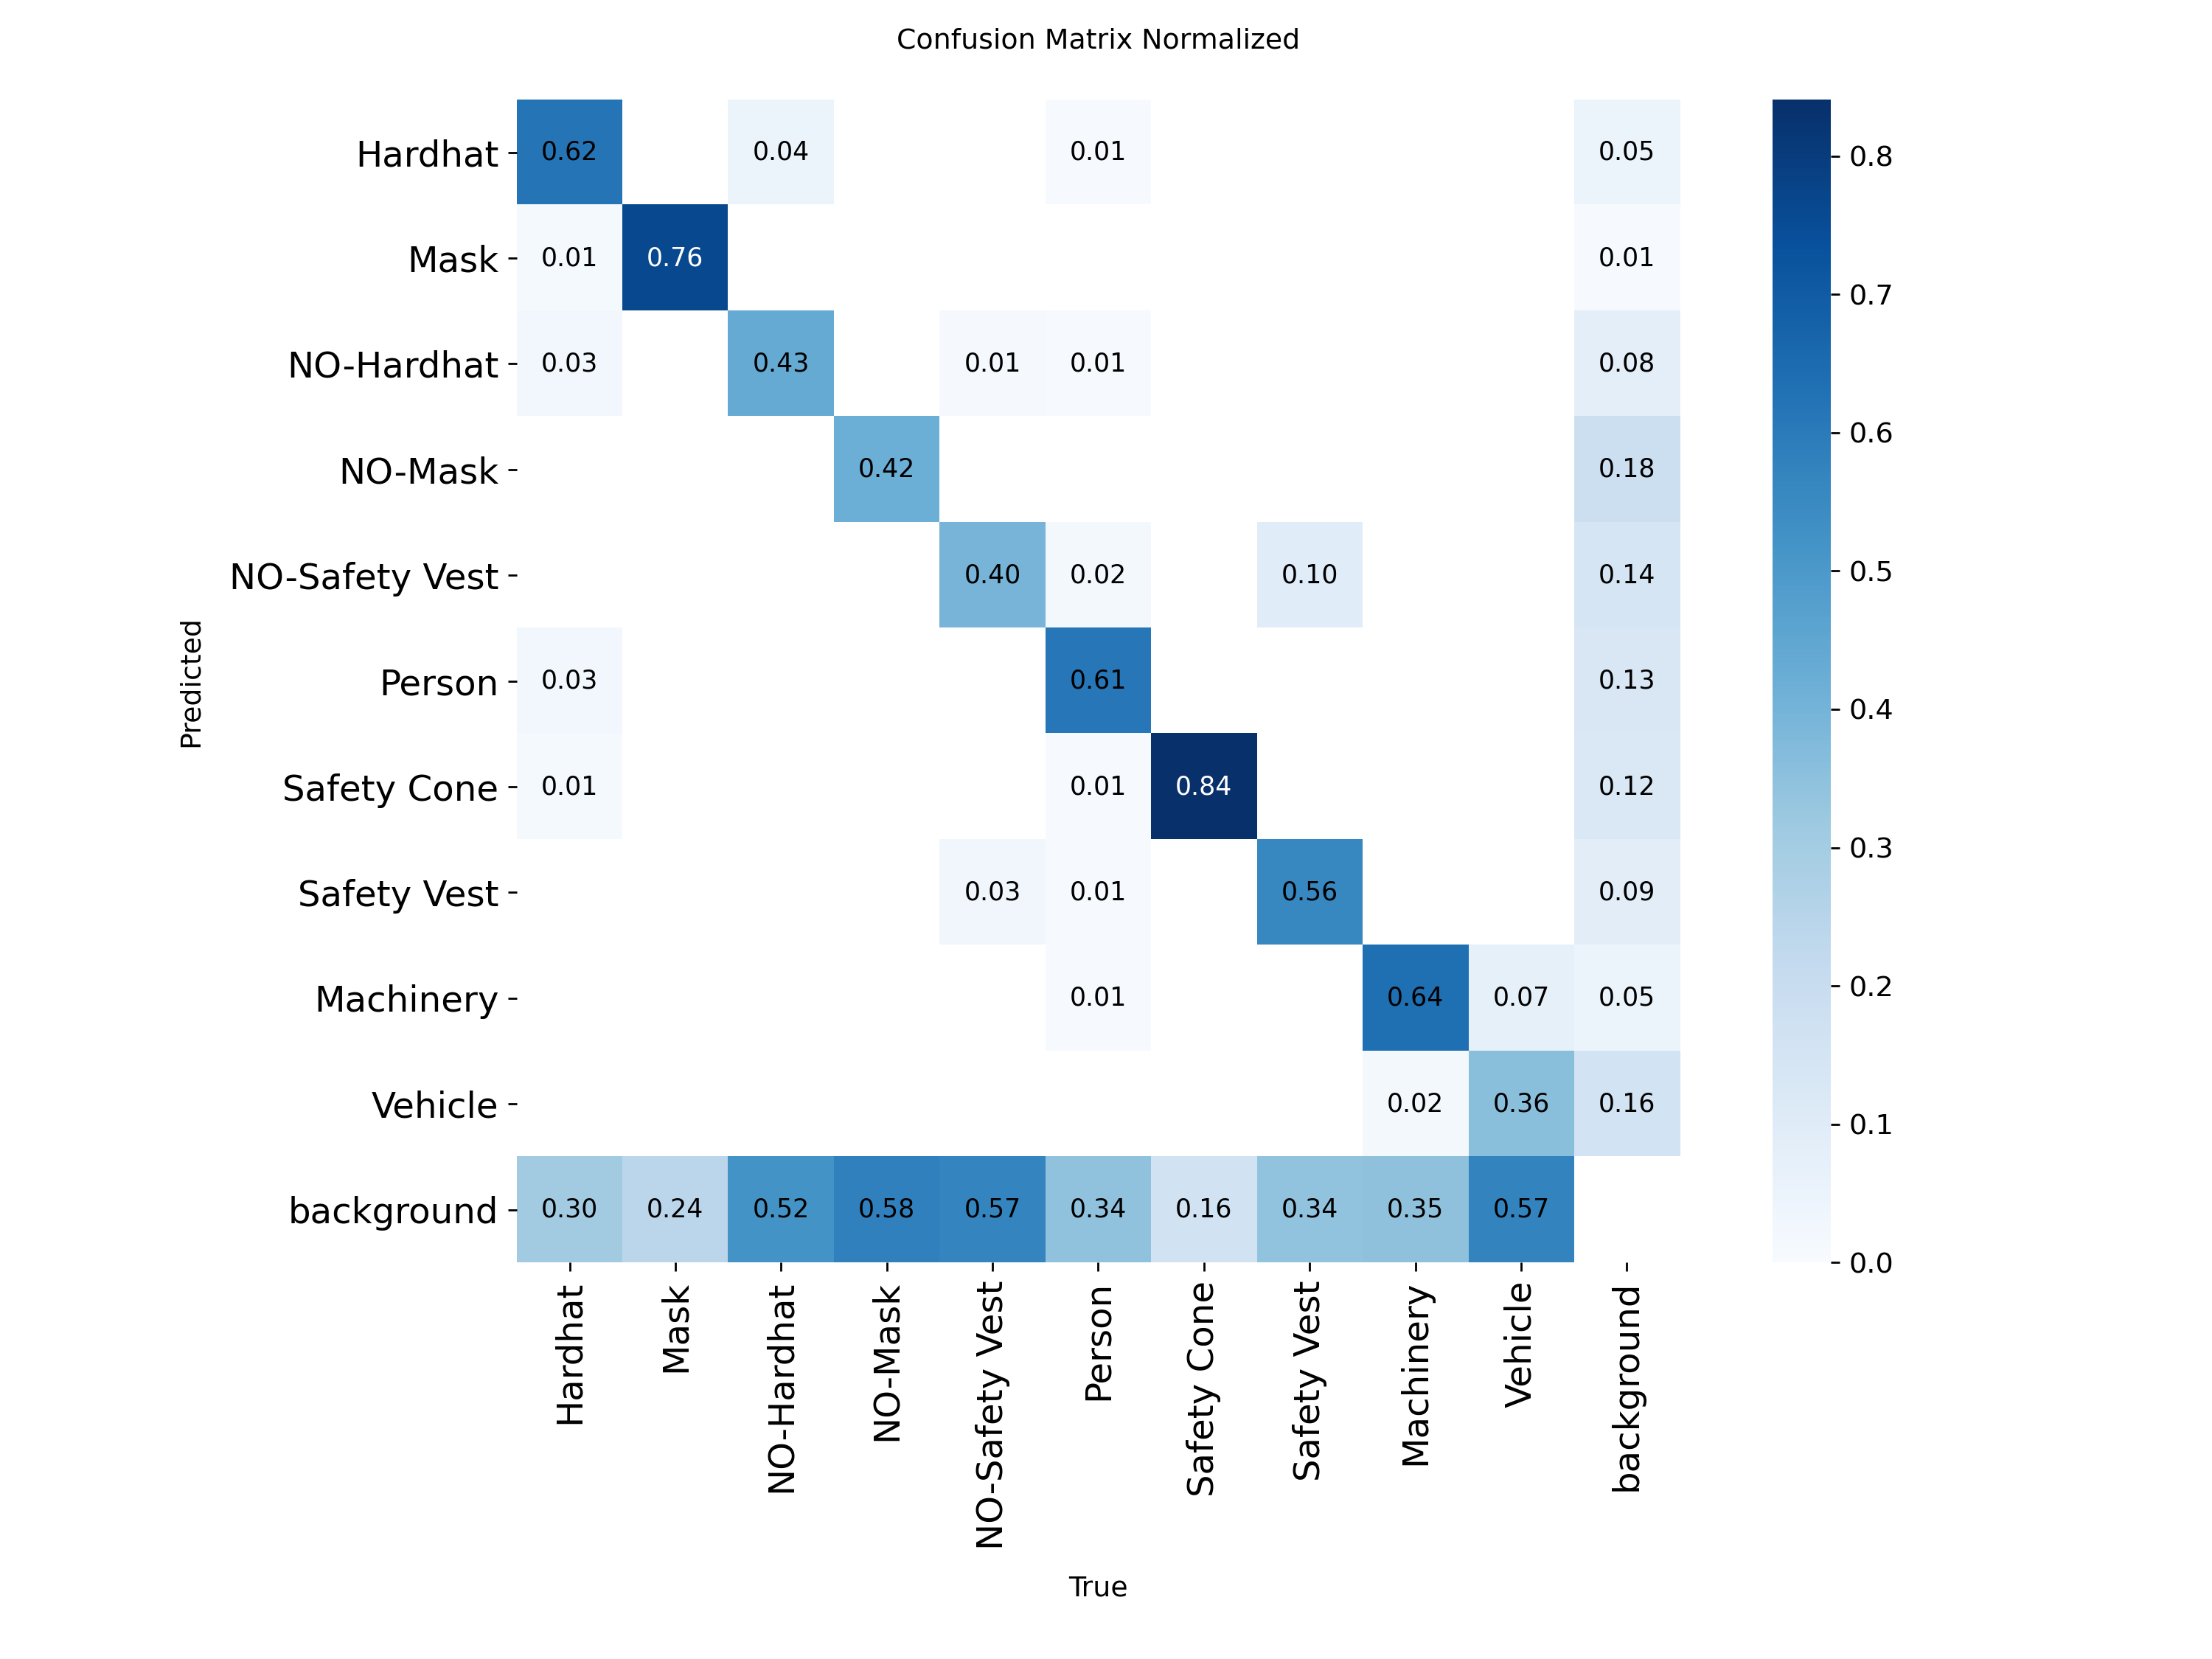

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val/PR_curve.png


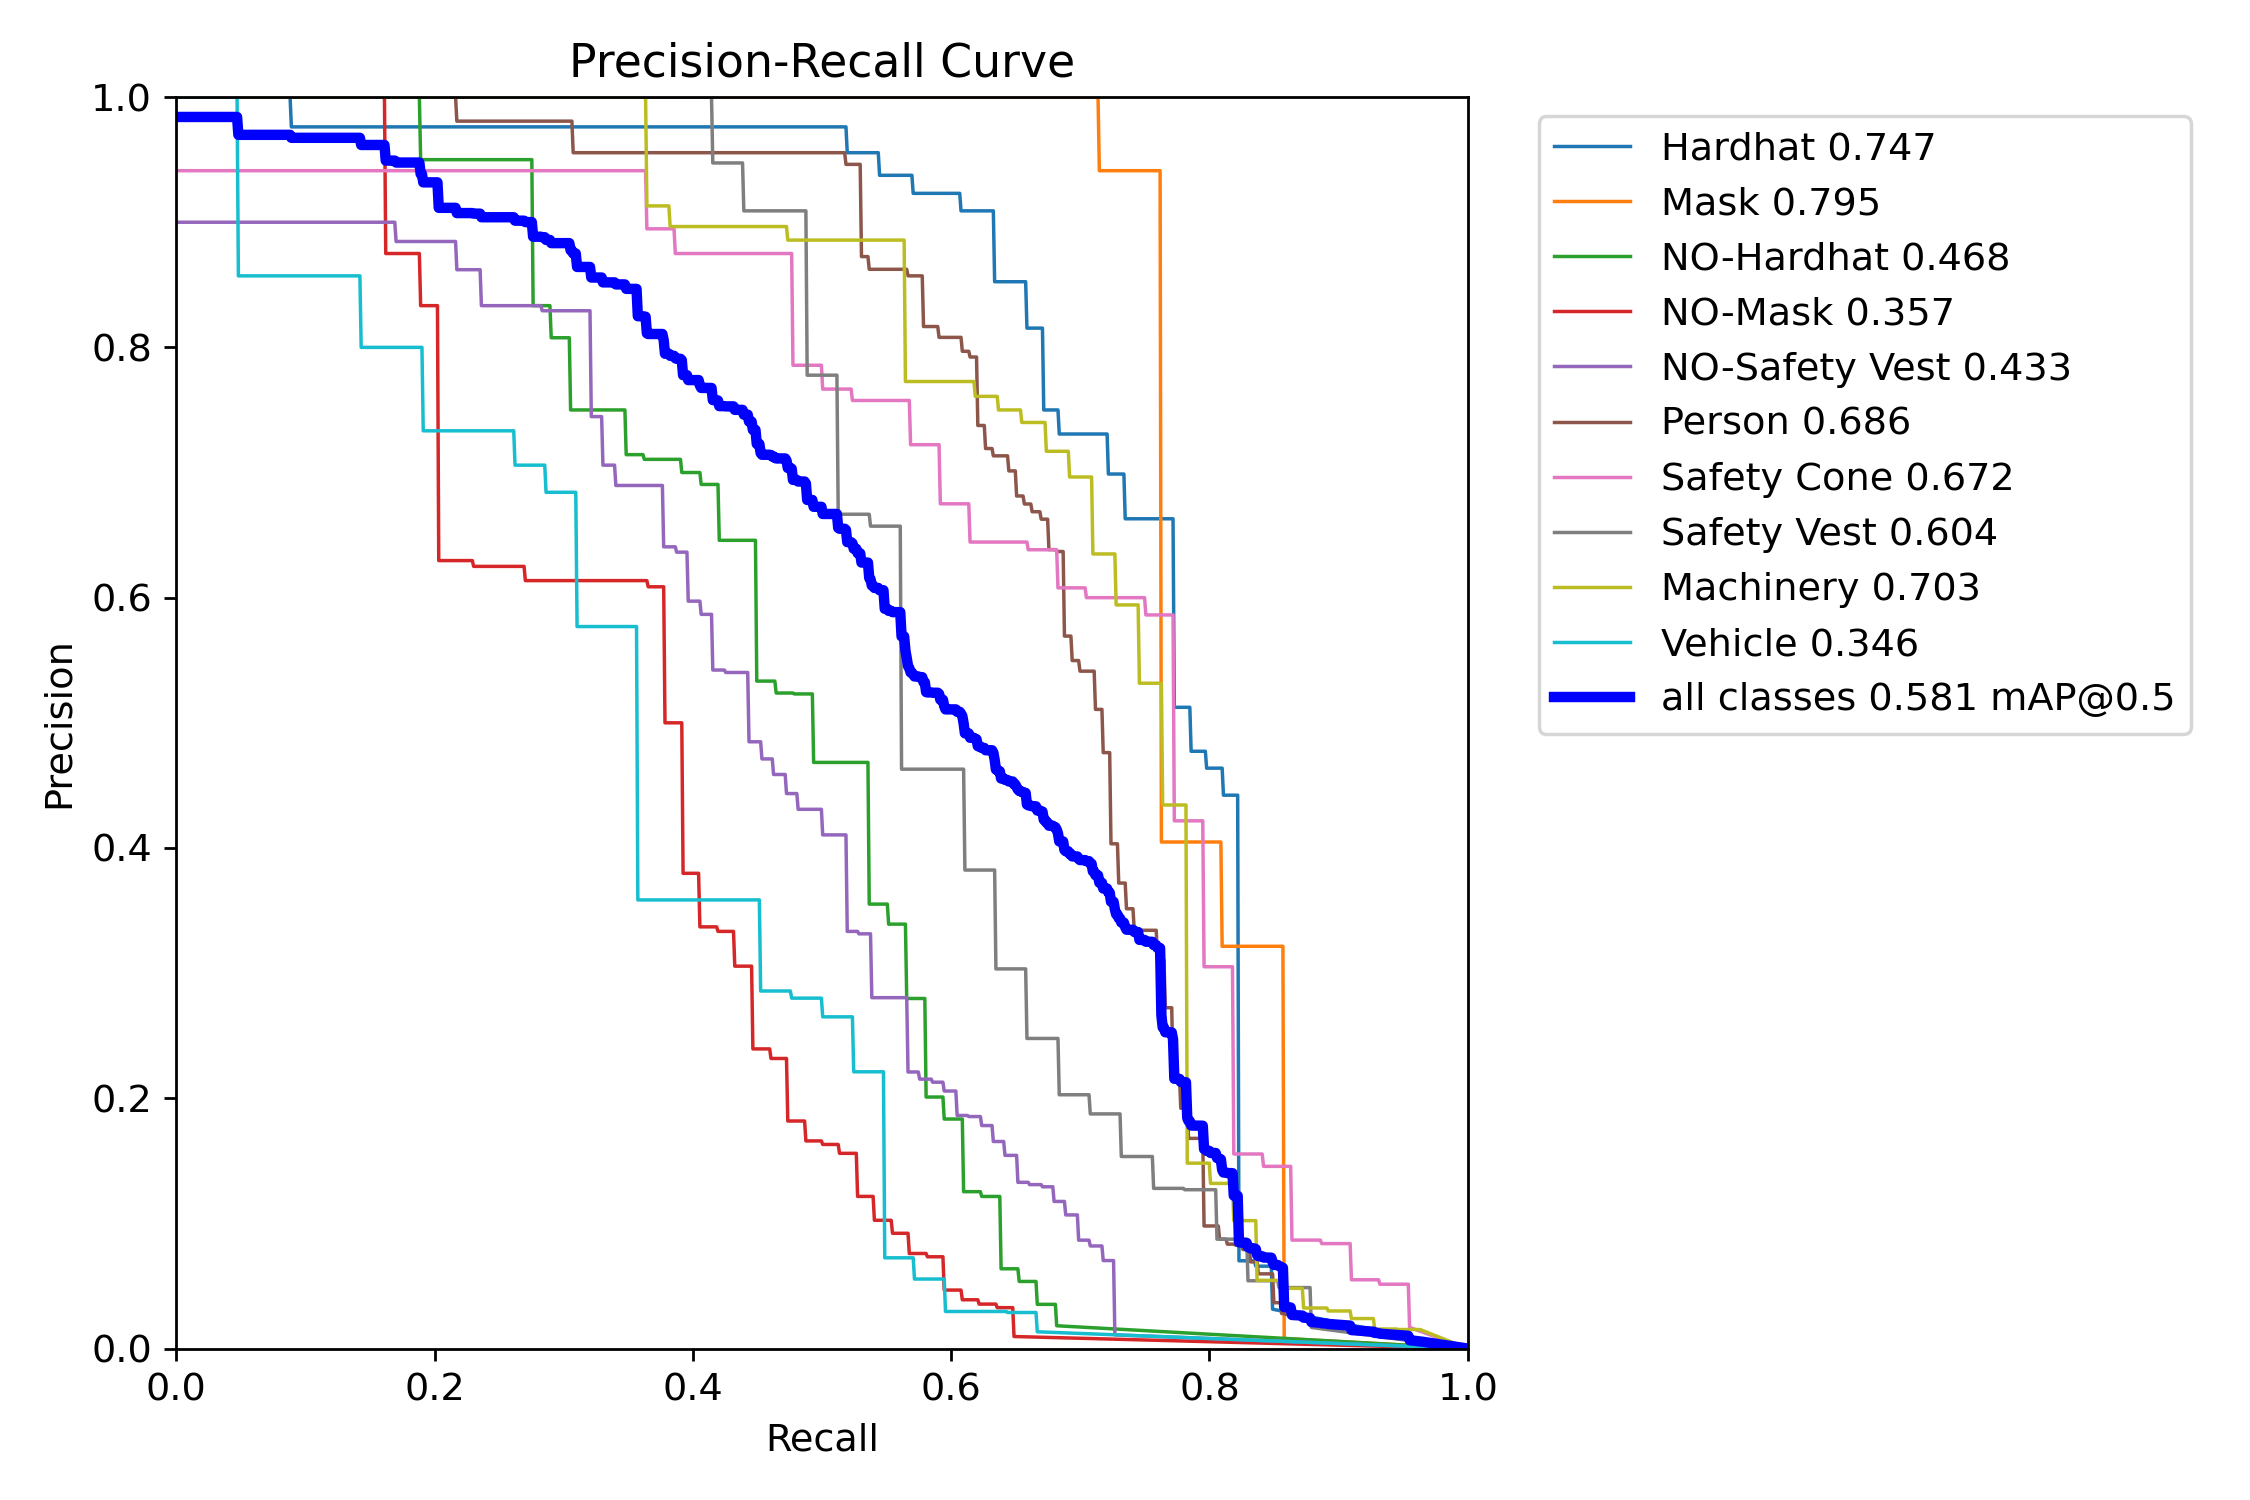

   • Affichage de /home/maxime/DataDevIA/computervision/security-checker/runs/detect/val/P_curve.png


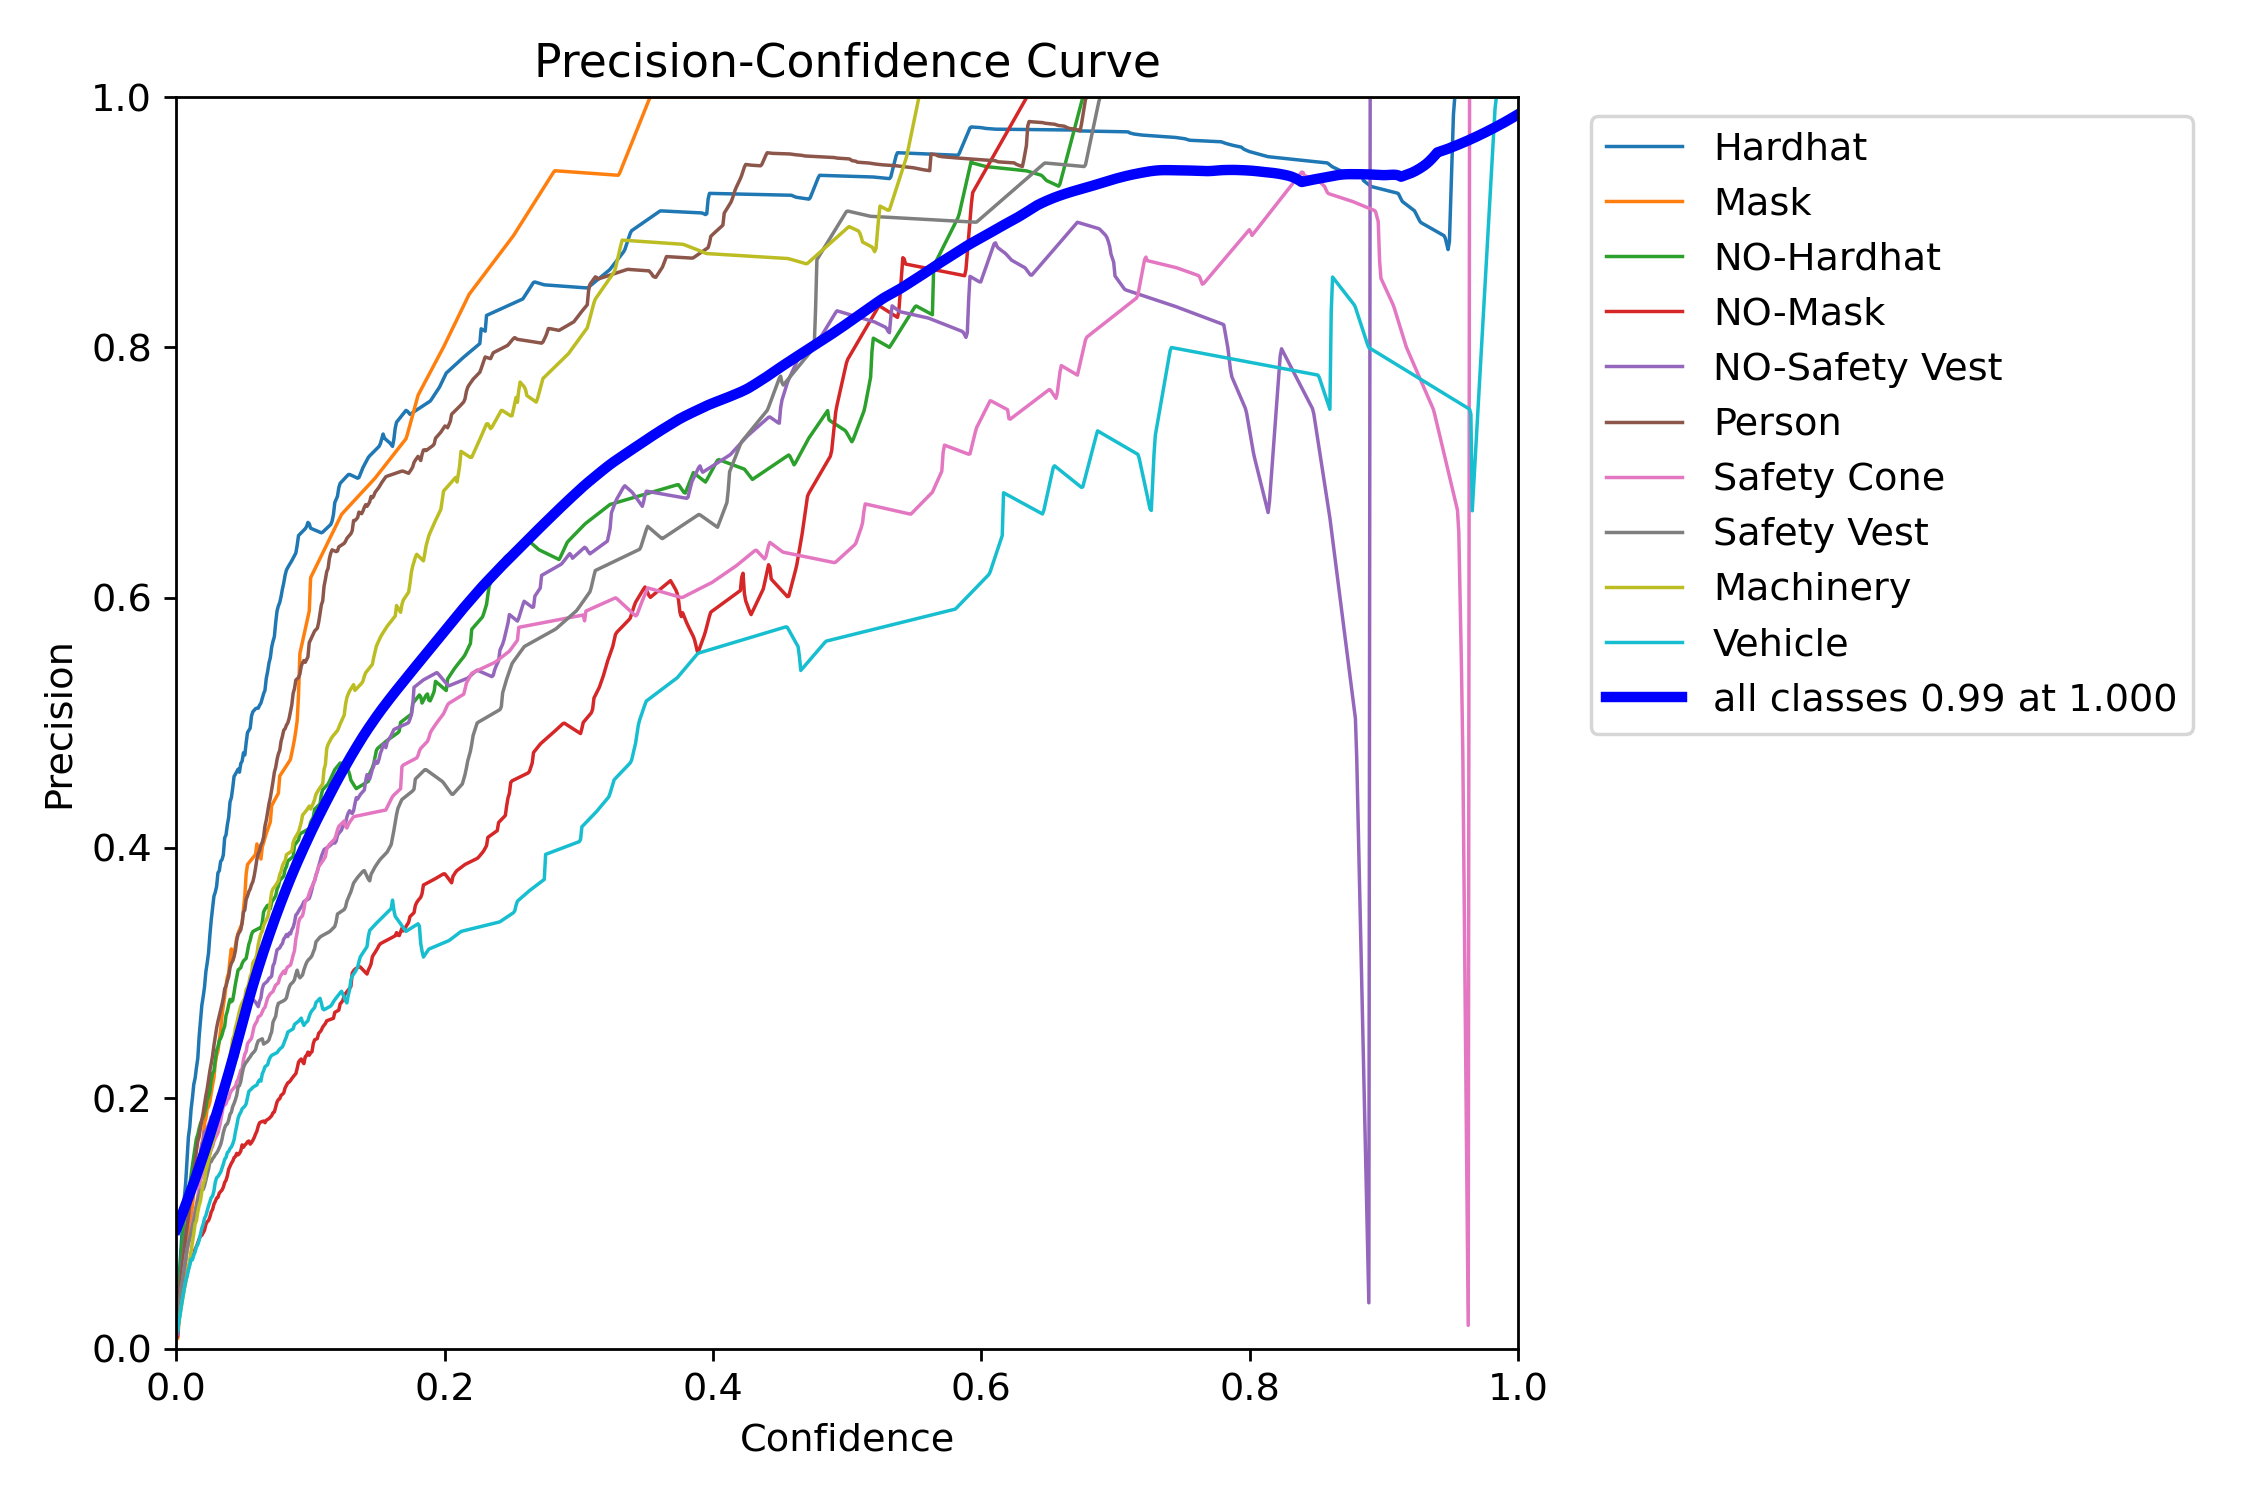

In [104]:
# Cellule X+3 altérée – Afficher quelques PNG pour chaque dossier 'val*' sous runs/detect

import os
import glob
from IPython.display import Image, display

runs_detect_dir = os.path.join(CFG.WORKING_PATH, "runs", "detect")
print("📂 Contenu de runs/detect/:")
for entry in os.listdir(runs_detect_dir):
    print("  •", entry)
print()

# 1. Repérer tous les sous‐dossiers dont le nom commence par 'val'
val_dirs = [
    d for d in os.listdir(runs_detect_dir)
    if os.path.isdir(os.path.join(runs_detect_dir, d)) and d.startswith("val")
]

if not val_dirs:
    print(f"⚠️ Aucun dossier 'val*' trouvé sous {runs_detect_dir}.")
else:
    for vd in val_dirs:
        dir_path = os.path.join(runs_detect_dir, vd)
        # 2. Lister tous les PNG dans ce dossier
        pngs = glob.glob(os.path.join(dir_path, "*.png"))
        if not pngs:
            print(f"⚠️ Aucun fichier PNG dans {dir_path}.")
            continue

        print(f"📁 Dossier '{vd}' contient {len(pngs)} PNG :")
        # 3. Afficher chaque PNG (ou en limiter le nombre si vous préférez)
        for p in pngs:
            print("   • Affichage de", p)
            display(Image(p))
        print()  # Ligne vide entre dossiers





In [106]:
# Cellule – Lister les dossiers de runs d’entraînement (train) et de validation (val) sous runs/detect

import os

runs_detect_dir = os.path.join(CFG.WORKING_PATH, "runs", "detect")
print("⇒ Contenu de runs/detect/ :")
if os.path.isdir(runs_detect_dir):
    for entry in os.listdir(runs_detect_dir):
        path = os.path.join(runs_detect_dir, entry)
        if os.path.isdir(path):
            print(f"   • {entry}/")
else:
    print(f"   ⚠️ Le dossier {runs_detect_dir} n’existe pas encore.")



⇒ Contenu de runs/detect/ :
   • val3/
   • val2/
   • val/


In [110]:
# Cellule – Vérification et chargement du modèle YOLOv11 Nano

import os
from ultralytics import YOLO

# 1. Définir le chemin vers yolo11n.pt
CFG.MODEL_PATH = "/home/maxime/DataDevIA/computervision/security-checker/yolo11n.pt"

# 2. Vérification que le fichier existe
print("Chemin utilisé pour le modèle :", CFG.MODEL_PATH)
print("Existe :", os.path.isfile(CFG.MODEL_PATH))

# 3. Chargement du modèle
model = YOLO(CFG.MODEL_PATH)
print("✅ Modèle chargé depuis :", CFG.MODEL_PATH)


Chemin utilisé pour le modèle : /home/maxime/DataDevIA/computervision/security-checker/yolo11n.pt
Existe : True
✅ Modèle chargé depuis : /home/maxime/DataDevIA/computervision/security-checker/yolo11n.pt


In [111]:
# Cellule X+4 – Détection, filtrage et affichage d’images avec indentation corrigée

import pandas as pd
import cv2
import matplotlib.pyplot as plt

# 1. Fonction pour détecter toutes les classes dans une liste d’images
def detect_all_classes(image_paths):
    """
    Pour chaque chemin d’image de image_paths, on exécute model(image_path)
    (le modèle YOLO doit déjà avoir été chargé dans la variable `model`),
    puis on récupère :
      - detected_boxes : liste de dictionnaires {label, confidence, coords}
      - detected_classes : ensemble des labels détectés dans l’image
    Renvoie un DataFrame pandas avec les colonnes :
      image_path, detected_boxes, detected_classes
    """
    detection_data = []

    for image_path in image_paths:
        results = model(image_path)  # ‘model’ doit exister en amont

        detected_boxes = []
        detected_classes = set()

        for result in results:  # parcourir chaque batch (ici batch=1)
            for box in result.boxes:
                label = CFG.PPE_CLASSES[int(box.cls)]
                confidence = float(box.conf)
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # coordonnées entières

                detected_boxes.append({
                    "label": label,
                    "confidence": confidence,
                    "coords": (x1, y1, x2, y2)
                })
                detected_classes.add(label)

        detection_data.append({
            "image_path": image_path,
            "detected_boxes": detected_boxes,
            "detected_classes": list(detected_classes)
        })

    return pd.DataFrame(detection_data)


# 2. Fonction pour filtrer les images selon des classes requises / exclues
def filter_images(df, required_classes=None, excluded_classes=None):
    """
    Filtre le DataFrame `df` pour ne conserver que les lignes (images) qui :
      - contiennent TOUTES les classes de required_classes
      - n’ont AUCUNE des classes de excluded_classes
    required_classes et excluded_classes peuvent être des listes de labels (ex. ["Hardhat"])
    """
    if required_classes is None:
        required_classes = []
    if excluded_classes is None:
        excluded_classes = []

    def class_filter(detected_list):
        detected_set = set(detected_list)
        # Toutes les classes requises doivent exister dans detected_set
        all_required = all(cls in detected_set for cls in required_classes)
        # Aucune des classes exclues ne doit être dans detected_set
        none_excluded = not any(cls in detected_set for cls in excluded_classes)
        return all_required and none_excluded

    return df[df["detected_classes"].apply(class_filter)]


# 3. Fonction pour afficher une image choisie aléatoirement depuis le DataFrame filtré
def show_random_image(df):
    """
    Sélectionne au hasard une ligne du DataFrame `df`, puis :
      - lit l’image en BGR (OpenCV) et convertit en RGB
      - dessine chaque boîte stockée dans detected_boxes
      - affiche l’image annotée avec matplotlib
    Si df est vide, affiche un message et quitte.
    """
    if df.empty:
        print("⚠️ Aucune image ne correspond aux critères de filtre.")
        return

    # Sélectionner une seule ligne aléatoirement
    selected_row = df.sample(1).iloc[0]
    image_path = selected_row["image_path"]
    detected_boxes = selected_row["detected_boxes"]

    # Lire l’image et vérifier qu’elle existe
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Impossible de lire l’image : {image_path}")
        return

    # Conversion BGR→RGB pour affichage avec matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_copy = img_rgb.copy()

    # Dessiner chaque boîte détectée
    for box in detected_boxes:
        x1, y1, x2, y2 = box["coords"]
        label = box["label"]

        color = (0, 255, 0)            # vert
        font_scale = 0.5
        thickness = 1

        # Rectangle
        cv2.rectangle(img_copy, (x1, y1), (x2, y2), color, thickness)

        # Préparer le texte (label)
        (text_width, text_height), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_PLAIN, font_scale, thickness
        )
        text_x = x1
        text_y = y1 + text_height + 2

        cv2.putText(
            img_copy,
            label,
            (text_x, text_y),
            cv2.FONT_HERSHEY_PLAIN,
            font_scale,
            color,
            thickness
        )

    # Afficher l’image annotée
    plt.figure(figsize=(8, 8))
    plt.imshow(img_copy)
    plt.axis("off")
    plt.show()



In [113]:
# Exemple de cellule (à avoir exécuté avant d’appeler detect_all_classes)
from ultralytics import YOLO

CFG.MODEL_PATH = best_pt  # best_pt trouvé après fine-tuning
model = YOLO(CFG.MODEL_PATH)
print("✅ Modèle PPE chargé :", CFG.MODEL_PATH)


✅ Modèle PPE chargé : /home/maxime/DataDevIA/computervision/security-checker/yolo11_ppe_train5/weights/best.pt


In [114]:
df_detections = detect_all_classes(image_paths)


image 1/1 /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images/image_13_jpg.rf.2b8a935fb25cb33b55fa32f6906d63ad.jpg: 640x640 1 Person, 10 Safety Cones, 1 Machinery, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images/youtube-641_jpg.rf.4724b1e29ecd316e64dc41f811a3470d.jpg: 640x640 1 Person, 3 Machinerys, 8.0ms
Speed: 2.7ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images/-2297-_png_jpg.rf.1d5b556861b3c2f1b54baa569a52cb1c.jpg: 640x640 1 Hardhat, 2 Persons, 1 Safety Vest, 6 Machinerys, 8.6ms
Speed: 1.1ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/maxime/DataDevIA/computervision/datasetcomputervision/css-data/train/images/construction-693

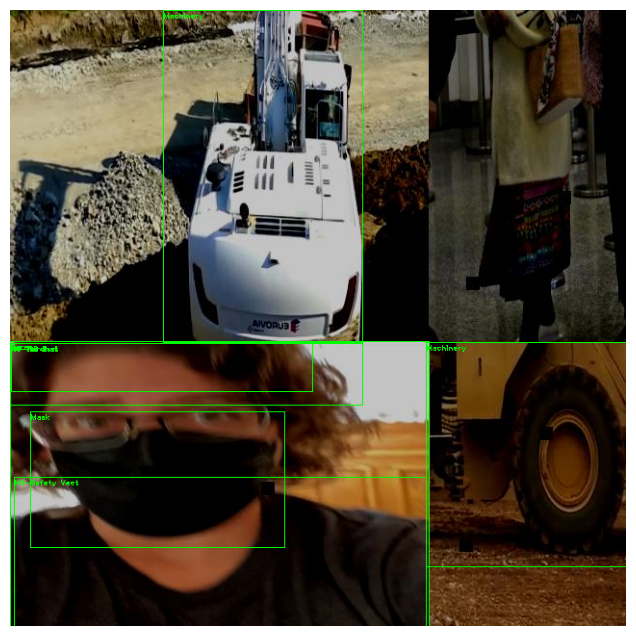

In [115]:
show_random_image(df_detections)



In [118]:
# Filter images with only 'Person' or 'Person' + 'NO-Hardhat'
df_filtered = filter_images(df_detections, required_classes=["Person"], excluded_classes=["Hardhat", "Mask", "Safety Vest"])



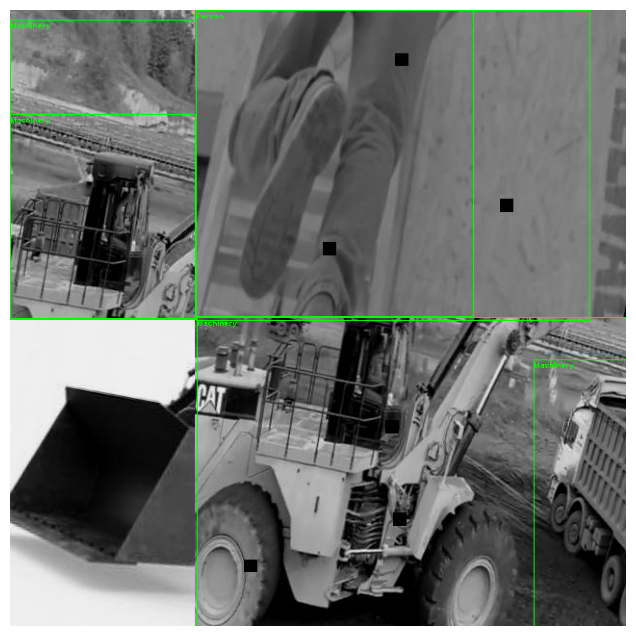

In [122]:
show_random_image(df_filtered)